In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

/home/joel/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


In [2]:
plt.style.use("seaborn")

## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/Canada_2021_access.csv")
IND_u= pd.read_csv('../Datasets/Canada_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts(normalize=True)

1    0.507448
0    0.492552
Name: fin34a, dtype: float64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

female   age         educ    inc_q
0         F  75.0  high school   middle
1         M  30.0   university  richest
2         M  41.0  high school   second
3         F  64.0   university  richest
4         M  40.0   university   second
...     ...   ...          ...      ...
1002      M  60.0   university   fourth
1003      F  57.0  high school  poorest
1004      M  35.0   university  richest
1005      M  69.0   university  richest
1006      M  34.0   university   fourth

[1007 rows x 4 columns]

In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q        fourth  middle  poorest  richest  second
educ                                                 
high school     122     122      105       96     130
primary           0       3        6        3       2
university      103      72       33      152      58

In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

In [8]:
IND_a= IND_a.drop(columns= ["account_mob", "fin1_1a", "fin1_1b"])
IND_a

account_fin fin2 fin7 mobileowner internetaccess
0            Yes  Yes   No         Yes            Yes
1            Yes  Yes  Yes         Yes            Yes
2            Yes  Yes  Yes         Yes            Yes
3            Yes  Yes  Yes         Yes            Yes
4            Yes  Yes  Yes         Yes            Yes
...          ...  ...  ...         ...            ...
1002         Yes  Yes  Yes         Yes            Yes
1003         Yes  Yes  Yes         Yes            Yes
1004         Yes  Yes  Yes         Yes            Yes
1005         Yes  Yes  Yes         Yes            Yes
1006         Yes  Yes  Yes         Yes            Yes

[1007 rows x 5 columns]

In [9]:
IND_u= IND_u.drop(columns= ["fin1_1a", "fin1_1b", "fin26", "fin28","fin17b", "merchantpay_dig"])
IND_u

fin4 fin5 fin8 fin9 fin10 fin10b  fin14_1 fin14a fin14a1 fin14b  ...  \
0      No   No  NaN  Yes   Yes     No        2     No      No     No  ...   
1     Yes  Yes  Yes  Yes   Yes    Yes        2     No     Yes     No  ...   
2     Yes  Yes   No  Yes   Yes    Yes        2    Yes      No     No  ...   
3     Yes  Yes  Yes  Yes   Yes    Yes        1    Yes      No    Yes  ...   
4      No  Yes  Yes  Yes   Yes    Yes        1    Yes     Yes     No  ...   
...   ...  ...  ...  ...   ...    ...      ...    ...     ...    ...  ...   
1002  Yes  Yes  Yes  Yes   Yes    Yes        2    Yes     Yes    Yes  ...   
1003  Yes  Yes  Yes  Yes   Yes    Yes        2    Yes     Yes    Yes  ...   
1004  Yes  Yes  Yes  Yes   Yes    Yes        2    Yes     Yes    Yes  ...   
1005  Yes  Yes  Yes  Yes   Yes    Yes        2    Yes     Yes     No  ...   
1006  Yes  Yes  Yes  Yes   Yes    Yes        1    Yes     Yes    Yes  ...   

     fin22b fin30 fin31a fin31b fin32 fin37 fin38 saved  borrowed  \
0        No   Yes    Yes     No    No     1   Yes     2         2   
1        No   Yes    Yes     No   Yes     2    No     1         1   
2       Yes    No    NaN    NaN   Yes     1    No     1         1   
3        No   Yes    Yes     No    No     2   Yes     1         1   
4        No   Yes    Yes     No   Yes     2    No     1         1   
...     ...   ...    ...    ...   ...   ...   ...   ...       ...   
1002     No    No    NaN    NaN    No     1    No     1         1   
1003     No   Yes    Yes    Yes    No     1   Yes     1         1   
1004     No   Yes    Yes     No   Yes     2    No     1         1   
1005    Yes   Yes    Yes     No   Yes     1   Yes     1         1   
1006     No   Yes    Yes    Yes   Yes     2    No     1         1   

     anydigpayment  
0                1  
1                1  
2                1  
3                1  
4                1  
...            ...  
1002             1  
1003             1  
1004             1  
1005             1  
1006             1  

[1007 rows x 23 columns]

## Implementing MCA

In [10]:
mca_a = prince.MCA(n_components=6)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names)
IND_a_index

aPC1      aPC2      aPC3      aPC4      aPC5      aPC6
0     0.278817 -0.251892 -1.187744 -0.016596  0.072660  0.001534
1    -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157
2    -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157
3    -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157
4    -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157
...        ...       ...       ...       ...       ...       ...
1002 -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157
1003 -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157
1004 -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157
1005 -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157
1006 -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157

[1007 rows x 6 columns]

In [11]:
mca_u = prince.MCA(n_components=26)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names)
IND_u_index

uPC1      uPC2      uPC3      uPC4      uPC5      uPC6      uPC7  \
0     0.956286 -0.082382 -0.290761  0.270448  0.006280 -0.225773 -0.049683   
1    -0.000524 -0.217199  0.259461  0.091441 -0.130412 -0.002256 -0.117705   
2     0.198340  0.406431  0.646609 -0.233426 -0.407133  0.297546  0.225516   
3     0.001461 -0.380374 -0.157569 -0.176300  0.141513  0.128978  0.030563   
4    -0.126918 -0.285320  0.085337  0.133947  0.120940 -0.170730 -0.256781   
...        ...       ...       ...       ...       ...       ...       ...   
1002 -0.160187  0.133760  0.293221 -0.377796  0.309999  0.094693 -0.115653   
1003 -0.306579 -0.163642 -0.196542 -0.035341  0.053999 -0.047114  0.364650   
1004 -0.331825 -0.129452  0.106563  0.023238  0.080669  0.081076 -0.070681   
1005 -0.199169 -0.060727 -0.099660  0.052836 -0.275173 -0.320962  0.095852   
1006 -0.355074  0.168315 -0.058517  0.019096 -0.030105  0.093119  0.013966   

          uPC8      uPC9     uPC10  ...     uPC17     uPC18     uPC19  \
0     0.135323  0.227469 -0.156931  ...  0.014425 -0.021213  0.162355   
1    -0.004867 -0.146227 -0.008060  ... -0.097437  0.191599 -0.080359   
2     0.300518  0.697588  0.433621  ...  0.058271 -0.033647 -0.131833   
3     0.160435 -0.048057 -0.067094  ...  0.058613 -0.002577  0.011661   
4    -0.178592  0.219587  0.170169  ... -0.001650 -0.132930 -0.010197   
...        ...       ...       ...  ...       ...       ...       ...   
1002  0.112588  0.078146 -0.053016  ...  0.026064 -0.108044 -0.056397   
1003  0.214809  0.018362 -0.071976  ... -0.001764  0.077540 -0.001728   
1004 -0.058965 -0.057900  0.006945  ...  0.016060 -0.017198  0.000976   
1005  0.380944  0.104894 -0.159445  ...  0.053775  0.025705 -0.012964   
1006 -0.062104 -0.169949  0.204312  ... -0.293960 -0.051666 -0.028146   

         uPC20     uPC21     uPC22     uPC23     uPC24     uPC25     uPC26  
0    -0.160400 -0.007834  0.028940 -0.024202 -0.032664 -0.020266 -0.006865  
1     0.034335 -0.002286  0.009491 -0.008725  0.003209 -0.001728  0.001967  
2    -0.070710  0.061671  0.053112 -0.019078  0.091452  0.033981 -0.018105  
3     0.017212 -0.132943 -0.010093  0.001472 -0.002322  0.014426  0.006160  
4     0.009437 -0.125569 -0.000256  0.017205  0.011912  0.009204 -0.002666  
...        ...       ...       ...       ...       ...       ...       ...  
1002 -0.085296  0.085608  0.028208 -0.007178 -0.003961 -0.001996 -0.001988  
1003 -0.081807  0.085308  0.013077  0.003847 -0.006212 -0.000213  0.003587  
1004  0.033444  0.029536  0.009175 -0.010260  0.000177 -0.001333  0.001838  
1005 -0.070356  0.030830  0.018834  0.022077 -0.029496 -0.013279  0.010080  
1006  0.041344 -0.077548 -0.035623  0.014383  0.009497  0.012524  0.000416  

[1007 rows x 26 columns]

In [12]:
X = pd.concat([IND_a_index, IND_u_index], axis=1)
X

aPC1      aPC2      aPC3      aPC4      aPC5      aPC6      uPC1  \
0     0.278817 -0.251892 -1.187744 -0.016596  0.072660  0.001534  0.956286   
1    -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157 -0.000524   
2    -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157  0.198340   
3    -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157  0.001461   
4    -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157 -0.126918   
...        ...       ...       ...       ...       ...       ...       ...   
1002 -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157 -0.160187   
1003 -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157 -0.306579   
1004 -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157 -0.331825   
1005 -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157 -0.199169   
1006 -0.231511  0.076949  0.067296  0.019021  0.027559 -0.000157 -0.355074   

          uPC2      uPC3      uPC4  ...     uPC17     uPC18     uPC19  \
0    -0.082382 -0.290761  0.270448  ...  0.014425 -0.021213  0.162355   
1    -0.217199  0.259461  0.091441  ... -0.097437  0.191599 -0.080359   
2     0.406431  0.646609 -0.233426  ...  0.058271 -0.033647 -0.131833   
3    -0.380374 -0.157569 -0.176300  ...  0.058613 -0.002577  0.011661   
4    -0.285320  0.085337  0.133947  ... -0.001650 -0.132930 -0.010197   
...        ...       ...       ...  ...       ...       ...       ...   
1002  0.133760  0.293221 -0.377796  ...  0.026064 -0.108044 -0.056397   
1003 -0.163642 -0.196542 -0.035341  ... -0.001764  0.077540 -0.001728   
1004 -0.129452  0.106563  0.023238  ...  0.016060 -0.017198  0.000976   
1005 -0.060727 -0.099660  0.052836  ...  0.053775  0.025705 -0.012964   
1006  0.168315 -0.058517  0.019096  ... -0.293960 -0.051666 -0.028146   

         uPC20     uPC21     uPC22     uPC23     uPC24     uPC25     uPC26  
0    -0.160400 -0.007834  0.028940 -0.024202 -0.032664 -0.020266 -0.006865  
1     0.034335 -0.002286  0.009491 -0.008725  0.003209 -0.001728  0.001967  
2    -0.070710  0.061671  0.053112 -0.019078  0.091452  0.033981 -0.018105  
3     0.017212 -0.132943 -0.010093  0.001472 -0.002322  0.014426  0.006160  
4     0.009437 -0.125569 -0.000256  0.017205  0.011912  0.009204 -0.002666  
...        ...       ...       ...       ...       ...       ...       ...  
1002 -0.085296  0.085608  0.028208 -0.007178 -0.003961 -0.001996 -0.001988  
1003 -0.081807  0.085308  0.013077  0.003847 -0.006212 -0.000213  0.003587  
1004  0.033444  0.029536  0.009175 -0.010260  0.000177 -0.001333  0.001838  
1005 -0.070356  0.030830  0.018834  0.022077 -0.029496 -0.013279  0.010080  
1006  0.041344 -0.077548 -0.035623  0.014383  0.009497  0.012524  0.000416  

[1007 rows x 32 columns]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [20]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .31, 1: .96}], 
              'C': [i for i in range(1,2)]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [21]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 1, 'class_weight': {0: 0.31, 1: 0.96}}
Best score: 0.953116860384404


In [22]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.75
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9818360333824252
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        97
           1       0.95      0.99      0.97       105

    accuracy                           0.97       202
   macro avg       0.97      0.96      0.97       202
weighted avg       0.97      0.97      0.97       202



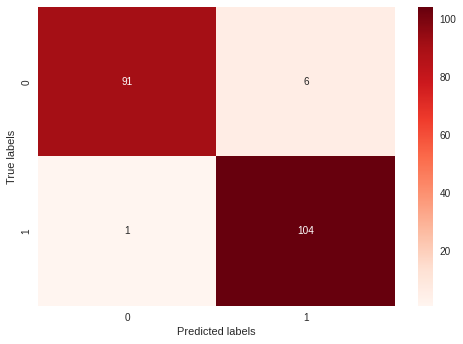

In [23]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [24]:
f1_score(y_test, y_pred)

0.9674418604651163

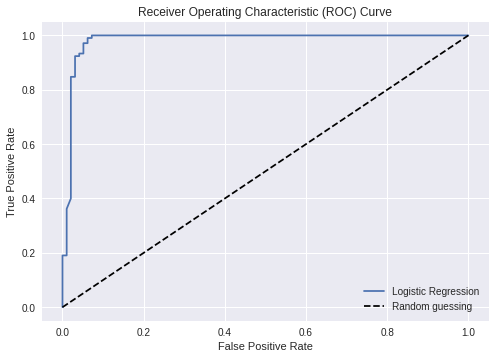

In [25]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [30]:
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [87],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'class_weight': [{0: .18, 1: .69}]
}
rf = RandomForestClassifier(random_state= 42)

In [31]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.18, 1: 0.69}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 87}
Best score: 0.9312659698025552


In [32]:
auc2 = roc_auc_score(y_test, proba[:,1], multi_class='auto')
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9853706431026019
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        97
           1       0.94      0.98      0.96       105

    accuracy                           0.96       202
   macro avg       0.96      0.95      0.96       202
weighted avg       0.96      0.96      0.96       202



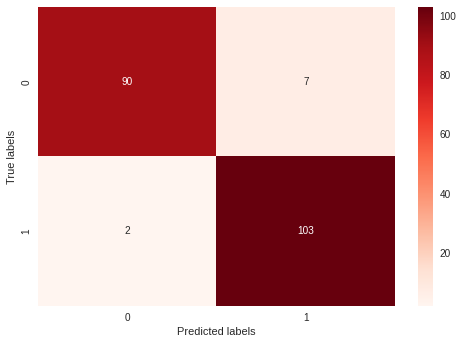

In [33]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

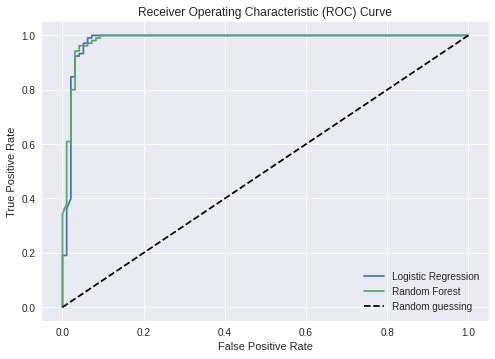

In [34]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [35]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [36]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.9178764304499298


In [37]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [38]:
auc4 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9837997054491898
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        97
           1       0.94      0.95      0.95       105

    accuracy                           0.95       202
   macro avg       0.95      0.95      0.95       202
weighted avg       0.95      0.95      0.95       202



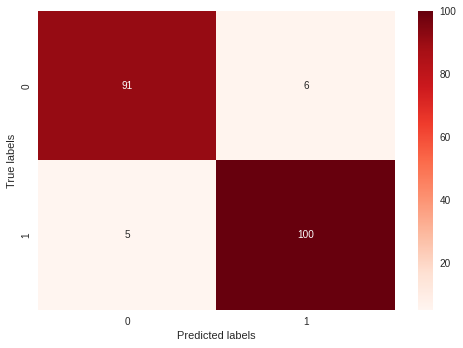

In [39]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

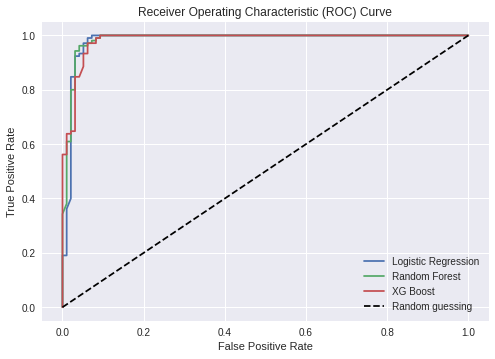

In [40]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [41]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [42]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [43]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
21/21 [==============================] - 1s 9ms/step - loss: 0.6558 - precision: 0.9051 - recall: 0.4360 - val_loss: 0.6300 - val_precision: 0.8507 - val_recall: 0.7308
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5909 - precision: 0.9125 - recall: 0.8262 - val_loss: 0.5669 - val_precision: 0.8701 - val_recall: 0.8590
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5066 - precision: 0.9099 - recall: 0.8933 - val_loss: 0.4837 - val_precision: 0.8625 - val_recall: 0.8846
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4054 - precision: 0.9107 - recall: 0.9329 - val_loss: 0.3914 - val_precision: 0.8588 - val_recall: 0.9359
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 0.3026 - precision: 0.9307 - recall: 0.9421 - val_loss: 0.3131 - val_precision: 0.8795 - val_recall: 0.9359
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.2271 - precision: 0.9260 -

21/21 [==============================] - 0s 2ms/step - loss: 0.0817 - precision: 0.9480 - recall: 1.0000 - val_loss: 0.3044 - val_precision: 0.8690 - val_recall: 0.9359
Epoch 47/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0825 - precision: 0.9507 - recall: 1.0000 - val_loss: 0.3063 - val_precision: 0.8721 - val_recall: 0.9615
Epoch 48/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0795 - precision: 0.9535 - recall: 1.0000 - val_loss: 0.3090 - val_precision: 0.8690 - val_recall: 0.9359
Epoch 49/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0787 - precision: 0.9507 - recall: 1.0000 - val_loss: 0.3109 - val_precision: 0.8690 - val_recall: 0.9359
Epoch 50/50
21/21 [==============================] - 0s 2ms/step - loss: 0.0775 - precision: 0.9507 - recall: 1.0000 - val_loss: 0.3111 - val_precision: 0.8690 - val_recall: 0.9359


In [44]:
y_ = ann.predict(X_test)

7/7 [==============================] - 0s 668us/step


In [45]:
y_= y_.reshape(y_.shape[0],)

In [46]:
y_pred= np.array([round(i) for i in y_])

In [47]:
auc5 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc5)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9665193912616593
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        97
           1       0.94      0.98      0.96       105

    accuracy                           0.96       202
   macro avg       0.96      0.95      0.96       202
weighted avg       0.96      0.96      0.96       202



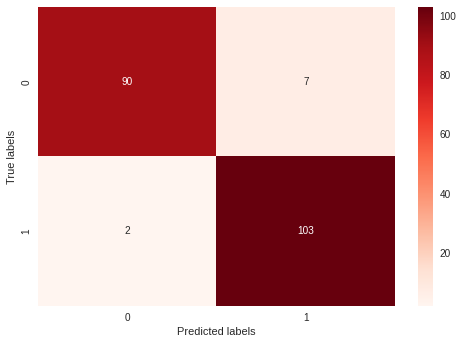

In [48]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

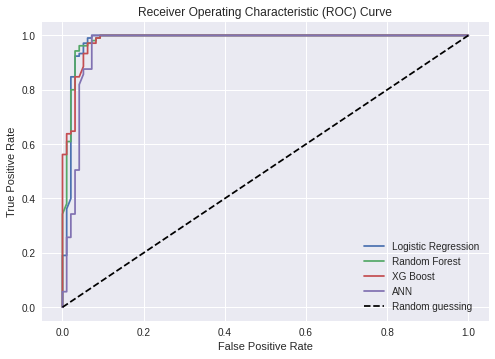

In [49]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot(fpr4, tpr4, label='ANN')
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Model Evaluations

In [38]:
lr_l= []
rf_l= []
xgb_l= []
ann_l= []
for i in range(150):
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state= i)
    
    lr_model = LogisticRegression(**grid_search_lr.best_params_)
    lr_model.fit(X_train, y_train)
    y_1= lr_model.predict_proba(X_test)[:,1]
    lr_loss= log_loss(y_test, y_1)
    lr_l.append(lr_loss)
    
    rf_model= RandomForestClassifier(**grid_search_rf.best_params_)
    rf_model.fit(X_train, y_train)
    y_2= rf_model.predict_proba(X_test)[:,1]
    rf_loss= log_loss(y_test, y_2)
    rf_l.append(rf_loss)
    
    xgb_model= XGBClassifier(**grid_search_xgb.best_params_)
    xgb_model.fit(X_train, y_train)
    y_3= xgb_model.predict_proba(X_test)[:,1]
    xgb_loss= log_loss(y_test, y_3)
    xgb_l.append(xgb_loss)
    
    
    ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    ann.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    history = ann.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      validation_split=0.2)
    y_4 = ann.predict(X_test)
    ann_loss= log_loss(y_test, y_4)
    ann_l.append(ann_loss)
    
    

Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6346 - precision_1: 0.3333 - recall_1: 0.0088 - val_loss: 0.6303 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5694 - precision_1: 1.0000 - recall_1: 0.0925 - val_loss: 0.5862 - val_precision_1: 1.0000 - val_recall_1: 0.2206
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5072 - precision_1: 0.9659 - recall_1: 0.3744 - val_loss: 0.5344 - val_precision_1: 0.9310 - val_recall_1: 0.3971
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4381 - precision_1: 0.8643 - recall_1: 0.5330 - val_loss: 0.4651 - val_precision_1: 0.8696 - val_recall_1: 0.5882
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3649 - precision_1: 0.8717 - recall_1: 0.7181 - val_loss: 0.3803 - val_precision_1: 0.9167 - val_recall_1: 0.8088
Epoch 6/50
20/20 [==============================] - 

20/20 [==============================] - 0s 2ms/step - loss: 0.0390 - precision_2: 0.9791 - recall_2: 1.0000 - val_loss: 0.1408 - val_precision_2: 0.9865 - val_recall_2: 0.9241
Epoch 38/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0372 - precision_2: 0.9750 - recall_2: 1.0000 - val_loss: 0.1548 - val_precision_2: 0.9865 - val_recall_2: 0.9241
Epoch 39/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0356 - precision_2: 0.9791 - recall_2: 1.0000 - val_loss: 0.1326 - val_precision_2: 0.9865 - val_recall_2: 0.9241
Epoch 40/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0351 - precision_2: 0.9710 - recall_2: 1.0000 - val_loss: 0.1534 - val_precision_2: 0.9863 - val_recall_2: 0.9114
Epoch 41/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0328 - precision_2: 0.9791 - recall_2: 1.0000 - val_loss: 0.1499 - val_precision_2: 0.9863 - val_recall_2: 0.9114
Epoch 42/50
20/20 [==============================] - 0s 2ms/step - 

20/20 [==============================] - 0s 2ms/step - loss: 0.0634 - precision_4: 0.9569 - recall_4: 1.0000 - val_loss: 0.1765 - val_precision_4: 0.8939 - val_recall_4: 0.9365
Epoch 24/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0606 - precision_4: 0.9606 - recall_4: 1.0000 - val_loss: 0.1784 - val_precision_4: 0.8939 - val_recall_4: 0.9365
Epoch 25/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0577 - precision_4: 0.9644 - recall_4: 1.0000 - val_loss: 0.1804 - val_precision_4: 0.9077 - val_recall_4: 0.9365
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0553 - precision_4: 0.9644 - recall_4: 1.0000 - val_loss: 0.1806 - val_precision_4: 0.9077 - val_recall_4: 0.9365
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0526 - precision_4: 0.9644 - recall_4: 1.0000 - val_loss: 0.1831 - val_precision_4: 0.9077 - val_recall_4: 0.9365
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - 

20/20 [==============================] - 0s 2ms/step - loss: 0.1235 - precision_6: 0.9382 - recall_6: 0.9720 - val_loss: 0.1673 - val_precision_6: 0.9000 - val_recall_6: 0.9643
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1094 - precision_6: 0.9462 - recall_6: 0.9840 - val_loss: 0.1678 - val_precision_6: 0.8852 - val_recall_6: 0.9643
Epoch 11/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1008 - precision_6: 0.9354 - recall_6: 0.9840 - val_loss: 0.1668 - val_precision_6: 0.8689 - val_recall_6: 0.9464
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0937 - precision_6: 0.9389 - recall_6: 0.9840 - val_loss: 0.1677 - val_precision_6: 0.8710 - val_recall_6: 0.9643
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0882 - precision_6: 0.9354 - recall_6: 0.9840 - val_loss: 0.1645 - val_precision_6: 0.8689 - val_recall_6: 0.9464
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - 

20/20 [==============================] - 0s 2ms/step - loss: 0.0248 - precision_7: 0.9958 - recall_7: 1.0000 - val_loss: 0.1993 - val_precision_7: 0.9138 - val_recall_7: 0.8689
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0241 - precision_7: 0.9917 - recall_7: 1.0000 - val_loss: 0.2022 - val_precision_7: 0.9138 - val_recall_7: 0.8689
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0223 - precision_7: 0.9917 - recall_7: 1.0000 - val_loss: 0.2003 - val_precision_7: 0.9167 - val_recall_7: 0.9016
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0222 - precision_7: 0.9876 - recall_7: 1.0000 - val_loss: 0.2029 - val_precision_7: 0.9138 - val_recall_7: 0.8689
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0207 - precision_7: 0.9917 - recall_7: 1.0000 - val_loss: 0.2055 - val_precision_7: 0.9138 - val_recall_7: 0.8689
Epoch 50/50
7/7 [==============================] - 0s 613us/step
Ep

20/20 [==============================] - 0s 2ms/step - loss: 0.0242 - precision_9: 0.9874 - recall_9: 1.0000 - val_loss: 0.3910 - val_precision_9: 0.8983 - val_recall_9: 0.8548
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0232 - precision_9: 0.9833 - recall_9: 1.0000 - val_loss: 0.4001 - val_precision_9: 0.8983 - val_recall_9: 0.8548
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0227 - precision_9: 0.9833 - recall_9: 1.0000 - val_loss: 0.4066 - val_precision_9: 0.8983 - val_recall_9: 0.8548
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0205 - precision_9: 0.9916 - recall_9: 1.0000 - val_loss: 0.4251 - val_precision_9: 0.8929 - val_recall_9: 0.8065
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0202 - precision_9: 0.9833 - recall_9: 1.0000 - val_loss: 0.4247 - val_precision_9: 0.8983 - val_recall_9: 0.8548
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - 

Epoch 24/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0479 - precision_10: 0.9644 - recall_10: 0.9959 - val_loss: 0.1910 - val_precision_10: 0.8769 - val_recall_10: 0.9194
Epoch 25/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0457 - precision_10: 0.9722 - recall_10: 1.0000 - val_loss: 0.1806 - val_precision_10: 0.8769 - val_recall_10: 0.9194
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0428 - precision_10: 0.9646 - recall_10: 1.0000 - val_loss: 0.1928 - val_precision_10: 0.8906 - val_recall_10: 0.9194
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0404 - precision_10: 0.9799 - recall_10: 0.9959 - val_loss: 0.2010 - val_precision_10: 0.8906 - val_recall_10: 0.9194
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0386 - precision_10: 0.9760 - recall_10: 0.9959 - val_loss: 0.1960 - val_precision_10: 0.8769 - val_recall_10: 0.9194
Epoch 29/50
20/20 [================

20/20 [==============================] - 0s 2ms/step - loss: 0.1649 - precision_12: 0.9228 - recall_12: 0.9619 - val_loss: 0.2177 - val_precision_12: 0.8784 - val_recall_12: 0.9420
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1398 - precision_12: 0.9274 - recall_12: 0.9746 - val_loss: 0.2029 - val_precision_12: 0.8784 - val_recall_12: 0.9420
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1251 - precision_12: 0.9170 - recall_12: 0.9831 - val_loss: 0.2001 - val_precision_12: 0.8800 - val_recall_12: 0.9565
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1157 - precision_12: 0.9280 - recall_12: 0.9831 - val_loss: 0.2017 - val_precision_12: 0.8800 - val_recall_12: 0.9565
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1070 - precision_12: 0.9213 - recall_12: 0.9915 - val_loss: 0.2034 - val_precision_12: 0.8800 - val_recall_12: 0.9565
Epoch 13/50
20/20 [=============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0310 - precision_13: 0.9761 - recall_13: 1.0000 - val_loss: 0.2450 - val_precision_13: 0.9074 - val_recall_13: 0.8750
Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0297 - precision_13: 0.9761 - recall_13: 1.0000 - val_loss: 0.2484 - val_precision_13: 0.9074 - val_recall_13: 0.8750
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0291 - precision_13: 0.9799 - recall_13: 0.9959 - val_loss: 0.2516 - val_precision_13: 0.8909 - val_recall_13: 0.8750
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0266 - precision_13: 0.9800 - recall_13: 1.0000 - val_loss: 0.2539 - val_precision_13: 0.9074 - val_recall_13: 0.8750
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0259 - precision_13: 0.9800 - recall_13: 1.0000 - val_loss: 0.2593 - val_precision_13: 0.9074 - val_recall_13: 0.8750
Epoch 47/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0594 - precision_15: 0.9622 - recall_15: 1.0000 - val_loss: 0.1950 - val_precision_15: 0.8906 - val_recall_15: 0.9194
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0570 - precision_15: 0.9622 - recall_15: 1.0000 - val_loss: 0.1965 - val_precision_15: 0.8871 - val_recall_15: 0.8871
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0548 - precision_15: 0.9622 - recall_15: 1.0000 - val_loss: 0.1969 - val_precision_15: 0.8889 - val_recall_15: 0.9032
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0523 - precision_15: 0.9622 - recall_15: 1.0000 - val_loss: 0.1997 - val_precision_15: 0.8730 - val_recall_15: 0.8871
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0506 - precision_15: 0.9622 - recall_15: 1.0000 - val_loss: 0.2010 - val_precision_15: 0.8906 - val_recall_15: 0.9194
Epoch 31/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.1233 - precision_17: 0.9286 - recall_17: 0.9750 - val_loss: 0.1794 - val_precision_17: 0.8750 - val_recall_17: 0.9655
Epoch 11/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1097 - precision_17: 0.9289 - recall_17: 0.9792 - val_loss: 0.1760 - val_precision_17: 0.8615 - val_recall_17: 0.9655
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1016 - precision_17: 0.9328 - recall_17: 0.9833 - val_loss: 0.1799 - val_precision_17: 0.8615 - val_recall_17: 0.9655
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0955 - precision_17: 0.9291 - recall_17: 0.9833 - val_loss: 0.1748 - val_precision_17: 0.8615 - val_recall_17: 0.9655
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0908 - precision_17: 0.9368 - recall_17: 0.9875 - val_loss: 0.1761 - val_precision_17: 0.8615 - val_recall_17: 0.9655
Epoch 15/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0248 - precision_18: 0.9794 - recall_18: 1.0000 - val_loss: 0.2129 - val_precision_18: 0.9016 - val_recall_18: 0.9322
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0245 - precision_18: 0.9917 - recall_18: 1.0000 - val_loss: 0.2148 - val_precision_18: 0.9016 - val_recall_18: 0.9322
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0220 - precision_18: 0.9917 - recall_18: 1.0000 - val_loss: 0.2193 - val_precision_18: 0.9016 - val_recall_18: 0.9322
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0213 - precision_18: 0.9917 - recall_18: 1.0000 - val_loss: 0.2215 - val_precision_18: 0.9016 - val_recall_18: 0.9322
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0218 - precision_18: 0.9876 - recall_18: 1.0000 - val_loss: 0.2268 - val_precision_18: 0.9016 - val_recall_18: 0.9322
Epoch 49/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0532 - precision_20: 0.9602 - recall_20: 1.0000 - val_loss: 0.1313 - val_precision_20: 0.8772 - val_recall_20: 0.9615
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0504 - precision_20: 0.9756 - recall_20: 0.9959 - val_loss: 0.1300 - val_precision_20: 0.8772 - val_recall_20: 0.9615
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0470 - precision_20: 0.9640 - recall_20: 1.0000 - val_loss: 0.1348 - val_precision_20: 0.8772 - val_recall_20: 0.9615
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0447 - precision_20: 0.9757 - recall_20: 1.0000 - val_loss: 0.1327 - val_precision_20: 0.8772 - val_recall_20: 0.9615
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0411 - precision_20: 0.9797 - recall_20: 1.0000 - val_loss: 0.1353 - val_precision_20: 0.8772 - val_recall_20: 0.9615
Epoch 33/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.1044 - precision_22: 0.9218 - recall_22: 0.9912 - val_loss: 0.1167 - val_precision_22: 0.9429 - val_recall_22: 0.9706
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1005 - precision_22: 0.9292 - recall_22: 0.9867 - val_loss: 0.1147 - val_precision_22: 0.9420 - val_recall_22: 0.9559
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0936 - precision_22: 0.9295 - recall_22: 0.9912 - val_loss: 0.1178 - val_precision_22: 0.9420 - val_recall_22: 0.9559
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0896 - precision_22: 0.9375 - recall_22: 0.9956 - val_loss: 0.1130 - val_precision_22: 0.9437 - val_recall_22: 0.9853
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0851 - precision_22: 0.9451 - recall_22: 0.9912 - val_loss: 0.1174 - val_precision_22: 0.9420 - val_recall_22: 0.9559
Epoch 17/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0213 - precision_23: 0.9873 - recall_23: 1.0000 - val_loss: 0.2003 - val_precision_23: 0.8730 - val_recall_23: 0.9167
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0209 - precision_23: 0.9873 - recall_23: 1.0000 - val_loss: 0.2036 - val_precision_23: 0.8730 - val_recall_23: 0.9167
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0206 - precision_23: 0.9957 - recall_23: 1.0000 - val_loss: 0.2057 - val_precision_23: 0.8730 - val_recall_23: 0.9167
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0200 - precision_23: 0.9831 - recall_23: 1.0000 - val_loss: 0.2080 - val_precision_23: 0.8710 - val_recall_23: 0.9000
Epoch 50/50
7/7 [==============================] - 0s 600us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6640 - precision_24: 0.5313 - recall_24: 0.7542 - val_loss: 0.6157 - val_precision_24: 0.8158 - val_r

20/20 [==============================] - 0s 2ms/step - loss: 0.0404 - precision_25: 0.9745 - recall_25: 1.0000 - val_loss: 0.2033 - val_precision_25: 0.9067 - val_recall_25: 0.9855
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0390 - precision_25: 0.9703 - recall_25: 1.0000 - val_loss: 0.2097 - val_precision_25: 0.9054 - val_recall_25: 0.9710
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0371 - precision_25: 0.9745 - recall_25: 1.0000 - val_loss: 0.2132 - val_precision_25: 0.9054 - val_recall_25: 0.9710
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0353 - precision_25: 0.9786 - recall_25: 1.0000 - val_loss: 0.2158 - val_precision_25: 0.9054 - val_recall_25: 0.9710
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0336 - precision_25: 0.9745 - recall_25: 1.0000 - val_loss: 0.2188 - val_precision_25: 0.9054 - val_recall_25: 0.9710
Epoch 35/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.1101 - precision_27: 0.9160 - recall_27: 0.9871 - val_loss: 0.1252 - val_precision_27: 0.9412 - val_recall_27: 0.9552
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1053 - precision_27: 0.9197 - recall_27: 0.9871 - val_loss: 0.1229 - val_precision_27: 0.9412 - val_recall_27: 0.9552
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1007 - precision_27: 0.9203 - recall_27: 0.9957 - val_loss: 0.1286 - val_precision_27: 0.9412 - val_recall_27: 0.9552
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0960 - precision_27: 0.9274 - recall_27: 0.9914 - val_loss: 0.1305 - val_precision_27: 0.9412 - val_recall_27: 0.9552
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0937 - precision_27: 0.9240 - recall_27: 0.9957 - val_loss: 0.1281 - val_precision_27: 0.9412 - val_recall_27: 0.9552
Epoch 19/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0225 - precision_28: 0.9874 - recall_28: 1.0000 - val_loss: 0.1574 - val_precision_28: 0.9242 - val_recall_28: 0.9839
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0220 - precision_28: 0.9916 - recall_28: 1.0000 - val_loss: 0.1613 - val_precision_28: 0.9242 - val_recall_28: 0.9839
Epoch 50/50
7/7 [==============================] - 0s 618us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6229 - precision_29: 0.0000e+00 - recall_29: 0.0000e+00 - val_loss: 0.6154 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5460 - precision_29: 1.0000 - recall_29: 0.0480 - val_loss: 0.5666 - val_precision_29: 1.0000 - val_recall_29: 0.1857
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4832 - precision_29: 0.9733 - recall_29: 0.3188 - val_loss: 0.5149 - val_precision_29: 

20/20 [==============================] - 0s 2ms/step - loss: 0.0386 - precision_30: 0.9792 - recall_30: 1.0000 - val_loss: 0.1726 - val_precision_30: 0.8525 - val_recall_30: 0.8966
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0367 - precision_30: 0.9711 - recall_30: 1.0000 - val_loss: 0.1757 - val_precision_30: 0.8525 - val_recall_30: 0.8966
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0336 - precision_30: 0.9792 - recall_30: 1.0000 - val_loss: 0.1777 - val_precision_30: 0.8525 - val_recall_30: 0.8966
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0324 - precision_30: 0.9792 - recall_30: 1.0000 - val_loss: 0.1788 - val_precision_30: 0.8667 - val_recall_30: 0.8966
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0310 - precision_30: 0.9792 - recall_30: 1.0000 - val_loss: 0.1824 - val_precision_30: 0.8525 - val_recall_30: 0.8966
Epoch 37/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0883 - precision_32: 0.9447 - recall_32: 0.9876 - val_loss: 0.1356 - val_precision_32: 0.8955 - val_recall_32: 0.9677
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0860 - precision_32: 0.9377 - recall_32: 0.9959 - val_loss: 0.1375 - val_precision_32: 0.8955 - val_recall_32: 0.9677
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0812 - precision_32: 0.9414 - recall_32: 0.9959 - val_loss: 0.1365 - val_precision_32: 0.8955 - val_recall_32: 0.9677
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0774 - precision_32: 0.9414 - recall_32: 0.9959 - val_loss: 0.1352 - val_precision_32: 0.8955 - val_recall_32: 0.9677
Epoch 20/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0741 - precision_32: 0.9488 - recall_32: 0.9959 - val_loss: 0.1410 - val_precision_32: 0.8955 - val_recall_32: 0.9677
Epoch 21/50
20/20 [============================

7/7 [==============================] - 0s 578us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6490 - precision_34: 0.4118 - recall_34: 0.0285 - val_loss: 0.5933 - val_precision_34: 1.0000 - val_recall_34: 0.0196
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5872 - precision_34: 0.9762 - recall_34: 0.1667 - val_loss: 0.5205 - val_precision_34: 1.0000 - val_recall_34: 0.4118
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5246 - precision_34: 0.9524 - recall_34: 0.4065 - val_loss: 0.4425 - val_precision_34: 0.9268 - val_recall_34: 0.7451
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4507 - precision_34: 0.9231 - recall_34: 0.6829 - val_loss: 0.3629 - val_precision_34: 0.9167 - val_recall_34: 0.8627
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3675 - precision_34: 0.9041 - recall_34: 0.8049 - val_loss: 0.2787 - val_precision_34: 0.9020 - val_recal

20/20 [==============================] - 0s 2ms/step - loss: 0.0551 - precision_35: 0.9668 - recall_35: 0.9915 - val_loss: 0.1451 - val_precision_35: 0.9206 - val_recall_35: 0.9355
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0511 - precision_35: 0.9708 - recall_35: 0.9915 - val_loss: 0.1418 - val_precision_35: 0.9206 - val_recall_35: 0.9355
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0488 - precision_35: 0.9711 - recall_35: 1.0000 - val_loss: 0.1420 - val_precision_35: 0.9206 - val_recall_35: 0.9355
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0482 - precision_35: 0.9708 - recall_35: 0.9915 - val_loss: 0.1452 - val_precision_35: 0.9206 - val_recall_35: 0.9355
Epoch 38/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0456 - precision_35: 0.9711 - recall_35: 1.0000 - val_loss: 0.1478 - val_precision_35: 0.9206 - val_recall_35: 0.9355
Epoch 39/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0807 - precision_37: 0.9419 - recall_37: 0.9878 - val_loss: 0.1135 - val_precision_37: 0.9375 - val_recall_37: 0.9677
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0763 - precision_37: 0.9385 - recall_37: 0.9919 - val_loss: 0.1144 - val_precision_37: 0.9375 - val_recall_37: 0.9677
Epoch 20/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0728 - precision_37: 0.9457 - recall_37: 0.9919 - val_loss: 0.1169 - val_precision_37: 0.9375 - val_recall_37: 0.9677
Epoch 21/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0698 - precision_37: 0.9496 - recall_37: 0.9959 - val_loss: 0.1190 - val_precision_37: 0.9365 - val_recall_37: 0.9516
Epoch 22/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0658 - precision_37: 0.9498 - recall_37: 1.0000 - val_loss: 0.1193 - val_precision_37: 0.9375 - val_recall_37: 0.9677
Epoch 23/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.5762 - precision_39: 0.8889 - recall_39: 0.3697 - val_loss: 0.5331 - val_precision_39: 0.9583 - val_recall_39: 0.3770
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5036 - precision_39: 0.8705 - recall_39: 0.5084 - val_loss: 0.4546 - val_precision_39: 0.8824 - val_recall_39: 0.4918
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4288 - precision_39: 0.8798 - recall_39: 0.6765 - val_loss: 0.3704 - val_precision_39: 0.9200 - val_recall_39: 0.7541
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3489 - precision_39: 0.8940 - recall_39: 0.8151 - val_loss: 0.2868 - val_precision_39: 0.9167 - val_recall_39: 0.9016
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.2711 - precision_39: 0.9142 - recall_39: 0.8950 - val_loss: 0.2177 - val_precision_39: 0.9365 - val_recall_39: 0.9672
Epoch 7/50
20/20 [==============================] -

20/20 [==============================] - 0s 2ms/step - loss: 0.0423 - precision_40: 0.9700 - recall_40: 0.9956 - val_loss: 0.1355 - val_precision_40: 0.9403 - val_recall_40: 0.9265
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0421 - precision_40: 0.9700 - recall_40: 0.9956 - val_loss: 0.1240 - val_precision_40: 0.9697 - val_recall_40: 0.9412
Epoch 38/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0393 - precision_40: 0.9617 - recall_40: 0.9956 - val_loss: 0.1331 - val_precision_40: 0.9697 - val_recall_40: 0.9412
Epoch 39/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0382 - precision_40: 0.9741 - recall_40: 0.9956 - val_loss: 0.1316 - val_precision_40: 0.9692 - val_recall_40: 0.9265
Epoch 40/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0357 - precision_40: 0.9741 - recall_40: 0.9956 - val_loss: 0.1313 - val_precision_40: 0.9692 - val_recall_40: 0.9265
Epoch 41/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0733 - precision_42: 0.9426 - recall_42: 0.9957 - val_loss: 0.1816 - val_precision_42: 0.9077 - val_recall_42: 0.9077
Epoch 21/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0704 - precision_42: 0.9504 - recall_42: 0.9957 - val_loss: 0.1811 - val_precision_42: 0.9077 - val_recall_42: 0.9077
Epoch 22/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0665 - precision_42: 0.9506 - recall_42: 1.0000 - val_loss: 0.1885 - val_precision_42: 0.9077 - val_recall_42: 0.9077
Epoch 23/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0640 - precision_42: 0.9506 - recall_42: 1.0000 - val_loss: 0.1858 - val_precision_42: 0.9077 - val_recall_42: 0.9077
Epoch 24/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0606 - precision_42: 0.9506 - recall_42: 1.0000 - val_loss: 0.1948 - val_precision_42: 0.9062 - val_recall_42: 0.8923
Epoch 25/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.4185 - precision_44: 0.8895 - recall_44: 0.6595 - val_loss: 0.3657 - val_precision_44: 0.9583 - val_recall_44: 0.7667
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3449 - precision_44: 0.8981 - recall_44: 0.7974 - val_loss: 0.2945 - val_precision_44: 0.9107 - val_recall_44: 0.8500
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.2758 - precision_44: 0.9171 - recall_44: 0.8578 - val_loss: 0.2253 - val_precision_44: 0.9180 - val_recall_44: 0.9333
Epoch 7/50
20/20 [==============================] - 0s 2ms/step - loss: 0.2153 - precision_44: 0.9322 - recall_44: 0.9483 - val_loss: 0.1737 - val_precision_44: 0.9194 - val_recall_44: 0.9500
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1734 - precision_44: 0.9289 - recall_44: 0.9569 - val_loss: 0.1432 - val_precision_44: 0.9219 - val_recall_44: 0.9833
Epoch 9/50
20/20 [==============================] -

20/20 [==============================] - 0s 2ms/step - loss: 0.0253 - precision_45: 0.9838 - recall_45: 1.0000 - val_loss: 0.1730 - val_precision_45: 0.8906 - val_recall_45: 0.9500
Epoch 39/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0229 - precision_45: 0.9918 - recall_45: 1.0000 - val_loss: 0.1623 - val_precision_45: 0.8906 - val_recall_45: 0.9500
Epoch 40/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0221 - precision_45: 0.9838 - recall_45: 1.0000 - val_loss: 0.1720 - val_precision_45: 0.8906 - val_recall_45: 0.9500
Epoch 41/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0200 - precision_45: 0.9918 - recall_45: 1.0000 - val_loss: 0.1662 - val_precision_45: 0.9194 - val_recall_45: 0.9500
Epoch 42/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0191 - precision_45: 0.9959 - recall_45: 1.0000 - val_loss: 0.1729 - val_precision_45: 0.8906 - val_recall_45: 0.9500
Epoch 43/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0541 - precision_47: 0.9630 - recall_47: 0.9915 - val_loss: 0.2036 - val_precision_47: 0.8704 - val_recall_47: 0.9038
Epoch 23/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0522 - precision_47: 0.9711 - recall_47: 0.9958 - val_loss: 0.2012 - val_precision_47: 0.8704 - val_recall_47: 0.9038
Epoch 24/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0499 - precision_47: 0.9751 - recall_47: 0.9958 - val_loss: 0.2071 - val_precision_47: 0.8727 - val_recall_47: 0.9231
Epoch 25/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0459 - precision_47: 0.9712 - recall_47: 1.0000 - val_loss: 0.2072 - val_precision_47: 0.8704 - val_recall_47: 0.9038
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0435 - precision_47: 0.9712 - recall_47: 1.0000 - val_loss: 0.2110 - val_precision_47: 0.8704 - val_recall_47: 0.9038
Epoch 27/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.2590 - precision_49: 0.9310 - recall_49: 0.9153 - val_loss: 0.2521 - val_precision_49: 0.8909 - val_recall_49: 0.9074
Epoch 7/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1964 - precision_49: 0.9303 - recall_49: 0.9619 - val_loss: 0.2063 - val_precision_49: 0.8929 - val_recall_49: 0.9259
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1556 - precision_49: 0.9265 - recall_49: 0.9619 - val_loss: 0.1852 - val_precision_49: 0.8750 - val_recall_49: 0.9074
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1343 - precision_49: 0.9167 - recall_49: 0.9788 - val_loss: 0.1727 - val_precision_49: 0.8772 - val_recall_49: 0.9259
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1211 - precision_49: 0.9170 - recall_49: 0.9831 - val_loss: 0.1653 - val_precision_49: 0.8621 - val_recall_49: 0.9259
Epoch 11/50
20/20 [==============================]

20/20 [==============================] - 0s 2ms/step - loss: 0.0276 - precision_50: 0.9833 - recall_50: 0.9958 - val_loss: 0.2291 - val_precision_50: 0.8667 - val_recall_50: 0.9811
Epoch 41/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0260 - precision_50: 0.9833 - recall_50: 1.0000 - val_loss: 0.2263 - val_precision_50: 0.8667 - val_recall_50: 0.9811
Epoch 42/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0246 - precision_50: 0.9833 - recall_50: 1.0000 - val_loss: 0.2304 - val_precision_50: 0.8667 - val_recall_50: 0.9811
Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0239 - precision_50: 0.9833 - recall_50: 1.0000 - val_loss: 0.2317 - val_precision_50: 0.8644 - val_recall_50: 0.9623
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0231 - precision_50: 0.9833 - recall_50: 1.0000 - val_loss: 0.2382 - val_precision_50: 0.8667 - val_recall_50: 0.9811
Epoch 45/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0619 - precision_52: 0.9681 - recall_52: 0.9959 - val_loss: 0.1732 - val_precision_52: 0.9048 - val_recall_52: 0.9194
Epoch 25/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0593 - precision_52: 0.9644 - recall_52: 1.0000 - val_loss: 0.1751 - val_precision_52: 0.9048 - val_recall_52: 0.9194
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0573 - precision_52: 0.9644 - recall_52: 1.0000 - val_loss: 0.1798 - val_precision_52: 0.9048 - val_recall_52: 0.9194
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0551 - precision_52: 0.9681 - recall_52: 0.9959 - val_loss: 0.1817 - val_precision_52: 0.9032 - val_recall_52: 0.9032
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0531 - precision_52: 0.9644 - recall_52: 1.0000 - val_loss: 0.1810 - val_precision_52: 0.9048 - val_recall_52: 0.9194
Epoch 29/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.1554 - precision_54: 0.9167 - recall_54: 0.9625 - val_loss: 0.1730 - val_precision_54: 0.9259 - val_recall_54: 0.9091
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1342 - precision_54: 0.9105 - recall_54: 0.9750 - val_loss: 0.1652 - val_precision_54: 0.9273 - val_recall_54: 0.9273
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1208 - precision_54: 0.9219 - recall_54: 0.9833 - val_loss: 0.1639 - val_precision_54: 0.9273 - val_recall_54: 0.9273
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1124 - precision_54: 0.9294 - recall_54: 0.9875 - val_loss: 0.1664 - val_precision_54: 0.9273 - val_recall_54: 0.9273
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1039 - precision_54: 0.9261 - recall_54: 0.9917 - val_loss: 0.1650 - val_precision_54: 0.9273 - val_recall_54: 0.9273
Epoch 13/50
20/20 [=============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0211 - precision_55: 0.9828 - recall_55: 1.0000 - val_loss: 0.3265 - val_precision_55: 0.8769 - val_recall_55: 0.9048
Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0201 - precision_55: 0.9828 - recall_55: 1.0000 - val_loss: 0.3308 - val_precision_55: 0.8769 - val_recall_55: 0.9048
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0185 - precision_55: 0.9870 - recall_55: 1.0000 - val_loss: 0.3330 - val_precision_55: 0.8769 - val_recall_55: 0.9048
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0174 - precision_55: 0.9870 - recall_55: 1.0000 - val_loss: 0.3388 - val_precision_55: 0.8769 - val_recall_55: 0.9048
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0166 - precision_55: 0.9870 - recall_55: 1.0000 - val_loss: 0.3415 - val_precision_55: 0.8769 - val_recall_55: 0.9048
Epoch 47/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0452 - precision_57: 0.9766 - recall_57: 0.9960 - val_loss: 0.1718 - val_precision_57: 0.8750 - val_recall_57: 0.9245
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0431 - precision_57: 0.9804 - recall_57: 0.9960 - val_loss: 0.1727 - val_precision_57: 0.8750 - val_recall_57: 0.9245
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0429 - precision_57: 0.9653 - recall_57: 0.9960 - val_loss: 0.1761 - val_precision_57: 0.8750 - val_recall_57: 0.9245
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0381 - precision_57: 0.9804 - recall_57: 0.9960 - val_loss: 0.1779 - val_precision_57: 0.8750 - val_recall_57: 0.9245
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0357 - precision_57: 0.9805 - recall_57: 1.0000 - val_loss: 0.1840 - val_precision_57: 0.8750 - val_recall_57: 0.9245
Epoch 31/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.1435 - precision_59: 0.9132 - recall_59: 0.9641 - val_loss: 0.1494 - val_precision_59: 0.9444 - val_recall_59: 0.8947
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1320 - precision_59: 0.9108 - recall_59: 0.9761 - val_loss: 0.1382 - val_precision_59: 0.9444 - val_recall_59: 0.8947
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1248 - precision_59: 0.9182 - recall_59: 0.9841 - val_loss: 0.1386 - val_precision_59: 0.9444 - val_recall_59: 0.8947
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1190 - precision_59: 0.9318 - recall_59: 0.9801 - val_loss: 0.1351 - val_precision_59: 0.9444 - val_recall_59: 0.8947
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1133 - precision_59: 0.9288 - recall_59: 0.9880 - val_loss: 0.1267 - val_precision_59: 0.9455 - val_recall_59: 0.9123
Epoch 15/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0166 - precision_60: 0.9960 - recall_60: 1.0000 - val_loss: 0.3057 - val_precision_60: 0.8367 - val_recall_60: 0.9111
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0167 - precision_60: 0.9921 - recall_60: 1.0000 - val_loss: 0.3104 - val_precision_60: 0.8367 - val_recall_60: 0.9111
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0153 - precision_60: 0.9960 - recall_60: 1.0000 - val_loss: 0.3186 - val_precision_60: 0.8367 - val_recall_60: 0.9111
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0141 - precision_60: 0.9960 - recall_60: 1.0000 - val_loss: 0.3171 - val_precision_60: 0.8367 - val_recall_60: 0.9111
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0137 - precision_60: 1.0000 - recall_60: 1.0000 - val_loss: 0.3277 - val_precision_60: 0.8367 - val_recall_60: 0.9111
Epoch 49/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0451 - precision_62: 0.9719 - recall_62: 0.9959 - val_loss: 0.2540 - val_precision_62: 0.8824 - val_recall_62: 0.9677
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0424 - precision_62: 0.9758 - recall_62: 0.9959 - val_loss: 0.2608 - val_precision_62: 0.8824 - val_recall_62: 0.9677
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0407 - precision_62: 0.9798 - recall_62: 1.0000 - val_loss: 0.2684 - val_precision_62: 0.8824 - val_recall_62: 0.9677
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0409 - precision_62: 0.9759 - recall_62: 1.0000 - val_loss: 0.2686 - val_precision_62: 0.8824 - val_recall_62: 0.9677
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0374 - precision_62: 0.9798 - recall_62: 1.0000 - val_loss: 0.2711 - val_precision_62: 0.8806 - val_recall_62: 0.9516
Epoch 33/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.1096 - precision_64: 0.9333 - recall_64: 0.9754 - val_loss: 0.1620 - val_precision_64: 0.8525 - val_recall_64: 1.0000
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1024 - precision_64: 0.9269 - recall_64: 0.9877 - val_loss: 0.1658 - val_precision_64: 0.8525 - val_recall_64: 1.0000
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0960 - precision_64: 0.9305 - recall_64: 0.9877 - val_loss: 0.1607 - val_precision_64: 0.8525 - val_recall_64: 1.0000
Epoch 15/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0902 - precision_64: 0.9344 - recall_64: 0.9918 - val_loss: 0.1662 - val_precision_64: 0.8525 - val_recall_64: 1.0000
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0868 - precision_64: 0.9344 - recall_64: 0.9918 - val_loss: 0.1615 - val_precision_64: 0.8500 - val_recall_64: 0.9808
Epoch 17/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0237 - precision_65: 0.9793 - recall_65: 1.0000 - val_loss: 0.2714 - val_precision_65: 0.8929 - val_recall_65: 0.8772
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0220 - precision_65: 0.9833 - recall_65: 1.0000 - val_loss: 0.2671 - val_precision_65: 0.8929 - val_recall_65: 0.8772
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0213 - precision_65: 0.9833 - recall_65: 1.0000 - val_loss: 0.2759 - val_precision_65: 0.8929 - val_recall_65: 0.8772
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0193 - precision_65: 0.9874 - recall_65: 1.0000 - val_loss: 0.2795 - val_precision_65: 0.8929 - val_recall_65: 0.8772
Epoch 50/50
7/7 [==============================] - 0s 594us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6287 - precision_66: 0.0000e+00 - recall_66: 0.0000e+00 - val_loss: 0.5906 - val_precision_66: 0.0000

20/20 [==============================] - 0s 2ms/step - loss: 0.0441 - precision_67: 0.9718 - recall_67: 1.0000 - val_loss: 0.2330 - val_precision_67: 0.9138 - val_recall_67: 0.9298
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0417 - precision_67: 0.9757 - recall_67: 1.0000 - val_loss: 0.2378 - val_precision_67: 0.9138 - val_recall_67: 0.9298
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0405 - precision_67: 0.9757 - recall_67: 1.0000 - val_loss: 0.2402 - val_precision_67: 0.9138 - val_recall_67: 0.9298
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0387 - precision_67: 0.9757 - recall_67: 1.0000 - val_loss: 0.2444 - val_precision_67: 0.9138 - val_recall_67: 0.9298
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0369 - precision_67: 0.9797 - recall_67: 1.0000 - val_loss: 0.2503 - val_precision_67: 0.9138 - val_recall_67: 0.9298
Epoch 35/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0858 - precision_69: 0.9482 - recall_69: 0.9917 - val_loss: 0.1461 - val_precision_69: 0.8966 - val_recall_69: 0.9455
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0801 - precision_69: 0.9560 - recall_69: 0.9958 - val_loss: 0.1463 - val_precision_69: 0.8833 - val_recall_69: 0.9636
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0764 - precision_69: 0.9447 - recall_69: 0.9958 - val_loss: 0.1482 - val_precision_69: 0.8833 - val_recall_69: 0.9636
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0719 - precision_69: 0.9637 - recall_69: 0.9958 - val_loss: 0.1524 - val_precision_69: 0.8793 - val_recall_69: 0.9273
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0685 - precision_69: 0.9637 - recall_69: 0.9958 - val_loss: 0.1506 - val_precision_69: 0.8814 - val_recall_69: 0.9455
Epoch 19/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0265 - precision_70: 0.9916 - recall_70: 0.9916 - val_loss: 0.1388 - val_precision_70: 0.9310 - val_recall_70: 0.9818
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0248 - precision_70: 0.9916 - recall_70: 1.0000 - val_loss: 0.1384 - val_precision_70: 0.9322 - val_recall_70: 1.0000
Epoch 50/50
7/7 [==============================] - 0s 637us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6534 - precision_71: 0.5403 - recall_71: 0.5852 - val_loss: 0.6349 - val_precision_71: 0.8333 - val_recall_71: 0.3472
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5785 - precision_71: 0.8947 - recall_71: 0.2227 - val_loss: 0.5823 - val_precision_71: 0.9655 - val_recall_71: 0.3889
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5100 - precision_71: 0.8763 - recall_71: 0.3712 - val_loss: 0.5166 - val_precision_71: 0.9318 - val_rec

20/20 [==============================] - 0s 2ms/step - loss: 0.0579 - precision_72: 0.9469 - recall_72: 0.9957 - val_loss: 0.0822 - val_precision_72: 0.9516 - val_recall_72: 0.9833
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0549 - precision_72: 0.9587 - recall_72: 0.9957 - val_loss: 0.0847 - val_precision_72: 0.9508 - val_recall_72: 0.9667
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0533 - precision_72: 0.9627 - recall_72: 0.9957 - val_loss: 0.0833 - val_precision_72: 0.9516 - val_recall_72: 0.9833
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0526 - precision_72: 0.9587 - recall_72: 0.9957 - val_loss: 0.0862 - val_precision_72: 0.9516 - val_recall_72: 0.9833
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0498 - precision_72: 0.9627 - recall_72: 0.9957 - val_loss: 0.0861 - val_precision_72: 0.9516 - val_recall_72: 0.9833
Epoch 37/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0994 - precision_74: 0.9213 - recall_74: 0.9915 - val_loss: 0.1521 - val_precision_74: 0.9143 - val_recall_74: 0.9552
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0953 - precision_74: 0.9286 - recall_74: 0.9915 - val_loss: 0.1525 - val_precision_74: 0.9143 - val_recall_74: 0.9552
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0905 - precision_74: 0.9255 - recall_74: 1.0000 - val_loss: 0.1530 - val_precision_74: 0.9143 - val_recall_74: 0.9552
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0864 - precision_74: 0.9219 - recall_74: 1.0000 - val_loss: 0.1532 - val_precision_74: 0.9143 - val_recall_74: 0.9552
Epoch 20/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0824 - precision_74: 0.9365 - recall_74: 1.0000 - val_loss: 0.1560 - val_precision_74: 0.9143 - val_recall_74: 0.9552
Epoch 21/50
20/20 [============================

7/7 [==============================] - 0s 643us/step
Epoch 1/50
20/20 [==============================] - 1s 9ms/step - loss: 0.6607 - precision_76: 0.5519 - recall_76: 0.6911 - val_loss: 0.6061 - val_precision_76: 0.8000 - val_recall_76: 0.4746
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5833 - precision_76: 0.8471 - recall_76: 0.5407 - val_loss: 0.5364 - val_precision_76: 0.8919 - val_recall_76: 0.5593
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5138 - precision_76: 0.8387 - recall_76: 0.6341 - val_loss: 0.4639 - val_precision_76: 0.8409 - val_recall_76: 0.6271
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4377 - precision_76: 0.8341 - recall_76: 0.7764 - val_loss: 0.3898 - val_precision_76: 0.8431 - val_recall_76: 0.7288
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3630 - precision_76: 0.8487 - recall_76: 0.8211 - val_loss: 0.3161 - val_precision_76: 0.8909 - val_recal

20/20 [==============================] - 0s 2ms/step - loss: 0.0397 - precision_77: 0.9755 - recall_77: 1.0000 - val_loss: 0.2159 - val_precision_77: 0.8857 - val_recall_77: 0.9688
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0385 - precision_77: 0.9755 - recall_77: 1.0000 - val_loss: 0.2165 - val_precision_77: 0.8857 - val_recall_77: 0.9688
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0361 - precision_77: 0.9755 - recall_77: 1.0000 - val_loss: 0.2203 - val_precision_77: 0.8857 - val_recall_77: 0.9688
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0355 - precision_77: 0.9755 - recall_77: 1.0000 - val_loss: 0.2238 - val_precision_77: 0.8857 - val_recall_77: 0.9688
Epoch 38/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0332 - precision_77: 0.9755 - recall_77: 1.0000 - val_loss: 0.2288 - val_precision_77: 0.8841 - val_recall_77: 0.9531
Epoch 39/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0877 - precision_79: 0.9380 - recall_79: 1.0000 - val_loss: 0.1450 - val_precision_79: 0.9538 - val_recall_79: 0.9254
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0832 - precision_79: 0.9417 - recall_79: 0.9956 - val_loss: 0.1421 - val_precision_79: 0.9559 - val_recall_79: 0.9701
Epoch 20/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0798 - precision_79: 0.9380 - recall_79: 1.0000 - val_loss: 0.1531 - val_precision_79: 0.9531 - val_recall_79: 0.9104
Epoch 21/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0761 - precision_79: 0.9454 - recall_79: 0.9912 - val_loss: 0.1461 - val_precision_79: 0.9538 - val_recall_79: 0.9254
Epoch 22/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0718 - precision_79: 0.9419 - recall_79: 1.0000 - val_loss: 0.1461 - val_precision_79: 0.9545 - val_recall_79: 0.9403
Epoch 23/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.6117 - precision_81: 0.8077 - recall_81: 0.5976 - val_loss: 0.5737 - val_precision_81: 0.7719 - val_recall_81: 0.7458
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5455 - precision_81: 0.8300 - recall_81: 0.6748 - val_loss: 0.4976 - val_precision_81: 0.8000 - val_recall_81: 0.8136
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4662 - precision_81: 0.8282 - recall_81: 0.7642 - val_loss: 0.4130 - val_precision_81: 0.7903 - val_recall_81: 0.8305
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3776 - precision_81: 0.8678 - recall_81: 0.8537 - val_loss: 0.3337 - val_precision_81: 0.8387 - val_recall_81: 0.8814
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.2905 - precision_81: 0.9184 - recall_81: 0.9146 - val_loss: 0.2620 - val_precision_81: 0.8730 - val_recall_81: 0.9322
Epoch 7/50
20/20 [==============================] -

20/20 [==============================] - 0s 2ms/step - loss: 0.0356 - precision_82: 0.9790 - recall_82: 1.0000 - val_loss: 0.2375 - val_precision_82: 0.8806 - val_recall_82: 0.9219
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0337 - precision_82: 0.9831 - recall_82: 1.0000 - val_loss: 0.2316 - val_precision_82: 0.8841 - val_recall_82: 0.9531
Epoch 38/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0316 - precision_82: 0.9831 - recall_82: 1.0000 - val_loss: 0.2486 - val_precision_82: 0.8788 - val_recall_82: 0.9062
Epoch 39/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0296 - precision_82: 0.9831 - recall_82: 1.0000 - val_loss: 0.2482 - val_precision_82: 0.8750 - val_recall_82: 0.8750
Epoch 40/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0285 - precision_82: 0.9872 - recall_82: 0.9957 - val_loss: 0.2448 - val_precision_82: 0.8906 - val_recall_82: 0.8906
Epoch 41/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0795 - precision_84: 0.9487 - recall_84: 0.9962 - val_loss: 0.1317 - val_precision_84: 0.9184 - val_recall_84: 0.9375
Epoch 21/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0776 - precision_84: 0.9489 - recall_84: 1.0000 - val_loss: 0.1297 - val_precision_84: 0.9000 - val_recall_84: 0.9375
Epoch 22/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0739 - precision_84: 0.9593 - recall_84: 0.9962 - val_loss: 0.1311 - val_precision_84: 0.9184 - val_recall_84: 0.9375
Epoch 23/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0700 - precision_84: 0.9594 - recall_84: 1.0000 - val_loss: 0.1309 - val_precision_84: 0.9000 - val_recall_84: 0.9375
Epoch 24/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0682 - precision_84: 0.9559 - recall_84: 1.0000 - val_loss: 0.1308 - val_precision_84: 0.9184 - val_recall_84: 0.9375
Epoch 25/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.4138 - precision_86: 0.9062 - recall_86: 0.7190 - val_loss: 0.4372 - val_precision_86: 0.7037 - val_recall_86: 0.7037
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3342 - precision_86: 0.9189 - recall_86: 0.8430 - val_loss: 0.3710 - val_precision_86: 0.7541 - val_recall_86: 0.8519
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.2571 - precision_86: 0.9218 - recall_86: 0.9256 - val_loss: 0.2973 - val_precision_86: 0.8305 - val_recall_86: 0.9074
Epoch 7/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1934 - precision_86: 0.9286 - recall_86: 0.9669 - val_loss: 0.2331 - val_precision_86: 0.8947 - val_recall_86: 0.9444
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1500 - precision_86: 0.9328 - recall_86: 0.9752 - val_loss: 0.1917 - val_precision_86: 0.8814 - val_recall_86: 0.9630
Epoch 9/50
20/20 [==============================] -

20/20 [==============================] - 0s 2ms/step - loss: 0.0247 - precision_87: 0.9870 - recall_87: 1.0000 - val_loss: 0.3194 - val_precision_87: 0.9394 - val_recall_87: 0.8986
Epoch 39/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0244 - precision_87: 0.9870 - recall_87: 1.0000 - val_loss: 0.3416 - val_precision_87: 0.9375 - val_recall_87: 0.8696
Epoch 40/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0221 - precision_87: 0.9870 - recall_87: 1.0000 - val_loss: 0.3345 - val_precision_87: 0.9385 - val_recall_87: 0.8841
Epoch 41/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0205 - precision_87: 0.9913 - recall_87: 1.0000 - val_loss: 0.3481 - val_precision_87: 0.9375 - val_recall_87: 0.8696
Epoch 42/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0189 - precision_87: 0.9913 - recall_87: 1.0000 - val_loss: 0.3479 - val_precision_87: 0.9375 - val_recall_87: 0.8696
Epoch 43/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0493 - precision_89: 0.9597 - recall_89: 1.0000 - val_loss: 0.2514 - val_precision_89: 0.8667 - val_recall_89: 0.8814
Epoch 23/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0469 - precision_89: 0.9636 - recall_89: 1.0000 - val_loss: 0.2531 - val_precision_89: 0.8667 - val_recall_89: 0.8814
Epoch 24/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0455 - precision_89: 0.9597 - recall_89: 1.0000 - val_loss: 0.2629 - val_precision_89: 0.8667 - val_recall_89: 0.8814
Epoch 25/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0430 - precision_89: 0.9675 - recall_89: 1.0000 - val_loss: 0.2622 - val_precision_89: 0.8667 - val_recall_89: 0.8814
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0407 - precision_89: 0.9714 - recall_89: 1.0000 - val_loss: 0.2691 - val_precision_89: 0.8667 - val_recall_89: 0.8814
Epoch 27/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.2823 - precision_91: 0.9257 - recall_91: 0.8423 - val_loss: 0.3338 - val_precision_91: 0.9388 - val_recall_91: 0.7302
Epoch 7/50
20/20 [==============================] - 0s 2ms/step - loss: 0.2198 - precision_91: 0.9312 - recall_91: 0.9144 - val_loss: 0.2784 - val_precision_91: 0.9286 - val_recall_91: 0.8254
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1764 - precision_91: 0.9099 - recall_91: 0.9550 - val_loss: 0.2377 - val_precision_91: 0.9298 - val_recall_91: 0.8413
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1487 - precision_91: 0.9138 - recall_91: 0.9550 - val_loss: 0.2181 - val_precision_91: 0.9310 - val_recall_91: 0.8571
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1326 - precision_91: 0.9110 - recall_91: 0.9685 - val_loss: 0.2067 - val_precision_91: 0.9322 - val_recall_91: 0.8730
Epoch 11/50
20/20 [==============================]

20/20 [==============================] - 0s 2ms/step - loss: 0.0318 - precision_92: 0.9831 - recall_92: 0.9957 - val_loss: 0.1787 - val_precision_92: 0.9286 - val_recall_92: 0.8966
Epoch 41/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0304 - precision_92: 0.9831 - recall_92: 0.9957 - val_loss: 0.1780 - val_precision_92: 0.9286 - val_recall_92: 0.8966
Epoch 42/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0289 - precision_92: 0.9831 - recall_92: 0.9957 - val_loss: 0.1853 - val_precision_92: 0.9286 - val_recall_92: 0.8966
Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0280 - precision_92: 0.9872 - recall_92: 0.9957 - val_loss: 0.1884 - val_precision_92: 0.9286 - val_recall_92: 0.8966
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0251 - precision_92: 0.9872 - recall_92: 0.9957 - val_loss: 0.1894 - val_precision_92: 0.9310 - val_recall_92: 0.9310
Epoch 45/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0731 - precision_94: 0.9400 - recall_94: 1.0000 - val_loss: 0.1768 - val_precision_94: 0.8889 - val_recall_94: 0.9655
Epoch 25/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0700 - precision_94: 0.9514 - recall_94: 1.0000 - val_loss: 0.1779 - val_precision_94: 0.8889 - val_recall_94: 0.9655
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0701 - precision_94: 0.9514 - recall_94: 1.0000 - val_loss: 0.1797 - val_precision_94: 0.8889 - val_recall_94: 0.9655
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0656 - precision_94: 0.9592 - recall_94: 1.0000 - val_loss: 0.1827 - val_precision_94: 0.8889 - val_recall_94: 0.9655
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0646 - precision_94: 0.9400 - recall_94: 1.0000 - val_loss: 0.1818 - val_precision_94: 0.8889 - val_recall_94: 0.9655
Epoch 29/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.1798 - precision_96: 0.9170 - recall_96: 0.9627 - val_loss: 0.1804 - val_precision_96: 0.8947 - val_recall_96: 0.9444
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1531 - precision_96: 0.9141 - recall_96: 0.9710 - val_loss: 0.1674 - val_precision_96: 0.8644 - val_recall_96: 0.9444
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1388 - precision_96: 0.9109 - recall_96: 0.9751 - val_loss: 0.1551 - val_precision_96: 0.8947 - val_recall_96: 0.9444
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1270 - precision_96: 0.9144 - recall_96: 0.9751 - val_loss: 0.1522 - val_precision_96: 0.8793 - val_recall_96: 0.9444
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1205 - precision_96: 0.9053 - recall_96: 0.9917 - val_loss: 0.1544 - val_precision_96: 0.8793 - val_recall_96: 0.9444
Epoch 13/50
20/20 [=============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0272 - precision_97: 0.9868 - recall_97: 0.9956 - val_loss: 0.2001 - val_precision_97: 0.9508 - val_recall_97: 0.8286
Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0266 - precision_97: 0.9912 - recall_97: 0.9956 - val_loss: 0.1892 - val_precision_97: 0.9516 - val_recall_97: 0.8429
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0266 - precision_97: 0.9784 - recall_97: 1.0000 - val_loss: 0.2130 - val_precision_97: 0.9508 - val_recall_97: 0.8286
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0241 - precision_97: 0.9956 - recall_97: 0.9956 - val_loss: 0.1900 - val_precision_97: 0.9524 - val_recall_97: 0.8571
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0231 - precision_97: 0.9869 - recall_97: 1.0000 - val_loss: 0.2107 - val_precision_97: 0.9516 - val_recall_97: 0.8429
Epoch 47/50
20/20 [============================

20/20 [==============================] - 0s 2ms/step - loss: 0.0575 - precision_99: 0.9500 - recall_99: 1.0000 - val_loss: 0.2370 - val_precision_99: 0.8788 - val_recall_99: 0.9355
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0547 - precision_99: 0.9661 - recall_99: 1.0000 - val_loss: 0.2437 - val_precision_99: 0.8730 - val_recall_99: 0.8871
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0520 - precision_99: 0.9661 - recall_99: 1.0000 - val_loss: 0.2379 - val_precision_99: 0.8750 - val_recall_99: 0.9032
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0500 - precision_99: 0.9620 - recall_99: 1.0000 - val_loss: 0.2459 - val_precision_99: 0.8730 - val_recall_99: 0.8871
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0485 - precision_99: 0.9744 - recall_99: 1.0000 - val_loss: 0.2477 - val_precision_99: 0.8730 - val_recall_99: 0.8871
Epoch 31/50
20/20 [============================

Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0810 - precision_100: 0.9382 - recall_100: 1.0000 - val_loss: 0.1362 - val_precision_100: 0.9016 - val_recall_100: 0.9322
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0774 - precision_100: 0.9414 - recall_100: 0.9918 - val_loss: 0.1362 - val_precision_100: 0.9016 - val_recall_100: 0.9322
Epoch 20/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0755 - precision_100: 0.9451 - recall_100: 0.9918 - val_loss: 0.1344 - val_precision_100: 0.9016 - val_recall_100: 0.9322
Epoch 21/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0710 - precision_100: 0.9455 - recall_100: 1.0000 - val_loss: 0.1351 - val_precision_100: 0.9016 - val_recall_100: 0.9322
Epoch 22/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0684 - precision_100: 0.9455 - recall_100: 1.0000 - val_loss: 0.1357 - val_precision_100: 0.9016 - val_recall_100: 0.9322
Epoch 23/50
20/

7/7 [==============================] - 0s 646us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6087 - precision_102: 0.7480 - recall_102: 0.4035 - val_loss: 0.5874 - val_precision_102: 0.7619 - val_recall_102: 0.2667
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5446 - precision_102: 0.9123 - recall_102: 0.4561 - val_loss: 0.5320 - val_precision_102: 0.8182 - val_recall_102: 0.4500
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4818 - precision_102: 0.8813 - recall_102: 0.6184 - val_loss: 0.4701 - val_precision_102: 0.8462 - val_recall_102: 0.7333
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4123 - precision_102: 0.8622 - recall_102: 0.7412 - val_loss: 0.4014 - val_precision_102: 0.8689 - val_recall_102: 0.8833
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3382 - precision_102: 0.9112 - recall_102: 0.8553 - val_loss: 0.3273 - val_precision_102:

20/20 [==============================] - 0s 2ms/step - loss: 0.0269 - precision_103: 0.9919 - recall_103: 1.0000 - val_loss: 0.2103 - val_precision_103: 0.8667 - val_recall_103: 0.9455
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0253 - precision_103: 0.9919 - recall_103: 1.0000 - val_loss: 0.2125 - val_precision_103: 0.8667 - val_recall_103: 0.9455
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0240 - precision_103: 0.9919 - recall_103: 1.0000 - val_loss: 0.2140 - val_precision_103: 0.8667 - val_recall_103: 0.9455
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0229 - precision_103: 0.9919 - recall_103: 1.0000 - val_loss: 0.2127 - val_precision_103: 0.8667 - val_recall_103: 0.9455
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0214 - precision_103: 0.9919 - recall_103: 1.0000 - val_loss: 0.2196 - val_precision_103: 0.8667 - val_recall_103: 0.9455
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0908 - precision_105: 0.9435 - recall_105: 0.9775 - val_loss: 0.1477 - val_precision_105: 0.9355 - val_recall_105: 0.9508
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0863 - precision_105: 0.9402 - recall_105: 0.9910 - val_loss: 0.1439 - val_precision_105: 0.9365 - val_recall_105: 0.9672
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0834 - precision_105: 0.9435 - recall_105: 0.9775 - val_loss: 0.1470 - val_precision_105: 0.9355 - val_recall_105: 0.9508
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0803 - precision_105: 0.9483 - recall_105: 0.9910 - val_loss: 0.1475 - val_precision_105: 0.9365 - val_recall_105: 0.9672
Epoch 19/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0770 - precision_105: 0.9444 - recall_105: 0.9955 - val_loss: 0.1469 - val_precision_105: 0.9365 - val_recall_105: 0.9672
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0184 - precision_106: 0.9874 - recall_106: 1.0000 - val_loss: 0.2113 - val_precision_106: 0.9032 - val_recall_106: 0.9032
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0175 - precision_106: 0.9916 - recall_106: 1.0000 - val_loss: 0.2052 - val_precision_106: 0.9032 - val_recall_106: 0.9032
Epoch 50/50
7/7 [==============================] - 0s 615us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6222 - precision_107: 0.8780 - recall_107: 0.2975 - val_loss: 0.5923 - val_precision_107: 0.9118 - val_recall_107: 0.4366
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5423 - precision_107: 0.9369 - recall_107: 0.4298 - val_loss: 0.5182 - val_precision_107: 0.9091 - val_recall_107: 0.5634
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4675 - precision_107: 0.8855 - recall_107: 0.6074 - val_loss: 0.4343 - val_

20/20 [==============================] - 0s 2ms/step - loss: 0.0340 - precision_108: 0.9796 - recall_108: 0.9959 - val_loss: 0.3357 - val_precision_108: 0.8788 - val_recall_108: 0.8923
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0329 - precision_108: 0.9756 - recall_108: 0.9959 - val_loss: 0.3431 - val_precision_108: 0.8788 - val_recall_108: 0.8923
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0323 - precision_108: 0.9756 - recall_108: 0.9959 - val_loss: 0.3498 - val_precision_108: 0.8769 - val_recall_108: 0.8769
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0304 - precision_108: 0.9877 - recall_108: 0.9959 - val_loss: 0.3471 - val_precision_108: 0.8788 - val_recall_108: 0.8923
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0291 - precision_108: 0.9796 - recall_108: 0.9959 - val_loss: 0.3550 - val_precision_108: 0.8769 - val_recall_108: 0.8769
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0886 - precision_110: 0.9433 - recall_110: 0.9915 - val_loss: 0.1466 - val_precision_110: 0.9062 - val_recall_110: 0.9206
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0834 - precision_110: 0.9472 - recall_110: 0.9915 - val_loss: 0.1507 - val_precision_110: 0.9048 - val_recall_110: 0.9048
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0793 - precision_110: 0.9474 - recall_110: 0.9957 - val_loss: 0.1528 - val_precision_110: 0.8906 - val_recall_110: 0.9048
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0745 - precision_110: 0.9508 - recall_110: 0.9872 - val_loss: 0.1527 - val_precision_110: 0.8906 - val_recall_110: 0.9048
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0718 - precision_110: 0.9472 - recall_110: 0.9915 - val_loss: 0.1533 - val_precision_110: 0.8906 - val_recall_110: 0.9048
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0235 - precision_111: 0.9837 - recall_111: 1.0000 - val_loss: 0.3280 - val_precision_111: 0.8406 - val_recall_111: 0.9355
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0225 - precision_111: 0.9837 - recall_111: 1.0000 - val_loss: 0.3289 - val_precision_111: 0.8358 - val_recall_111: 0.9032
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0218 - precision_111: 0.9877 - recall_111: 1.0000 - val_loss: 0.3330 - val_precision_111: 0.8382 - val_recall_111: 0.9194
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0211 - precision_111: 0.9837 - recall_111: 1.0000 - val_loss: 0.3395 - val_precision_111: 0.8406 - val_recall_111: 0.9355
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0203 - precision_111: 0.9797 - recall_111: 1.0000 - val_loss: 0.3395 - val_precision_111: 0.8358 - val_recall_111: 0.9032
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0481 - precision_113: 0.9609 - recall_113: 1.0000 - val_loss: 0.2526 - val_precision_113: 0.8630 - val_recall_113: 0.9545
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0464 - precision_113: 0.9609 - recall_113: 1.0000 - val_loss: 0.2536 - val_precision_113: 0.8750 - val_recall_113: 0.9545
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0433 - precision_113: 0.9736 - recall_113: 1.0000 - val_loss: 0.2607 - val_precision_113: 0.8750 - val_recall_113: 0.9545
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0401 - precision_113: 0.9736 - recall_113: 1.0000 - val_loss: 0.2698 - val_precision_113: 0.8611 - val_recall_113: 0.9394
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0395 - precision_113: 0.9651 - recall_113: 1.0000 - val_loss: 0.2686 - val_precision_113: 0.8732 - val_recall_113: 0.9394
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1219 - precision_115: 0.9243 - recall_115: 0.9748 - val_loss: 0.0994 - val_precision_115: 0.9841 - val_recall_115: 0.9841
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1103 - precision_115: 0.9180 - recall_115: 0.9874 - val_loss: 0.0959 - val_precision_115: 0.9839 - val_recall_115: 0.9683
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1015 - precision_115: 0.9289 - recall_115: 0.9874 - val_loss: 0.0942 - val_precision_115: 0.9839 - val_recall_115: 0.9683
Epoch 12/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0930 - precision_115: 0.9297 - recall_115: 1.0000 - val_loss: 0.0920 - val_precision_115: 0.9836 - val_recall_115: 0.9524
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0882 - precision_115: 0.9405 - recall_115: 0.9958 - val_loss: 0.0900 - val_precision_115: 0.9836 - val_recall_115: 0.9524
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 565us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6966 - precision_116: 0.4000 - recall_116: 0.5470 - val_loss: 0.6665 - val_precision_116: 0.8000 - val_recall_116: 0.2462
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6341 - precision_116: 0.9304 - recall_116: 0.4573 - val_loss: 0.6103 - val_precision_116: 0.9394 - val_recall_116: 0.4769
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5626 - precision_116: 0.9231 - recall_116: 0.5641 - val_loss: 0.5349 - val_precision_116: 0.9500 - val_recall_116: 0.5846
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4735 - precision_116: 0.8851 - recall_116: 0.6581 - val_loss: 0.4442 - val_precision_116: 0.8966 - val_recall_116: 0.8000
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3800 - precision_116: 0.9101 - recall_116: 0.7350 - val_loss: 0.3594 - val_precision_116:

20/20 [==============================] - 0s 2ms/step - loss: 0.0382 - precision_117: 0.9801 - recall_117: 1.0000 - val_loss: 0.2029 - val_precision_117: 0.8947 - val_recall_117: 0.8793
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0360 - precision_117: 0.9801 - recall_117: 1.0000 - val_loss: 0.2067 - val_precision_117: 0.8947 - val_recall_117: 0.8793
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0353 - precision_117: 0.9762 - recall_117: 1.0000 - val_loss: 0.2111 - val_precision_117: 0.8947 - val_recall_117: 0.8793
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0332 - precision_117: 0.9762 - recall_117: 1.0000 - val_loss: 0.2161 - val_precision_117: 0.8929 - val_recall_117: 0.8621
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0315 - precision_117: 0.9840 - recall_117: 1.0000 - val_loss: 0.2162 - val_precision_117: 0.8929 - val_recall_117: 0.8621
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1059 - precision_119: 0.9109 - recall_119: 0.9874 - val_loss: 0.1894 - val_precision_119: 0.8906 - val_recall_119: 0.9500
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1027 - precision_119: 0.9213 - recall_119: 0.9832 - val_loss: 0.1915 - val_precision_119: 0.8906 - val_recall_119: 0.9500
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1014 - precision_119: 0.9365 - recall_119: 0.9916 - val_loss: 0.1923 - val_precision_119: 0.8906 - val_recall_119: 0.9500
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0964 - precision_119: 0.9151 - recall_119: 0.9958 - val_loss: 0.1904 - val_precision_119: 0.8906 - val_recall_119: 0.9500
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0919 - precision_119: 0.9291 - recall_119: 0.9916 - val_loss: 0.1975 - val_precision_119: 0.8906 - val_recall_119: 0.9500
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0148 - precision_120: 0.9958 - recall_120: 1.0000 - val_loss: 0.2902 - val_precision_120: 0.8939 - val_recall_120: 0.9077
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0143 - precision_120: 0.9958 - recall_120: 1.0000 - val_loss: 0.2949 - val_precision_120: 0.8955 - val_recall_120: 0.9231
Epoch 50/50
7/7 [==============================] - 0s 655us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6266 - precision_121: 0.7115 - recall_121: 0.4531 - val_loss: 0.5888 - val_precision_121: 0.8710 - val_recall_121: 0.4426
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5524 - precision_121: 0.8522 - recall_121: 0.4000 - val_loss: 0.5221 - val_precision_121: 0.8889 - val_recall_121: 0.5246
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4909 - precision_121: 0.8246 - recall_121: 0.5755 - val_loss: 0.4540 - val_

20/20 [==============================] - 0s 2ms/step - loss: 0.0420 - precision_122: 0.9712 - recall_122: 1.0000 - val_loss: 0.1762 - val_precision_122: 0.8727 - val_recall_122: 0.8889
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0399 - precision_122: 0.9633 - recall_122: 1.0000 - val_loss: 0.1816 - val_precision_122: 0.8750 - val_recall_122: 0.9074
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0383 - precision_122: 0.9593 - recall_122: 1.0000 - val_loss: 0.1833 - val_precision_122: 0.8727 - val_recall_122: 0.8889
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0359 - precision_122: 0.9712 - recall_122: 1.0000 - val_loss: 0.1898 - val_precision_122: 0.8727 - val_recall_122: 0.8889
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0336 - precision_122: 0.9712 - recall_122: 1.0000 - val_loss: 0.1901 - val_precision_122: 0.8727 - val_recall_122: 0.8889
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1142 - precision_124: 0.9317 - recall_124: 0.9872 - val_loss: 0.1841 - val_precision_124: 0.8873 - val_recall_124: 0.9265
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1055 - precision_124: 0.9360 - recall_124: 0.9957 - val_loss: 0.1836 - val_precision_124: 0.8873 - val_recall_124: 0.9265
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0990 - precision_124: 0.9360 - recall_124: 0.9957 - val_loss: 0.1859 - val_precision_124: 0.8873 - val_recall_124: 0.9265
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0940 - precision_124: 0.9363 - recall_124: 1.0000 - val_loss: 0.1908 - val_precision_124: 0.8873 - val_recall_124: 0.9265
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0874 - precision_124: 0.9435 - recall_124: 0.9957 - val_loss: 0.1926 - val_precision_124: 0.8873 - val_recall_124: 0.9265
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0223 - precision_125: 0.9957 - recall_125: 0.9957 - val_loss: 0.2657 - val_precision_125: 0.8636 - val_recall_125: 0.9194
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0203 - precision_125: 0.9916 - recall_125: 1.0000 - val_loss: 0.2677 - val_precision_125: 0.8507 - val_recall_125: 0.9194
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0208 - precision_125: 0.9957 - recall_125: 0.9957 - val_loss: 0.2714 - val_precision_125: 0.8382 - val_recall_125: 0.9194
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0197 - precision_125: 0.9833 - recall_125: 1.0000 - val_loss: 0.2717 - val_precision_125: 0.8507 - val_recall_125: 0.9194
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0181 - precision_125: 0.9957 - recall_125: 0.9957 - val_loss: 0.2705 - val_precision_125: 0.8615 - val_recall_125: 0.9032
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0613 - precision_127: 0.9529 - recall_127: 1.0000 - val_loss: 0.1195 - val_precision_127: 0.9516 - val_recall_127: 1.0000
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0588 - precision_127: 0.9681 - recall_127: 1.0000 - val_loss: 0.1229 - val_precision_127: 0.9516 - val_recall_127: 1.0000
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0562 - precision_127: 0.9681 - recall_127: 1.0000 - val_loss: 0.1214 - val_precision_127: 0.9516 - val_recall_127: 1.0000
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0542 - precision_127: 0.9720 - recall_127: 1.0000 - val_loss: 0.1227 - val_precision_127: 0.9516 - val_recall_127: 1.0000
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0528 - precision_127: 0.9681 - recall_127: 1.0000 - val_loss: 0.1257 - val_precision_127: 0.9516 - val_recall_127: 1.0000
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1315 - precision_129: 0.9295 - recall_129: 0.9782 - val_loss: 0.2016 - val_precision_129: 0.8750 - val_recall_129: 0.9333
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1197 - precision_129: 0.9306 - recall_129: 0.9956 - val_loss: 0.1914 - val_precision_129: 0.8750 - val_recall_129: 0.9333
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1121 - precision_129: 0.9306 - recall_129: 0.9956 - val_loss: 0.1848 - val_precision_129: 0.8750 - val_recall_129: 0.9333
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1057 - precision_129: 0.9306 - recall_129: 0.9956 - val_loss: 0.1824 - val_precision_129: 0.8615 - val_recall_129: 0.9333
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1015 - precision_129: 0.9306 - recall_129: 0.9956 - val_loss: 0.1829 - val_precision_129: 0.8615 - val_recall_129: 0.9333
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 637us/step
Epoch 1/50
20/20 [==============================] - 1s 23ms/step - loss: 0.6511 - precision_130: 0.5370 - recall_130: 0.6360 - val_loss: 0.6188 - val_precision_130: 0.9333 - val_recall_130: 0.3784
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5698 - precision_130: 0.9221 - recall_130: 0.3114 - val_loss: 0.5605 - val_precision_130: 0.9667 - val_recall_130: 0.3919
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5017 - precision_130: 0.9032 - recall_130: 0.4912 - val_loss: 0.5006 - val_precision_130: 0.9231 - val_recall_130: 0.4865
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4354 - precision_130: 0.9012 - recall_130: 0.6404 - val_loss: 0.4389 - val_precision_130: 0.9388 - val_recall_130: 0.6216
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3657 - precision_130: 0.8838 - recall_130: 0.7675 - val_loss: 0.3576 - val_precision_130

20/20 [==============================] - 0s 2ms/step - loss: 0.0537 - precision_131: 0.9504 - recall_131: 0.9914 - val_loss: 0.1424 - val_precision_131: 0.8906 - val_recall_131: 0.9828
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0508 - precision_131: 0.9583 - recall_131: 0.9914 - val_loss: 0.1475 - val_precision_131: 0.8906 - val_recall_131: 0.9828
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0482 - precision_131: 0.9705 - recall_131: 0.9914 - val_loss: 0.1471 - val_precision_131: 0.8906 - val_recall_131: 0.9828
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0463 - precision_131: 0.9706 - recall_131: 0.9957 - val_loss: 0.1516 - val_precision_131: 0.8906 - val_recall_131: 0.9828
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0431 - precision_131: 0.9747 - recall_131: 0.9957 - val_loss: 0.1532 - val_precision_131: 0.8906 - val_recall_131: 0.9828
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1050 - precision_133: 0.9246 - recall_133: 0.9915 - val_loss: 0.1266 - val_precision_133: 0.8868 - val_recall_133: 0.9792
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0999 - precision_133: 0.9355 - recall_133: 0.9872 - val_loss: 0.1260 - val_precision_133: 0.8868 - val_recall_133: 0.9792
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0950 - precision_133: 0.9323 - recall_133: 0.9957 - val_loss: 0.1277 - val_precision_133: 0.8868 - val_recall_133: 0.9792
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0918 - precision_133: 0.9393 - recall_133: 0.9872 - val_loss: 0.1268 - val_precision_133: 0.8868 - val_recall_133: 0.9792
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0852 - precision_133: 0.9398 - recall_133: 0.9957 - val_loss: 0.1292 - val_precision_133: 0.8868 - val_recall_133: 0.9792
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0215 - precision_134: 0.9960 - recall_134: 1.0000 - val_loss: 0.1179 - val_precision_134: 0.9574 - val_recall_134: 0.9184
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0207 - precision_134: 0.9920 - recall_134: 1.0000 - val_loss: 0.1208 - val_precision_134: 0.9574 - val_recall_134: 0.9184
Epoch 50/50
7/7 [==============================] - 0s 715us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6778 - precision_135: 0.4772 - recall_135: 0.5643 - val_loss: 0.6442 - val_precision_135: 0.7742 - val_recall_135: 0.3934
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6046 - precision_135: 0.8667 - recall_135: 0.3776 - val_loss: 0.5878 - val_precision_135: 0.9412 - val_recall_135: 0.5246
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5357 - precision_135: 0.8803 - recall_135: 0.5187 - val_loss: 0.5181 - val_

20/20 [==============================] - 0s 2ms/step - loss: 0.0428 - precision_136: 0.9710 - recall_136: 1.0000 - val_loss: 0.2756 - val_precision_136: 0.9259 - val_recall_136: 0.8475
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0411 - precision_136: 0.9710 - recall_136: 1.0000 - val_loss: 0.2733 - val_precision_136: 0.9259 - val_recall_136: 0.8475
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0394 - precision_136: 0.9669 - recall_136: 1.0000 - val_loss: 0.2821 - val_precision_136: 0.9259 - val_recall_136: 0.8475
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0378 - precision_136: 0.9750 - recall_136: 1.0000 - val_loss: 0.2792 - val_precision_136: 0.9259 - val_recall_136: 0.8475
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0357 - precision_136: 0.9708 - recall_136: 0.9957 - val_loss: 0.2918 - val_precision_136: 0.9259 - val_recall_136: 0.8475
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1162 - precision_138: 0.9189 - recall_138: 0.9794 - val_loss: 0.1485 - val_precision_138: 0.8966 - val_recall_138: 0.9630
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1085 - precision_138: 0.9264 - recall_138: 0.9835 - val_loss: 0.1510 - val_precision_138: 0.8793 - val_recall_138: 0.9444
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1031 - precision_138: 0.9264 - recall_138: 0.9835 - val_loss: 0.1483 - val_precision_138: 0.8793 - val_recall_138: 0.9444
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0984 - precision_138: 0.9195 - recall_138: 0.9877 - val_loss: 0.1489 - val_precision_138: 0.8793 - val_recall_138: 0.9444
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0930 - precision_138: 0.9269 - recall_138: 0.9918 - val_loss: 0.1476 - val_precision_138: 0.8814 - val_recall_138: 0.9630
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0241 - precision_139: 0.9876 - recall_139: 1.0000 - val_loss: 0.3156 - val_precision_139: 0.8276 - val_recall_139: 0.8571
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0226 - precision_139: 0.9875 - recall_139: 0.9958 - val_loss: 0.3055 - val_precision_139: 0.8276 - val_recall_139: 0.8571
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0221 - precision_139: 0.9875 - recall_139: 0.9958 - val_loss: 0.3163 - val_precision_139: 0.8276 - val_recall_139: 0.8571
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0211 - precision_139: 0.9875 - recall_139: 0.9958 - val_loss: 0.3203 - val_precision_139: 0.8276 - val_recall_139: 0.8571
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0199 - precision_139: 0.9876 - recall_139: 1.0000 - val_loss: 0.3282 - val_precision_139: 0.8276 - val_recall_139: 0.8571
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0688 - precision_141: 0.9438 - recall_141: 1.0000 - val_loss: 0.1471 - val_precision_141: 0.8966 - val_recall_141: 0.9455
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0643 - precision_141: 0.9474 - recall_141: 0.9957 - val_loss: 0.1493 - val_precision_141: 0.8966 - val_recall_141: 0.9455
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0619 - precision_141: 0.9435 - recall_141: 0.9957 - val_loss: 0.1602 - val_precision_141: 0.8947 - val_recall_141: 0.9273
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0597 - precision_141: 0.9435 - recall_141: 0.9957 - val_loss: 0.1553 - val_precision_141: 0.8966 - val_recall_141: 0.9455
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0572 - precision_141: 0.9512 - recall_141: 0.9957 - val_loss: 0.1602 - val_precision_141: 0.8947 - val_recall_141: 0.9273
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1576 - precision_143: 0.9146 - recall_143: 0.9615 - val_loss: 0.1434 - val_precision_143: 0.9333 - val_recall_143: 0.9655
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1375 - precision_143: 0.9153 - recall_143: 0.9701 - val_loss: 0.1256 - val_precision_143: 0.9344 - val_recall_143: 0.9828
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1244 - precision_143: 0.9265 - recall_143: 0.9701 - val_loss: 0.1196 - val_precision_143: 0.9344 - val_recall_143: 0.9828
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1154 - precision_143: 0.9274 - recall_143: 0.9829 - val_loss: 0.1112 - val_precision_143: 0.9344 - val_recall_143: 0.9828
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1097 - precision_143: 0.9274 - recall_143: 0.9829 - val_loss: 0.1086 - val_precision_143: 0.9344 - val_recall_143: 0.9828
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 603us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6629 - precision_144: 0.3889 - recall_144: 0.0271 - val_loss: 0.6011 - val_precision_144: 0.7500 - val_recall_144: 0.1176
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5983 - precision_144: 0.8824 - recall_144: 0.1163 - val_loss: 0.5322 - val_precision_144: 0.8571 - val_recall_144: 0.2353
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5353 - precision_144: 0.8651 - recall_144: 0.4225 - val_loss: 0.4752 - val_precision_144: 0.7879 - val_recall_144: 0.5098
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4637 - precision_144: 0.9081 - recall_144: 0.6512 - val_loss: 0.4165 - val_precision_144: 0.8182 - val_recall_144: 0.7059
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3832 - precision_144: 0.8678 - recall_144: 0.8140 - val_loss: 0.3593 - val_precision_144:

20/20 [==============================] - 0s 2ms/step - loss: 0.0524 - precision_145: 0.9637 - recall_145: 1.0000 - val_loss: 0.2395 - val_precision_145: 0.8710 - val_recall_145: 0.9474
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0503 - precision_145: 0.9637 - recall_145: 1.0000 - val_loss: 0.2457 - val_precision_145: 0.8710 - val_recall_145: 0.9474
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0468 - precision_145: 0.9637 - recall_145: 1.0000 - val_loss: 0.2432 - val_precision_145: 0.8710 - val_recall_145: 0.9474
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0452 - precision_145: 0.9676 - recall_145: 1.0000 - val_loss: 0.2485 - val_precision_145: 0.8710 - val_recall_145: 0.9474
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0445 - precision_145: 0.9598 - recall_145: 1.0000 - val_loss: 0.2538 - val_precision_145: 0.8689 - val_recall_145: 0.9298
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0928 - precision_147: 0.9398 - recall_147: 0.9957 - val_loss: 0.1117 - val_precision_147: 0.9608 - val_recall_147: 0.9245
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0858 - precision_147: 0.9433 - recall_147: 0.9915 - val_loss: 0.1092 - val_precision_147: 0.9608 - val_recall_147: 0.9245
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0840 - precision_147: 0.9286 - recall_147: 0.9957 - val_loss: 0.1093 - val_precision_147: 0.9608 - val_recall_147: 0.9245
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0790 - precision_147: 0.9435 - recall_147: 0.9957 - val_loss: 0.1137 - val_precision_147: 0.9608 - val_recall_147: 0.9245
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0761 - precision_147: 0.9508 - recall_147: 0.9872 - val_loss: 0.1088 - val_precision_147: 0.9608 - val_recall_147: 0.9245
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0279 - precision_148: 0.9789 - recall_148: 1.0000 - val_loss: 0.1542 - val_precision_148: 0.9286 - val_recall_148: 0.9559
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0264 - precision_148: 0.9915 - recall_148: 1.0000 - val_loss: 0.1538 - val_precision_148: 0.9296 - val_recall_148: 0.9706
Epoch 50/50
7/7 [==============================] - 0s 676us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6334 - precision_149: 0.2857 - recall_149: 0.0253 - val_loss: 0.5986 - val_precision_149: 0.0000e+00 - val_recall_149: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5500 - precision_149: 0.9048 - recall_149: 0.0802 - val_loss: 0.5393 - val_precision_149: 0.8500 - val_recall_149: 0.2464
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4883 - precision_149: 0.9174 - recall_149: 0.4219 - val_loss: 0.482

20/20 [==============================] - 0s 2ms/step - loss: 0.0497 - precision_150: 0.9637 - recall_150: 1.0000 - val_loss: 0.1772 - val_precision_150: 0.9420 - val_recall_150: 0.9420
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0497 - precision_150: 0.9598 - recall_150: 1.0000 - val_loss: 0.1796 - val_precision_150: 0.9420 - val_recall_150: 0.9420
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0490 - precision_150: 0.9673 - recall_150: 0.9916 - val_loss: 0.1784 - val_precision_150: 0.9420 - val_recall_150: 0.9420
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0445 - precision_150: 0.9676 - recall_150: 1.0000 - val_loss: 0.1861 - val_precision_150: 0.9420 - val_recall_150: 0.9420
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0423 - precision_150: 0.9715 - recall_150: 1.0000 - val_loss: 0.1858 - val_precision_150: 0.9420 - val_recall_150: 0.9420
Epoch 35/50
20/20 [========

In [39]:
err= {
    'Logistic Regression': lr_l,
    'Random Forest': rf_l,
    'XG Boost': xgb_l,
    'Artificial Neural Network': ann_l
}
err = pd.DataFrame(err)

iteritems is deprecated and will be removed in a future version. Use .items instead.


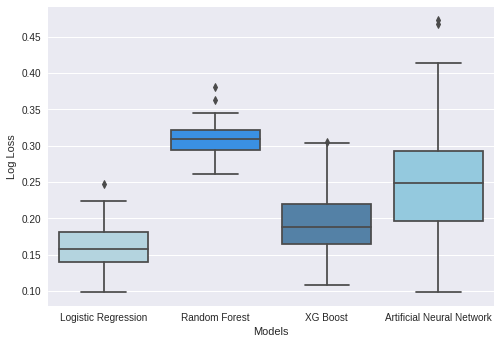

In [40]:
colors = ['#ADD8E6', '#1E90FF', '#4682B4', '#87CEEB']
sns.boxplot(data=err, palette=colors)
plt.ylabel('Log Loss')
plt.xlabel('Models')
plt.show()

In [41]:
lr_l= []
rf_l= []
xgb_l= []
ann_l= []
for i in range(150):
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state= i)
    
    lr_model = LogisticRegression(**grid_search_lr.best_params_)
    lr_model.fit(X_train, y_train)
    y_1= lr_model.predict_proba(X_test)[:,1]
    lr_auc= roc_auc_score(y_test, y_1, multi_class='auto')
    lr_l.append(lr_auc)
    
    rf_model= RandomForestClassifier(**grid_search_rf.best_params_)
    rf_model.fit(X_train, y_train)
    y_2= rf_model.predict_proba(X_test)[:,1]
    rf_auc= roc_auc_score(y_test, y_2, multi_class='auto')
    rf_l.append(rf_auc)
    
    xgb_model= XGBClassifier(**grid_search_xgb.best_params_)
    xgb_model.fit(X_train, y_train)
    y_3= xgb_model.predict_proba(X_test)[:,1]
    xgb_auc= roc_auc_score(y_test, y_3, multi_class='auto')
    xgb_l.append(xgb_auc)
    
    ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    ann.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    history = ann.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      validation_split=0.2)
    y_4 = ann.predict(X_test)
    ann_auc= roc_auc_score(y_test, y_4, multi_class='auto')
    ann_l.append(ann_auc)

Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6418 - precision_151: 0.3333 - recall_151: 0.0308 - val_loss: 0.6295 - val_precision_151: 0.0000e+00 - val_recall_151: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5582 - precision_151: 1.0000 - recall_151: 0.0837 - val_loss: 0.5746 - val_precision_151: 0.9286 - val_recall_151: 0.1912
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4858 - precision_151: 0.9529 - recall_151: 0.3568 - val_loss: 0.5190 - val_precision_151: 0.9310 - val_recall_151: 0.3971
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4172 - precision_151: 0.8836 - recall_151: 0.5683 - val_loss: 0.4519 - val_precision_151: 0.9130 - val_recall_151: 0.6176
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3470 - precision_151: 0.8743 - recall_151: 0.7357 - val_loss: 0.3792 - val_precision_151: 0.9123 - val_recall_151: 0.7647
Epoch 6/50
2

20/20 [==============================] - 0s 2ms/step - loss: 0.0442 - precision_152: 0.9669 - recall_152: 1.0000 - val_loss: 0.1370 - val_precision_152: 0.9730 - val_recall_152: 0.9114
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0415 - precision_152: 0.9710 - recall_152: 1.0000 - val_loss: 0.1283 - val_precision_152: 0.9733 - val_recall_152: 0.9241
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0397 - precision_152: 0.9750 - recall_152: 1.0000 - val_loss: 0.1353 - val_precision_152: 0.9730 - val_recall_152: 0.9114
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0392 - precision_152: 0.9710 - recall_152: 1.0000 - val_loss: 0.1364 - val_precision_152: 0.9722 - val_recall_152: 0.8861
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0369 - precision_152: 0.9710 - recall_152: 1.0000 - val_loss: 0.1402 - val_precision_152: 0.9730 - val_recall_152: 0.9114
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0987 - precision_154: 0.9344 - recall_154: 0.9918 - val_loss: 0.1640 - val_precision_154: 0.8806 - val_recall_154: 0.9365
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0926 - precision_154: 0.9346 - recall_154: 0.9959 - val_loss: 0.1652 - val_precision_154: 0.8806 - val_recall_154: 0.9365
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0889 - precision_154: 0.9382 - recall_154: 0.9959 - val_loss: 0.1680 - val_precision_154: 0.8806 - val_recall_154: 0.9365
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0856 - precision_154: 0.9382 - recall_154: 0.9959 - val_loss: 0.1715 - val_precision_154: 0.8806 - val_recall_154: 0.9365
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0821 - precision_154: 0.9349 - recall_154: 1.0000 - val_loss: 0.1742 - val_precision_154: 0.8806 - val_recall_154: 0.9365
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0180 - precision_155: 0.9878 - recall_155: 1.0000 - val_loss: 0.2096 - val_precision_155: 0.9355 - val_recall_155: 0.9508
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0170 - precision_155: 0.9918 - recall_155: 1.0000 - val_loss: 0.2142 - val_precision_155: 0.9355 - val_recall_155: 0.9508
Epoch 50/50
7/7 [==============================] - 0s 692us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6720 - precision_156: 0.5068 - recall_156: 0.5920 - val_loss: 0.6203 - val_precision_156: 0.8571 - val_recall_156: 0.4286
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5831 - precision_156: 0.8255 - recall_156: 0.4920 - val_loss: 0.5477 - val_precision_156: 0.8485 - val_recall_156: 0.5000
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5083 - precision_156: 0.8272 - recall_156: 0.6320 - val_loss: 0.4810 - val_

20/20 [==============================] - 0s 2ms/step - loss: 0.0513 - precision_157: 0.9636 - recall_157: 1.0000 - val_loss: 0.1479 - val_precision_157: 0.9194 - val_recall_157: 0.9344
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0494 - precision_157: 0.9636 - recall_157: 1.0000 - val_loss: 0.1562 - val_precision_157: 0.9167 - val_recall_157: 0.9016
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0466 - precision_157: 0.9675 - recall_157: 1.0000 - val_loss: 0.1423 - val_precision_157: 0.9206 - val_recall_157: 0.9508
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0445 - precision_157: 0.9714 - recall_157: 1.0000 - val_loss: 0.1469 - val_precision_157: 0.9180 - val_recall_157: 0.9180
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0420 - precision_157: 0.9675 - recall_157: 1.0000 - val_loss: 0.1451 - val_precision_157: 0.9206 - val_recall_157: 0.9508
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0836 - precision_159: 0.9400 - recall_159: 0.9958 - val_loss: 0.2200 - val_precision_159: 0.9310 - val_recall_159: 0.8710
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0775 - precision_159: 0.9440 - recall_159: 1.0000 - val_loss: 0.2248 - val_precision_159: 0.9298 - val_recall_159: 0.8548
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0726 - precision_159: 0.9516 - recall_159: 1.0000 - val_loss: 0.2307 - val_precision_159: 0.9298 - val_recall_159: 0.8548
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0690 - precision_159: 0.9593 - recall_159: 1.0000 - val_loss: 0.2409 - val_precision_159: 0.9138 - val_recall_159: 0.8548
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0638 - precision_159: 0.9516 - recall_159: 1.0000 - val_loss: 0.2424 - val_precision_159: 0.9138 - val_recall_159: 0.8548
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0173 - precision_160: 0.9919 - recall_160: 1.0000 - val_loss: 0.2461 - val_precision_160: 0.8750 - val_recall_160: 0.9032
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0171 - precision_160: 0.9879 - recall_160: 1.0000 - val_loss: 0.2509 - val_precision_160: 0.8750 - val_recall_160: 0.9032
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0167 - precision_160: 0.9919 - recall_160: 1.0000 - val_loss: 0.2563 - val_precision_160: 0.8750 - val_recall_160: 0.9032
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0145 - precision_160: 0.9959 - recall_160: 1.0000 - val_loss: 0.2621 - val_precision_160: 0.8750 - val_recall_160: 0.9032
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0132 - precision_160: 0.9959 - recall_160: 1.0000 - val_loss: 0.2709 - val_precision_160: 0.8750 - val_recall_160: 0.9032
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0479 - precision_162: 0.9711 - recall_162: 0.9958 - val_loss: 0.2469 - val_precision_162: 0.8800 - val_recall_162: 0.9565
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0451 - precision_162: 0.9792 - recall_162: 0.9958 - val_loss: 0.2520 - val_precision_162: 0.8800 - val_recall_162: 0.9565
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0420 - precision_162: 0.9712 - recall_162: 1.0000 - val_loss: 0.2561 - val_precision_162: 0.8800 - val_recall_162: 0.9565
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0403 - precision_162: 0.9712 - recall_162: 1.0000 - val_loss: 0.2655 - val_precision_162: 0.8800 - val_recall_162: 0.9565
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0370 - precision_162: 0.9793 - recall_162: 1.0000 - val_loss: 0.2642 - val_precision_162: 0.8800 - val_recall_162: 0.9565
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1462 - precision_164: 0.9023 - recall_164: 0.9747 - val_loss: 0.0986 - val_precision_164: 0.9545 - val_recall_164: 0.9844
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1330 - precision_164: 0.9163 - recall_164: 0.9705 - val_loss: 0.0958 - val_precision_164: 0.9545 - val_recall_164: 0.9844
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1256 - precision_164: 0.8958 - recall_164: 0.9789 - val_loss: 0.0898 - val_precision_164: 0.9538 - val_recall_164: 0.9688
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1163 - precision_164: 0.9280 - recall_164: 0.9789 - val_loss: 0.0911 - val_precision_164: 0.9538 - val_recall_164: 0.9688
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1113 - precision_164: 0.9144 - recall_164: 0.9916 - val_loss: 0.0875 - val_precision_164: 0.9545 - val_recall_164: 0.9844
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 599us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6404 - precision_165: 0.5562 - recall_165: 0.3886 - val_loss: 0.5992 - val_precision_165: 0.8182 - val_recall_165: 0.2903
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5598 - precision_165: 0.9298 - recall_165: 0.2314 - val_loss: 0.5344 - val_precision_165: 0.8889 - val_recall_165: 0.3871
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4913 - precision_165: 0.8718 - recall_165: 0.4454 - val_loss: 0.4680 - val_precision_165: 0.8780 - val_recall_165: 0.5806
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4210 - precision_165: 0.8588 - recall_165: 0.6376 - val_loss: 0.4047 - val_precision_165: 0.8936 - val_recall_165: 0.6774
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3517 - precision_165: 0.8605 - recall_165: 0.8079 - val_loss: 0.3389 - val_precision_165:

20/20 [==============================] - 0s 2ms/step - loss: 0.0414 - precision_166: 0.9767 - recall_166: 0.9960 - val_loss: 0.2012 - val_precision_166: 0.8621 - val_recall_166: 0.9615
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0409 - precision_166: 0.9767 - recall_166: 0.9960 - val_loss: 0.2055 - val_precision_166: 0.8621 - val_recall_166: 0.9615
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0388 - precision_166: 0.9804 - recall_166: 0.9921 - val_loss: 0.2041 - val_precision_166: 0.8621 - val_recall_166: 0.9615
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0380 - precision_166: 0.9691 - recall_166: 0.9960 - val_loss: 0.2087 - val_precision_166: 0.8621 - val_recall_166: 0.9615
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0364 - precision_166: 0.9843 - recall_166: 0.9921 - val_loss: 0.2048 - val_precision_166: 0.8621 - val_recall_166: 0.9615
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0943 - precision_168: 0.9328 - recall_168: 0.9916 - val_loss: 0.1664 - val_precision_168: 0.9032 - val_recall_168: 0.9492
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0897 - precision_168: 0.9400 - recall_168: 0.9874 - val_loss: 0.1678 - val_precision_168: 0.9032 - val_recall_168: 0.9492
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0850 - precision_168: 0.9331 - recall_168: 0.9958 - val_loss: 0.1673 - val_precision_168: 0.9032 - val_recall_168: 0.9492
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0801 - precision_168: 0.9480 - recall_168: 0.9958 - val_loss: 0.1722 - val_precision_168: 0.9016 - val_recall_168: 0.9322
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0763 - precision_168: 0.9444 - recall_168: 1.0000 - val_loss: 0.1700 - val_precision_168: 0.9032 - val_recall_168: 0.9492
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0177 - precision_169: 0.9916 - recall_169: 1.0000 - val_loss: 0.3334 - val_precision_169: 0.8545 - val_recall_169: 0.8393
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0165 - precision_169: 0.9916 - recall_169: 1.0000 - val_loss: 0.3371 - val_precision_169: 0.8571 - val_recall_169: 0.8571
Epoch 50/50
7/7 [==============================] - 0s 652us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6361 - precision_170: 0.6094 - recall_170: 0.1618 - val_loss: 0.5847 - val_precision_170: 0.8889 - val_recall_170: 0.1538
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5651 - precision_170: 0.8919 - recall_170: 0.2739 - val_loss: 0.5178 - val_precision_170: 0.7500 - val_recall_170: 0.3462
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5028 - precision_170: 0.8582 - recall_170: 0.5021 - val_loss: 0.4586 - val_

20/20 [==============================] - 0s 2ms/step - loss: 0.0369 - precision_171: 0.9874 - recall_171: 0.9958 - val_loss: 0.1594 - val_precision_171: 0.9661 - val_recall_171: 0.9344
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0341 - precision_171: 0.9793 - recall_171: 1.0000 - val_loss: 0.1590 - val_precision_171: 0.9500 - val_recall_171: 0.9344
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0320 - precision_171: 0.9793 - recall_171: 0.9958 - val_loss: 0.1632 - val_precision_171: 0.9655 - val_recall_171: 0.9180
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0306 - precision_171: 0.9833 - recall_171: 0.9958 - val_loss: 0.1684 - val_precision_171: 0.9492 - val_recall_171: 0.9180
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0287 - precision_171: 0.9916 - recall_171: 0.9958 - val_loss: 0.1703 - val_precision_171: 0.9492 - val_recall_171: 0.9180
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0986 - precision_173: 0.9352 - recall_173: 0.9914 - val_loss: 0.1513 - val_precision_173: 0.8923 - val_recall_173: 0.9667
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0922 - precision_173: 0.9390 - recall_173: 0.9914 - val_loss: 0.1509 - val_precision_173: 0.8906 - val_recall_173: 0.9500
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0870 - precision_173: 0.9431 - recall_173: 0.9957 - val_loss: 0.1506 - val_precision_173: 0.8906 - val_recall_173: 0.9500
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0830 - precision_173: 0.9469 - recall_173: 0.9957 - val_loss: 0.1505 - val_precision_173: 0.8906 - val_recall_173: 0.9500
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0794 - precision_173: 0.9467 - recall_173: 0.9914 - val_loss: 0.1513 - val_precision_173: 0.8906 - val_recall_173: 0.9500
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0198 - precision_174: 0.9874 - recall_174: 1.0000 - val_loss: 0.1297 - val_precision_174: 0.9194 - val_recall_174: 0.9661
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0192 - precision_174: 0.9874 - recall_174: 1.0000 - val_loss: 0.1331 - val_precision_174: 0.9194 - val_recall_174: 0.9661
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0180 - precision_174: 0.9874 - recall_174: 1.0000 - val_loss: 0.1321 - val_precision_174: 0.9194 - val_recall_174: 0.9661
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0171 - precision_174: 0.9916 - recall_174: 1.0000 - val_loss: 0.1345 - val_precision_174: 0.9194 - val_recall_174: 0.9661
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0161 - precision_174: 0.9916 - recall_174: 1.0000 - val_loss: 0.1364 - val_precision_174: 0.9194 - val_recall_174: 0.9661
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0694 - precision_176: 0.9504 - recall_176: 0.9960 - val_loss: 0.1843 - val_precision_176: 0.9091 - val_recall_176: 0.9434
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0662 - precision_176: 0.9579 - recall_176: 1.0000 - val_loss: 0.1859 - val_precision_176: 0.9091 - val_recall_176: 0.9434
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0644 - precision_176: 0.9506 - recall_176: 1.0000 - val_loss: 0.1853 - val_precision_176: 0.9091 - val_recall_176: 0.9434
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0608 - precision_176: 0.9542 - recall_176: 1.0000 - val_loss: 0.1893 - val_precision_176: 0.9091 - val_recall_176: 0.9434
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0588 - precision_176: 0.9690 - recall_176: 1.0000 - val_loss: 0.1883 - val_precision_176: 0.9259 - val_recall_176: 0.9434
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1354 - precision_178: 0.9170 - recall_178: 0.9831 - val_loss: 0.1509 - val_precision_178: 0.9104 - val_recall_178: 0.9839
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1206 - precision_178: 0.9180 - recall_178: 0.9958 - val_loss: 0.1449 - val_precision_178: 0.9242 - val_recall_178: 0.9839
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1102 - precision_178: 0.9289 - recall_178: 0.9958 - val_loss: 0.1415 - val_precision_178: 0.9242 - val_recall_178: 0.9839
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1030 - precision_178: 0.9289 - recall_178: 0.9958 - val_loss: 0.1382 - val_precision_178: 0.9242 - val_recall_178: 0.9839
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0985 - precision_178: 0.9289 - recall_178: 0.9958 - val_loss: 0.1384 - val_precision_178: 0.9242 - val_recall_178: 0.9839
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 629us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6771 - precision_179: 0.4499 - recall_179: 0.8821 - val_loss: 0.6338 - val_precision_179: 0.7419 - val_recall_179: 0.6571
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5879 - precision_179: 0.7759 - recall_179: 0.5895 - val_loss: 0.5739 - val_precision_179: 0.8723 - val_recall_179: 0.5857
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5105 - precision_179: 0.8000 - recall_179: 0.6288 - val_loss: 0.5026 - val_precision_179: 0.8519 - val_recall_179: 0.6571
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4282 - precision_179: 0.8316 - recall_179: 0.7118 - val_loss: 0.4325 - val_precision_179: 0.8929 - val_recall_179: 0.7143
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3500 - precision_179: 0.8597 - recall_179: 0.8297 - val_loss: 0.3597 - val_precision_179:

20/20 [==============================] - 0s 2ms/step - loss: 0.0430 - precision_180: 0.9711 - recall_180: 1.0000 - val_loss: 0.1650 - val_precision_180: 0.8571 - val_recall_180: 0.9310
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0408 - precision_180: 0.9711 - recall_180: 1.0000 - val_loss: 0.1661 - val_precision_180: 0.8571 - val_recall_180: 0.9310
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0390 - precision_180: 0.9751 - recall_180: 1.0000 - val_loss: 0.1694 - val_precision_180: 0.8571 - val_recall_180: 0.9310
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0365 - precision_180: 0.9711 - recall_180: 1.0000 - val_loss: 0.1700 - val_precision_180: 0.8548 - val_recall_180: 0.9138
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0353 - precision_180: 0.9711 - recall_180: 1.0000 - val_loss: 0.1707 - val_precision_180: 0.8571 - val_recall_180: 0.9310
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0921 - precision_182: 0.9305 - recall_182: 0.9959 - val_loss: 0.1479 - val_precision_182: 0.8955 - val_recall_182: 0.9677
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0872 - precision_182: 0.9377 - recall_182: 0.9959 - val_loss: 0.1526 - val_precision_182: 0.8939 - val_recall_182: 0.9516
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0836 - precision_182: 0.9414 - recall_182: 0.9959 - val_loss: 0.1536 - val_precision_182: 0.9077 - val_recall_182: 0.9516
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0802 - precision_182: 0.9488 - recall_182: 0.9959 - val_loss: 0.1537 - val_precision_182: 0.9077 - val_recall_182: 0.9516
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0766 - precision_182: 0.9451 - recall_182: 0.9959 - val_loss: 0.1595 - val_precision_182: 0.8939 - val_recall_182: 0.9516
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0198 - precision_183: 0.9871 - recall_183: 1.0000 - val_loss: 0.3760 - val_precision_183: 0.8689 - val_recall_183: 0.8689
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0178 - precision_183: 0.9914 - recall_183: 1.0000 - val_loss: 0.3769 - val_precision_183: 0.8689 - val_recall_183: 0.8689
Epoch 50/50
7/7 [==============================] - 0s 636us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6617 - precision_184: 0.2093 - recall_184: 0.0366 - val_loss: 0.5989 - val_precision_184: 0.0000e+00 - val_recall_184: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5917 - precision_184: 0.0000e+00 - recall_184: 0.0000e+00 - val_loss: 0.5301 - val_precision_184: 0.0000e+00 - val_recall_184: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5405 - precision_184: 1.0000 - recall_184: 0.0569 -

20/20 [==============================] - 0s 2ms/step - loss: 0.0720 - precision_185: 0.9553 - recall_185: 1.0000 - val_loss: 0.1513 - val_precision_185: 0.9206 - val_recall_185: 0.9355
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0700 - precision_185: 0.9631 - recall_185: 1.0000 - val_loss: 0.1489 - val_precision_185: 0.9206 - val_recall_185: 0.9355
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0673 - precision_185: 0.9553 - recall_185: 1.0000 - val_loss: 0.1536 - val_precision_185: 0.9206 - val_recall_185: 0.9355
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0646 - precision_185: 0.9631 - recall_185: 1.0000 - val_loss: 0.1540 - val_precision_185: 0.9206 - val_recall_185: 0.9355
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0624 - precision_185: 0.9631 - recall_185: 1.0000 - val_loss: 0.1567 - val_precision_185: 0.9206 - val_recall_185: 0.9355
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1167 - precision_187: 0.9272 - recall_187: 0.9837 - val_loss: 0.1159 - val_precision_187: 0.9385 - val_recall_187: 0.9839
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1089 - precision_187: 0.9272 - recall_187: 0.9837 - val_loss: 0.1128 - val_precision_187: 0.9385 - val_recall_187: 0.9839
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1022 - precision_187: 0.9310 - recall_187: 0.9878 - val_loss: 0.1117 - val_precision_187: 0.9385 - val_recall_187: 0.9839
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0966 - precision_187: 0.9349 - recall_187: 0.9919 - val_loss: 0.1104 - val_precision_187: 0.9385 - val_recall_187: 0.9839
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0916 - precision_187: 0.9280 - recall_187: 0.9959 - val_loss: 0.1089 - val_precision_187: 0.9385 - val_recall_187: 0.9839
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0198 - precision_188: 0.9872 - recall_188: 1.0000 - val_loss: 0.2545 - val_precision_188: 0.9273 - val_recall_188: 0.9107
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0186 - precision_188: 0.9957 - recall_188: 0.9957 - val_loss: 0.2598 - val_precision_188: 0.9259 - val_recall_188: 0.8929
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0181 - precision_188: 0.9957 - recall_188: 0.9957 - val_loss: 0.2603 - val_precision_188: 0.9273 - val_recall_188: 0.9107
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0164 - precision_188: 0.9957 - recall_188: 0.9957 - val_loss: 0.2680 - val_precision_188: 0.9273 - val_recall_188: 0.9107
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0150 - precision_188: 0.9957 - recall_188: 1.0000 - val_loss: 0.2718 - val_precision_188: 0.9273 - val_recall_188: 0.9107
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0615 - precision_190: 0.9536 - recall_190: 0.9956 - val_loss: 0.1229 - val_precision_190: 0.9697 - val_recall_190: 0.9412
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0588 - precision_190: 0.9417 - recall_190: 0.9956 - val_loss: 0.1327 - val_precision_190: 0.9545 - val_recall_190: 0.9265
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0555 - precision_190: 0.9576 - recall_190: 0.9956 - val_loss: 0.1342 - val_precision_190: 0.9692 - val_recall_190: 0.9265
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0545 - precision_190: 0.9536 - recall_190: 0.9956 - val_loss: 0.1274 - val_precision_190: 0.9697 - val_recall_190: 0.9412
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0514 - precision_190: 0.9417 - recall_190: 0.9956 - val_loss: 0.1370 - val_precision_190: 0.9552 - val_recall_190: 0.9412
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1601 - precision_192: 0.9208 - recall_192: 0.9567 - val_loss: 0.1795 - val_precision_192: 0.9375 - val_recall_192: 0.9231
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1423 - precision_192: 0.9221 - recall_192: 0.9740 - val_loss: 0.1705 - val_precision_192: 0.9254 - val_recall_192: 0.9538
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1301 - precision_192: 0.9184 - recall_192: 0.9740 - val_loss: 0.1637 - val_precision_192: 0.9254 - val_recall_192: 0.9538
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1214 - precision_192: 0.9221 - recall_192: 0.9740 - val_loss: 0.1654 - val_precision_192: 0.9254 - val_recall_192: 0.9538
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1136 - precision_192: 0.9228 - recall_192: 0.9827 - val_loss: 0.1619 - val_precision_192: 0.9118 - val_recall_192: 0.9538
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 599us/step
Epoch 1/50
20/20 [==============================] - 1s 7ms/step - loss: 0.6884 - precision_193: 0.4442 - recall_193: 0.7202 - val_loss: 0.6425 - val_precision_193: 0.7419 - val_recall_193: 0.3770
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6055 - precision_193: 0.8764 - recall_193: 0.3210 - val_loss: 0.5810 - val_precision_193: 0.9000 - val_recall_193: 0.4426
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5401 - precision_193: 0.9083 - recall_193: 0.4074 - val_loss: 0.5251 - val_precision_193: 0.7907 - val_recall_193: 0.5574
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4676 - precision_193: 0.9236 - recall_193: 0.5967 - val_loss: 0.4641 - val_precision_193: 0.7925 - val_recall_193: 0.6885
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3872 - precision_193: 0.8940 - recall_193: 0.7984 - val_loss: 0.4039 - val_precision_193:

20/20 [==============================] - 0s 2ms/step - loss: 0.0433 - precision_194: 0.9665 - recall_194: 0.9957 - val_loss: 0.1354 - val_precision_194: 0.9206 - val_recall_194: 0.9667
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0386 - precision_194: 0.9788 - recall_194: 0.9957 - val_loss: 0.1408 - val_precision_194: 0.9206 - val_recall_194: 0.9667
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0372 - precision_194: 0.9788 - recall_194: 0.9957 - val_loss: 0.1416 - val_precision_194: 0.9206 - val_recall_194: 0.9667
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0375 - precision_194: 0.9707 - recall_194: 1.0000 - val_loss: 0.1396 - val_precision_194: 0.9206 - val_recall_194: 0.9667
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0346 - precision_194: 0.9787 - recall_194: 0.9914 - val_loss: 0.1429 - val_precision_194: 0.9206 - val_recall_194: 0.9667
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0957 - precision_196: 0.9378 - recall_196: 0.9869 - val_loss: 0.1765 - val_precision_196: 0.9054 - val_recall_196: 0.9710
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0914 - precision_196: 0.9417 - recall_196: 0.9869 - val_loss: 0.1783 - val_precision_196: 0.9054 - val_recall_196: 0.9710
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0877 - precision_196: 0.9380 - recall_196: 0.9913 - val_loss: 0.1797 - val_precision_196: 0.9054 - val_recall_196: 0.9710
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0846 - precision_196: 0.9496 - recall_196: 0.9869 - val_loss: 0.1793 - val_precision_196: 0.8933 - val_recall_196: 0.9710
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0811 - precision_196: 0.9380 - recall_196: 0.9913 - val_loss: 0.1812 - val_precision_196: 0.8933 - val_recall_196: 0.9710
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0100 - precision_197: 1.0000 - recall_197: 1.0000 - val_loss: 0.3025 - val_precision_197: 0.8654 - val_recall_197: 0.8654
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0095 - precision_197: 1.0000 - recall_197: 1.0000 - val_loss: 0.3068 - val_precision_197: 0.8654 - val_recall_197: 0.8654
Epoch 50/50
7/7 [==============================] - 0s 661us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6828 - precision_198: 0.3288 - recall_198: 0.1967 - val_loss: 0.6506 - val_precision_198: 0.0000e+00 - val_recall_198: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6085 - precision_198: 1.0000 - recall_198: 0.0943 - val_loss: 0.5987 - val_precision_198: 1.0000 - val_recall_198: 0.0909
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5468 - precision_198: 1.0000 - recall_198: 0.2254 - val_loss: 0.543

20/20 [==============================] - 0s 2ms/step - loss: 0.0487 - precision_199: 0.9672 - recall_199: 1.0000 - val_loss: 0.1995 - val_precision_199: 0.8772 - val_recall_199: 0.9259
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0485 - precision_199: 0.9633 - recall_199: 1.0000 - val_loss: 0.2013 - val_precision_199: 0.8772 - val_recall_199: 0.9259
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0463 - precision_199: 0.9672 - recall_199: 1.0000 - val_loss: 0.2045 - val_precision_199: 0.8772 - val_recall_199: 0.9259
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0458 - precision_199: 0.9633 - recall_199: 1.0000 - val_loss: 0.2073 - val_precision_199: 0.8772 - val_recall_199: 0.9259
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0425 - precision_199: 0.9672 - recall_199: 1.0000 - val_loss: 0.2128 - val_precision_199: 0.8772 - val_recall_199: 0.9259
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1130 - precision_201: 0.9306 - recall_201: 0.9828 - val_loss: 0.1653 - val_precision_201: 0.8611 - val_recall_201: 1.0000
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1040 - precision_201: 0.9277 - recall_201: 0.9957 - val_loss: 0.1690 - val_precision_201: 0.8611 - val_recall_201: 1.0000
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0969 - precision_201: 0.9352 - recall_201: 0.9957 - val_loss: 0.1709 - val_precision_201: 0.8611 - val_recall_201: 1.0000
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0899 - precision_201: 0.9315 - recall_201: 0.9957 - val_loss: 0.1771 - val_precision_201: 0.8611 - val_recall_201: 1.0000
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0860 - precision_201: 0.9315 - recall_201: 0.9957 - val_loss: 0.1858 - val_precision_201: 0.8493 - val_recall_201: 1.0000
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0252 - precision_202: 0.9839 - recall_202: 1.0000 - val_loss: 0.2108 - val_precision_202: 0.9032 - val_recall_202: 0.9032
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0246 - precision_202: 0.9839 - recall_202: 1.0000 - val_loss: 0.2121 - val_precision_202: 0.9032 - val_recall_202: 0.9032
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0227 - precision_202: 0.9879 - recall_202: 1.0000 - val_loss: 0.2152 - val_precision_202: 0.9032 - val_recall_202: 0.9032
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0220 - precision_202: 0.9879 - recall_202: 1.0000 - val_loss: 0.2178 - val_precision_202: 0.9032 - val_recall_202: 0.9032
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0210 - precision_202: 0.9879 - recall_202: 1.0000 - val_loss: 0.2179 - val_precision_202: 0.9032 - val_recall_202: 0.9032
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0537 - precision_204: 0.9755 - recall_204: 0.9958 - val_loss: 0.2158 - val_precision_204: 0.9259 - val_recall_204: 0.9091
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0509 - precision_204: 0.9637 - recall_204: 0.9958 - val_loss: 0.2203 - val_precision_204: 0.9259 - val_recall_204: 0.9091
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0479 - precision_204: 0.9715 - recall_204: 0.9958 - val_loss: 0.2291 - val_precision_204: 0.9245 - val_recall_204: 0.8909
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0469 - precision_204: 0.9715 - recall_204: 0.9958 - val_loss: 0.2275 - val_precision_204: 0.9259 - val_recall_204: 0.9091
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0447 - precision_204: 0.9717 - recall_204: 1.0000 - val_loss: 0.2316 - val_precision_204: 0.9231 - val_recall_204: 0.8727
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1424 - precision_206: 0.9211 - recall_206: 0.9800 - val_loss: 0.1472 - val_precision_206: 0.8800 - val_recall_206: 0.8980
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1283 - precision_206: 0.9208 - recall_206: 0.9760 - val_loss: 0.1424 - val_precision_206: 0.8980 - val_recall_206: 0.8980
Epoch 11/50
20/20 [==============================] - 0s 1ms/step - loss: 0.1200 - precision_206: 0.9308 - recall_206: 0.9680 - val_loss: 0.1421 - val_precision_206: 0.8800 - val_recall_206: 0.8980
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1132 - precision_206: 0.9280 - recall_206: 0.9800 - val_loss: 0.1406 - val_precision_206: 0.8800 - val_recall_206: 0.8980
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1085 - precision_206: 0.9288 - recall_206: 0.9920 - val_loss: 0.1388 - val_precision_206: 0.8800 - val_recall_206: 0.8980
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 546us/step
Epoch 1/50
20/20 [==============================] - 1s 9ms/step - loss: 0.7080 - precision_207: 0.4274 - recall_207: 0.8566 - val_loss: 0.6717 - val_precision_207: 0.5286 - val_recall_207: 0.6981
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6435 - precision_207: 0.7766 - recall_207: 0.6096 - val_loss: 0.6105 - val_precision_207: 0.9167 - val_recall_207: 0.6226
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5799 - precision_207: 0.9034 - recall_207: 0.6335 - val_loss: 0.5415 - val_precision_207: 0.8889 - val_recall_207: 0.7547
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4989 - precision_207: 0.8945 - recall_207: 0.7769 - val_loss: 0.4520 - val_precision_207: 0.9167 - val_recall_207: 0.8302
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4012 - precision_207: 0.8963 - recall_207: 0.8606 - val_loss: 0.3525 - val_precision_207:

20/20 [==============================] - 0s 2ms/step - loss: 0.0411 - precision_208: 0.9834 - recall_208: 0.9958 - val_loss: 0.2247 - val_precision_208: 0.8814 - val_recall_208: 0.9123
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0393 - precision_208: 0.9835 - recall_208: 1.0000 - val_loss: 0.2248 - val_precision_208: 0.8833 - val_recall_208: 0.9298
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0373 - precision_208: 0.9876 - recall_208: 1.0000 - val_loss: 0.2352 - val_precision_208: 0.8814 - val_recall_208: 0.9123
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0352 - precision_208: 0.9876 - recall_208: 1.0000 - val_loss: 0.2337 - val_precision_208: 0.8833 - val_recall_208: 0.9298
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0336 - precision_208: 0.9876 - recall_208: 1.0000 - val_loss: 0.2372 - val_precision_208: 0.8814 - val_recall_208: 0.9123
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0857 - precision_210: 0.9468 - recall_210: 0.9881 - val_loss: 0.1600 - val_precision_210: 0.8542 - val_recall_210: 0.9111
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0805 - precision_210: 0.9472 - recall_210: 0.9960 - val_loss: 0.1621 - val_precision_210: 0.8571 - val_recall_210: 0.9333
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0779 - precision_210: 0.9472 - recall_210: 0.9960 - val_loss: 0.1617 - val_precision_210: 0.8571 - val_recall_210: 0.9333
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0734 - precision_210: 0.9472 - recall_210: 0.9960 - val_loss: 0.1637 - val_precision_210: 0.8542 - val_recall_210: 0.9111
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0709 - precision_210: 0.9472 - recall_210: 0.9960 - val_loss: 0.1680 - val_precision_210: 0.8542 - val_recall_210: 0.9111
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0201 - precision_211: 0.9870 - recall_211: 1.0000 - val_loss: 0.2322 - val_precision_211: 0.9000 - val_recall_211: 0.9000
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0193 - precision_211: 0.9870 - recall_211: 1.0000 - val_loss: 0.2375 - val_precision_211: 0.9000 - val_recall_211: 0.9000
Epoch 50/50
7/7 [==============================] - 0s 628us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6376 - precision_212: 0.5385 - recall_212: 0.0288 - val_loss: 0.6149 - val_precision_212: 0.0000e+00 - val_recall_212: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5647 - precision_212: 0.0000e+00 - recall_212: 0.0000e+00 - val_loss: 0.5651 - val_precision_212: 0.0000e+00 - val_recall_212: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5027 - precision_212: 0.9556 - recall_212: 0.1770 -

20/20 [==============================] - 0s 2ms/step - loss: 0.0436 - precision_213: 0.9794 - recall_213: 0.9958 - val_loss: 0.2204 - val_precision_213: 0.8750 - val_recall_213: 0.9423
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0413 - precision_213: 0.9637 - recall_213: 1.0000 - val_loss: 0.2231 - val_precision_213: 0.8750 - val_recall_213: 0.9423
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0395 - precision_213: 0.9676 - recall_213: 1.0000 - val_loss: 0.2294 - val_precision_213: 0.8750 - val_recall_213: 0.9423
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0355 - precision_213: 0.9676 - recall_213: 1.0000 - val_loss: 0.2322 - val_precision_213: 0.8750 - val_recall_213: 0.9423
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0339 - precision_213: 0.9676 - recall_213: 1.0000 - val_loss: 0.2391 - val_precision_213: 0.8750 - val_recall_213: 0.9423
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1046 - precision_215: 0.9286 - recall_215: 0.9915 - val_loss: 0.1581 - val_precision_215: 0.9153 - val_recall_215: 0.9474
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0986 - precision_215: 0.9323 - recall_215: 0.9915 - val_loss: 0.1642 - val_precision_215: 0.9123 - val_recall_215: 0.9123
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0933 - precision_215: 0.9360 - recall_215: 0.9915 - val_loss: 0.1666 - val_precision_215: 0.9123 - val_recall_215: 0.9123
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0887 - precision_215: 0.9328 - recall_215: 1.0000 - val_loss: 0.1624 - val_precision_215: 0.9123 - val_recall_215: 0.9123
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0843 - precision_215: 0.9402 - recall_215: 1.0000 - val_loss: 0.1687 - val_precision_215: 0.9123 - val_recall_215: 0.9123
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0113 - precision_216: 1.0000 - recall_216: 1.0000 - val_loss: 0.3879 - val_precision_216: 0.8644 - val_recall_216: 0.8947
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0107 - precision_216: 1.0000 - recall_216: 1.0000 - val_loss: 0.3972 - val_precision_216: 0.8644 - val_recall_216: 0.8947
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0097 - precision_216: 1.0000 - recall_216: 1.0000 - val_loss: 0.4054 - val_precision_216: 0.8644 - val_recall_216: 0.8947
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0091 - precision_216: 1.0000 - recall_216: 1.0000 - val_loss: 0.4097 - val_precision_216: 0.8644 - val_recall_216: 0.8947
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0086 - precision_216: 1.0000 - recall_216: 1.0000 - val_loss: 0.4146 - val_precision_216: 0.8644 - val_recall_216: 0.8947
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0416 - precision_218: 0.9662 - recall_218: 1.0000 - val_loss: 0.3181 - val_precision_218: 0.9194 - val_recall_218: 0.8143
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0400 - precision_218: 0.9703 - recall_218: 1.0000 - val_loss: 0.3160 - val_precision_218: 0.9194 - val_recall_218: 0.8143
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0380 - precision_218: 0.9662 - recall_218: 1.0000 - val_loss: 0.3305 - val_precision_218: 0.9194 - val_recall_218: 0.8143
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0350 - precision_218: 0.9745 - recall_218: 1.0000 - val_loss: 0.3304 - val_precision_218: 0.9194 - val_recall_218: 0.8143
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0333 - precision_218: 0.9745 - recall_218: 1.0000 - val_loss: 0.3449 - val_precision_218: 0.9194 - val_recall_218: 0.8143
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1467 - precision_220: 0.8992 - recall_220: 0.9789 - val_loss: 0.1132 - val_precision_220: 0.9483 - val_recall_220: 1.0000
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1364 - precision_220: 0.9062 - recall_220: 0.9789 - val_loss: 0.1033 - val_precision_220: 0.9322 - val_recall_220: 1.0000
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1274 - precision_220: 0.9031 - recall_220: 0.9831 - val_loss: 0.0999 - val_precision_220: 0.9483 - val_recall_220: 1.0000
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1210 - precision_220: 0.9173 - recall_220: 0.9831 - val_loss: 0.0978 - val_precision_220: 0.9483 - val_recall_220: 1.0000
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1155 - precision_220: 0.9180 - recall_220: 0.9916 - val_loss: 0.0974 - val_precision_220: 0.9649 - val_recall_220: 1.0000
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 591us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6549 - precision_221: 0.3030 - recall_221: 0.0873 - val_loss: 0.6370 - val_precision_221: 1.0000 - val_recall_221: 0.0139
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5713 - precision_221: 0.9444 - recall_221: 0.0742 - val_loss: 0.5778 - val_precision_221: 1.0000 - val_recall_221: 0.2083
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4978 - precision_221: 0.9000 - recall_221: 0.3144 - val_loss: 0.5086 - val_precision_221: 0.9767 - val_recall_221: 0.5833
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4242 - precision_221: 0.8889 - recall_221: 0.6288 - val_loss: 0.4317 - val_precision_221: 0.9615 - val_recall_221: 0.6944
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3538 - precision_221: 0.8775 - recall_221: 0.7817 - val_loss: 0.3534 - val_precision_221:

20/20 [==============================] - 0s 2ms/step - loss: 0.0475 - precision_222: 0.9587 - recall_222: 0.9957 - val_loss: 0.0903 - val_precision_222: 0.9508 - val_recall_222: 0.9667
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0453 - precision_222: 0.9627 - recall_222: 0.9957 - val_loss: 0.0910 - val_precision_222: 0.9508 - val_recall_222: 0.9667
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0444 - precision_222: 0.9789 - recall_222: 0.9957 - val_loss: 0.0922 - val_precision_222: 0.9508 - val_recall_222: 0.9667
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0421 - precision_222: 0.9587 - recall_222: 0.9957 - val_loss: 0.0922 - val_precision_222: 0.9508 - val_recall_222: 0.9667
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0385 - precision_222: 0.9748 - recall_222: 0.9957 - val_loss: 0.0935 - val_precision_222: 0.9508 - val_recall_222: 0.9667
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1006 - precision_224: 0.9209 - recall_224: 0.9873 - val_loss: 0.1469 - val_precision_224: 0.9130 - val_recall_224: 0.9403
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0960 - precision_224: 0.9246 - recall_224: 0.9873 - val_loss: 0.1470 - val_precision_224: 0.9130 - val_recall_224: 0.9403
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0919 - precision_224: 0.9213 - recall_224: 0.9915 - val_loss: 0.1465 - val_precision_224: 0.9130 - val_recall_224: 0.9403
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0883 - precision_224: 0.9291 - recall_224: 1.0000 - val_loss: 0.1519 - val_precision_224: 0.9130 - val_recall_224: 0.9403
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0838 - precision_224: 0.9363 - recall_224: 0.9958 - val_loss: 0.1491 - val_precision_224: 0.9130 - val_recall_224: 0.9403
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0198 - precision_225: 0.9914 - recall_225: 1.0000 - val_loss: 0.2579 - val_precision_225: 0.8857 - val_recall_225: 0.9394
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0192 - precision_225: 0.9830 - recall_225: 1.0000 - val_loss: 0.2609 - val_precision_225: 0.8841 - val_recall_225: 0.9242
Epoch 50/50
7/7 [==============================] - 0s 599us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6760 - precision_226: 0.4829 - recall_226: 0.6870 - val_loss: 0.6285 - val_precision_226: 0.6939 - val_recall_226: 0.5763
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6034 - precision_226: 0.7576 - recall_226: 0.6098 - val_loss: 0.5635 - val_precision_226: 0.7556 - val_recall_226: 0.5763
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5370 - precision_226: 0.8029 - recall_226: 0.6789 - val_loss: 0.4964 - val_

20/20 [==============================] - 0s 2ms/step - loss: 0.0485 - precision_227: 0.9715 - recall_227: 1.0000 - val_loss: 0.2116 - val_precision_227: 0.8841 - val_recall_227: 0.9531
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0469 - precision_227: 0.9755 - recall_227: 1.0000 - val_loss: 0.2143 - val_precision_227: 0.8857 - val_recall_227: 0.9688
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0456 - precision_227: 0.9755 - recall_227: 1.0000 - val_loss: 0.2171 - val_precision_227: 0.8841 - val_recall_227: 0.9531
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0447 - precision_227: 0.9715 - recall_227: 1.0000 - val_loss: 0.2228 - val_precision_227: 0.8841 - val_recall_227: 0.9531
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0418 - precision_227: 0.9755 - recall_227: 1.0000 - val_loss: 0.2244 - val_precision_227: 0.8841 - val_recall_227: 0.9531
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1257 - precision_229: 0.9143 - recall_229: 0.9868 - val_loss: 0.1477 - val_precision_229: 0.9552 - val_recall_229: 0.9552
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1183 - precision_229: 0.9215 - recall_229: 0.9824 - val_loss: 0.1431 - val_precision_229: 0.9552 - val_recall_229: 0.9552
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1114 - precision_229: 0.9180 - recall_229: 0.9868 - val_loss: 0.1379 - val_precision_229: 0.9552 - val_recall_229: 0.9552
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1060 - precision_229: 0.9113 - recall_229: 0.9956 - val_loss: 0.1375 - val_precision_229: 0.9552 - val_recall_229: 0.9552
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1002 - precision_229: 0.9221 - recall_229: 0.9912 - val_loss: 0.1504 - val_precision_229: 0.9552 - val_recall_229: 0.9552
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0189 - precision_230: 0.9919 - recall_230: 1.0000 - val_loss: 0.2496 - val_precision_230: 0.8906 - val_recall_230: 0.9661
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0182 - precision_230: 0.9919 - recall_230: 1.0000 - val_loss: 0.2572 - val_precision_230: 0.8906 - val_recall_230: 0.9661
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0173 - precision_230: 0.9879 - recall_230: 1.0000 - val_loss: 0.2583 - val_precision_230: 0.9048 - val_recall_230: 0.9661
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0165 - precision_230: 0.9959 - recall_230: 0.9959 - val_loss: 0.2663 - val_precision_230: 0.9048 - val_recall_230: 0.9661
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0156 - precision_230: 0.9959 - recall_230: 0.9959 - val_loss: 0.2700 - val_precision_230: 0.9048 - val_recall_230: 0.9661
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0586 - precision_232: 0.9472 - recall_232: 1.0000 - val_loss: 0.2317 - val_precision_232: 0.8939 - val_recall_232: 0.9219
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0549 - precision_232: 0.9588 - recall_232: 1.0000 - val_loss: 0.2328 - val_precision_232: 0.8923 - val_recall_232: 0.9062
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0527 - precision_232: 0.9587 - recall_232: 0.9957 - val_loss: 0.2329 - val_precision_232: 0.8824 - val_recall_232: 0.9375
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0519 - precision_232: 0.9667 - recall_232: 0.9957 - val_loss: 0.2362 - val_precision_232: 0.8939 - val_recall_232: 0.9219
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0487 - precision_232: 0.9628 - recall_232: 1.0000 - val_loss: 0.2356 - val_precision_232: 0.9091 - val_recall_232: 0.9375
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1454 - precision_234: 0.9209 - recall_234: 0.9846 - val_loss: 0.1492 - val_precision_234: 0.9000 - val_recall_234: 0.9375
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1303 - precision_234: 0.9181 - recall_234: 0.9923 - val_loss: 0.1399 - val_precision_234: 0.9020 - val_recall_234: 0.9583
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1207 - precision_234: 0.9247 - recall_234: 0.9923 - val_loss: 0.1339 - val_precision_234: 0.9020 - val_recall_234: 0.9583
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1145 - precision_234: 0.9382 - recall_234: 0.9923 - val_loss: 0.1318 - val_precision_234: 0.9020 - val_recall_234: 0.9583
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1086 - precision_234: 0.9384 - recall_234: 0.9962 - val_loss: 0.1308 - val_precision_234: 0.9020 - val_recall_234: 0.9583
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 660us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6707 - precision_235: 0.4686 - recall_235: 0.4609 - val_loss: 0.6240 - val_precision_235: 0.7059 - val_recall_235: 0.2069
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5816 - precision_235: 0.8600 - recall_235: 0.3539 - val_loss: 0.5595 - val_precision_235: 0.8261 - val_recall_235: 0.3276
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5140 - precision_235: 0.8790 - recall_235: 0.5679 - val_loss: 0.5052 - val_precision_235: 0.8649 - val_recall_235: 0.5517
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4507 - precision_235: 0.8382 - recall_235: 0.7037 - val_loss: 0.4501 - val_precision_235: 0.8542 - val_recall_235: 0.7069
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3855 - precision_235: 0.8604 - recall_235: 0.7860 - val_loss: 0.3919 - val_precision_235:

20/20 [==============================] - 0s 2ms/step - loss: 0.0451 - precision_236: 0.9757 - recall_236: 0.9959 - val_loss: 0.1644 - val_precision_236: 0.8750 - val_recall_236: 0.9074
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0437 - precision_236: 0.9757 - recall_236: 0.9959 - val_loss: 0.1634 - val_precision_236: 0.8750 - val_recall_236: 0.9074
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0428 - precision_236: 0.9797 - recall_236: 0.9959 - val_loss: 0.1656 - val_precision_236: 0.8750 - val_recall_236: 0.9074
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0413 - precision_236: 0.9797 - recall_236: 0.9959 - val_loss: 0.1650 - val_precision_236: 0.8772 - val_recall_236: 0.9259
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0406 - precision_236: 0.9757 - recall_236: 0.9959 - val_loss: 0.1681 - val_precision_236: 0.8750 - val_recall_236: 0.9074
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0950 - precision_238: 0.9283 - recall_238: 1.0000 - val_loss: 0.1895 - val_precision_238: 0.8657 - val_recall_238: 0.9355
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0911 - precision_238: 0.9390 - recall_238: 0.9914 - val_loss: 0.1958 - val_precision_238: 0.8636 - val_recall_238: 0.9194
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0862 - precision_238: 0.9395 - recall_238: 1.0000 - val_loss: 0.2007 - val_precision_238: 0.8657 - val_recall_238: 0.9355
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0836 - precision_238: 0.9395 - recall_238: 1.0000 - val_loss: 0.2034 - val_precision_238: 0.8636 - val_recall_238: 0.9194
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0803 - precision_238: 0.9433 - recall_238: 1.0000 - val_loss: 0.2072 - val_precision_238: 0.8636 - val_recall_238: 0.9194
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0130 - precision_239: 0.9958 - recall_239: 1.0000 - val_loss: 0.3947 - val_precision_239: 0.8793 - val_recall_239: 0.8644
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0121 - precision_239: 0.9958 - recall_239: 1.0000 - val_loss: 0.3968 - val_precision_239: 0.8772 - val_recall_239: 0.8475
Epoch 50/50
7/7 [==============================] - 0s 607us/step
Epoch 1/50
20/20 [==============================] - 1s 24ms/step - loss: 0.6323 - precision_240: 0.7593 - recall_240: 0.1730 - val_loss: 0.5678 - val_precision_240: 0.9333 - val_recall_240: 0.2456
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5556 - precision_240: 1.0000 - recall_240: 0.2743 - val_loss: 0.4836 - val_precision_240: 0.9655 - val_recall_240: 0.4912
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4851 - precision_240: 0.9242 - recall_240: 0.5148 - val_loss: 0.4113 - val

20/20 [==============================] - 0s 2ms/step - loss: 0.0501 - precision_241: 0.9610 - recall_241: 1.0000 - val_loss: 0.2190 - val_precision_241: 0.9153 - val_recall_241: 0.8571
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0476 - precision_241: 0.9694 - recall_241: 1.0000 - val_loss: 0.2245 - val_precision_241: 0.9153 - val_recall_241: 0.8571
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0454 - precision_241: 0.9694 - recall_241: 1.0000 - val_loss: 0.2197 - val_precision_241: 0.9167 - val_recall_241: 0.8730
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0441 - precision_241: 0.9737 - recall_241: 1.0000 - val_loss: 0.2286 - val_precision_241: 0.9153 - val_recall_241: 0.8571
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0410 - precision_241: 0.9779 - recall_241: 0.9955 - val_loss: 0.2231 - val_precision_241: 0.9153 - val_recall_241: 0.8571
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1140 - precision_243: 0.9200 - recall_243: 0.9664 - val_loss: 0.1538 - val_precision_243: 0.9091 - val_recall_243: 0.9091
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1080 - precision_243: 0.9151 - recall_243: 0.9958 - val_loss: 0.1488 - val_precision_243: 0.9091 - val_recall_243: 0.9091
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1033 - precision_243: 0.9216 - recall_243: 0.9874 - val_loss: 0.1543 - val_precision_243: 0.9259 - val_recall_243: 0.9091
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0990 - precision_243: 0.9154 - recall_243: 1.0000 - val_loss: 0.1505 - val_precision_243: 0.9259 - val_recall_243: 0.9091
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0933 - precision_243: 0.9297 - recall_243: 1.0000 - val_loss: 0.1548 - val_precision_243: 0.9434 - val_recall_243: 0.9091
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0225 - precision_244: 0.9833 - recall_244: 1.0000 - val_loss: 0.2520 - val_precision_244: 0.8710 - val_recall_244: 0.9310
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0217 - precision_244: 0.9916 - recall_244: 1.0000 - val_loss: 0.2560 - val_precision_244: 0.8710 - val_recall_244: 0.9310
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0211 - precision_244: 0.9958 - recall_244: 1.0000 - val_loss: 0.2662 - val_precision_244: 0.8730 - val_recall_244: 0.9483
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0196 - precision_244: 0.9916 - recall_244: 1.0000 - val_loss: 0.2641 - val_precision_244: 0.8710 - val_recall_244: 0.9310
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0184 - precision_244: 0.9916 - recall_244: 1.0000 - val_loss: 0.2714 - val_precision_244: 0.8730 - val_recall_244: 0.9483
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0617 - precision_246: 0.9563 - recall_246: 1.0000 - val_loss: 0.2254 - val_precision_246: 0.8621 - val_recall_246: 0.9259
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0576 - precision_246: 0.9451 - recall_246: 1.0000 - val_loss: 0.2315 - val_precision_246: 0.8571 - val_recall_246: 0.8889
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0549 - precision_246: 0.9602 - recall_246: 1.0000 - val_loss: 0.2380 - val_precision_246: 0.8545 - val_recall_246: 0.8704
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0512 - precision_246: 0.9602 - recall_246: 1.0000 - val_loss: 0.2463 - val_precision_246: 0.8545 - val_recall_246: 0.8704
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0487 - precision_246: 0.9602 - recall_246: 1.0000 - val_loss: 0.2474 - val_precision_246: 0.8571 - val_recall_246: 0.8889
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1525 - precision_248: 0.9186 - recall_248: 0.9595 - val_loss: 0.1662 - val_precision_248: 0.9434 - val_recall_248: 0.8772
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1356 - precision_248: 0.9192 - recall_248: 0.9676 - val_loss: 0.1561 - val_precision_248: 0.9455 - val_recall_248: 0.9123
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1249 - precision_248: 0.9240 - recall_248: 0.9838 - val_loss: 0.1536 - val_precision_248: 0.9455 - val_recall_248: 0.9123
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1177 - precision_248: 0.9264 - recall_248: 0.9676 - val_loss: 0.1487 - val_precision_248: 0.9474 - val_recall_248: 0.9474
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1103 - precision_248: 0.9245 - recall_248: 0.9919 - val_loss: 0.1487 - val_precision_248: 0.9298 - val_recall_248: 0.9298
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 632us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6503 - precision_249: 0.5000 - recall_249: 0.1184 - val_loss: 0.6161 - val_precision_249: 0.5455 - val_recall_249: 0.0968
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5685 - precision_249: 0.9077 - recall_249: 0.2588 - val_loss: 0.5549 - val_precision_249: 0.7368 - val_recall_249: 0.2258
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4934 - precision_249: 0.9035 - recall_249: 0.4518 - val_loss: 0.4970 - val_precision_249: 0.7955 - val_recall_249: 0.5645
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4195 - precision_249: 0.8508 - recall_249: 0.6754 - val_loss: 0.4370 - val_precision_249: 0.8302 - val_recall_249: 0.7097
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3461 - precision_249: 0.8571 - recall_249: 0.7632 - val_loss: 0.3780 - val_precision_249:

20/20 [==============================] - 0s 2ms/step - loss: 0.0429 - precision_250: 0.9643 - recall_250: 1.0000 - val_loss: 0.1482 - val_precision_250: 0.9000 - val_recall_250: 0.9153
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0401 - precision_250: 0.9758 - recall_250: 0.9959 - val_loss: 0.1486 - val_precision_250: 0.9000 - val_recall_250: 0.9153
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0383 - precision_250: 0.9758 - recall_250: 0.9959 - val_loss: 0.1542 - val_precision_250: 0.9000 - val_recall_250: 0.9153
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0362 - precision_250: 0.9759 - recall_250: 1.0000 - val_loss: 0.1523 - val_precision_250: 0.9000 - val_recall_250: 0.9153
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0360 - precision_250: 0.9797 - recall_250: 0.9918 - val_loss: 0.1535 - val_precision_250: 0.9016 - val_recall_250: 0.9322
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0941 - precision_252: 0.9300 - recall_252: 0.9912 - val_loss: 0.1921 - val_precision_252: 0.8769 - val_recall_252: 0.9500
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0896 - precision_252: 0.9372 - recall_252: 0.9825 - val_loss: 0.1951 - val_precision_252: 0.8750 - val_recall_252: 0.9333
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0857 - precision_252: 0.9375 - recall_252: 0.9868 - val_loss: 0.1989 - val_precision_252: 0.8750 - val_recall_252: 0.9333
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0823 - precision_252: 0.9380 - recall_252: 0.9956 - val_loss: 0.2006 - val_precision_252: 0.8750 - val_recall_252: 0.9333
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0793 - precision_252: 0.9378 - recall_252: 0.9912 - val_loss: 0.1991 - val_precision_252: 0.8750 - val_recall_252: 0.9333
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0135 - precision_253: 0.9960 - recall_253: 1.0000 - val_loss: 0.2769 - val_precision_253: 0.8644 - val_recall_253: 0.9273
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0125 - precision_253: 0.9960 - recall_253: 1.0000 - val_loss: 0.2778 - val_precision_253: 0.8644 - val_recall_253: 0.9273
Epoch 50/50
7/7 [==============================] - 0s 570us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6818 - precision_254: 0.3986 - recall_254: 0.4730 - val_loss: 0.6340 - val_precision_254: 1.0000 - val_recall_254: 0.1207
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6142 - precision_254: 0.7273 - recall_254: 0.0332 - val_loss: 0.5676 - val_precision_254: 0.0000e+00 - val_recall_254: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5539 - precision_254: 0.9355 - recall_254: 0.1203 - val_loss: 0.499

20/20 [==============================] - 0s 2ms/step - loss: 0.0446 - precision_255: 0.9652 - recall_255: 1.0000 - val_loss: 0.1721 - val_precision_255: 0.9508 - val_recall_255: 0.9508
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0434 - precision_255: 0.9737 - recall_255: 1.0000 - val_loss: 0.1790 - val_precision_255: 0.9500 - val_recall_255: 0.9344
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0414 - precision_255: 0.9737 - recall_255: 1.0000 - val_loss: 0.1779 - val_precision_255: 0.9500 - val_recall_255: 0.9344
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0384 - precision_255: 0.9737 - recall_255: 1.0000 - val_loss: 0.1797 - val_precision_255: 0.9344 - val_recall_255: 0.9344
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0370 - precision_255: 0.9737 - recall_255: 1.0000 - val_loss: 0.1831 - val_precision_255: 0.9344 - val_recall_255: 0.9344
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1042 - precision_257: 0.9300 - recall_257: 0.9876 - val_loss: 0.1515 - val_precision_257: 0.9079 - val_recall_257: 0.9718
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0982 - precision_257: 0.9305 - recall_257: 0.9959 - val_loss: 0.1545 - val_precision_257: 0.9079 - val_recall_257: 0.9718
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0940 - precision_257: 0.9341 - recall_257: 0.9959 - val_loss: 0.1556 - val_precision_257: 0.9079 - val_recall_257: 0.9718
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0900 - precision_257: 0.9341 - recall_257: 0.9959 - val_loss: 0.1578 - val_precision_257: 0.9079 - val_recall_257: 0.9718
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0873 - precision_257: 0.9341 - recall_257: 0.9959 - val_loss: 0.1603 - val_precision_257: 0.9079 - val_recall_257: 0.9718
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0169 - precision_258: 0.9877 - recall_258: 0.9959 - val_loss: 0.4098 - val_precision_258: 0.8750 - val_recall_258: 0.8615
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0156 - precision_258: 0.9959 - recall_258: 0.9959 - val_loss: 0.4104 - val_precision_258: 0.8750 - val_recall_258: 0.8615
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0146 - precision_258: 0.9917 - recall_258: 0.9959 - val_loss: 0.4193 - val_precision_258: 0.8750 - val_recall_258: 0.8615
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0139 - precision_258: 0.9959 - recall_258: 0.9959 - val_loss: 0.4249 - val_precision_258: 0.8750 - val_recall_258: 0.8615
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0138 - precision_258: 0.9959 - recall_258: 0.9959 - val_loss: 0.4291 - val_precision_258: 0.8750 - val_recall_258: 0.8615
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0514 - precision_260: 0.9668 - recall_260: 0.9915 - val_loss: 0.1874 - val_precision_260: 0.9048 - val_recall_260: 0.9048
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0490 - precision_260: 0.9708 - recall_260: 0.9915 - val_loss: 0.1936 - val_precision_260: 0.9048 - val_recall_260: 0.9048
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0497 - precision_260: 0.9669 - recall_260: 0.9957 - val_loss: 0.1930 - val_precision_260: 0.9048 - val_recall_260: 0.9048
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0452 - precision_260: 0.9710 - recall_260: 0.9957 - val_loss: 0.1999 - val_precision_260: 0.9048 - val_recall_260: 0.9048
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0446 - precision_260: 0.9749 - recall_260: 0.9915 - val_loss: 0.1939 - val_precision_260: 0.9048 - val_recall_260: 0.9048
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1319 - precision_262: 0.9189 - recall_262: 0.9876 - val_loss: 0.1855 - val_precision_262: 0.9091 - val_recall_262: 0.9375
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1199 - precision_262: 0.9222 - recall_262: 0.9834 - val_loss: 0.1833 - val_precision_262: 0.9219 - val_recall_262: 0.9219
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1117 - precision_262: 0.9157 - recall_262: 0.9917 - val_loss: 0.1858 - val_precision_262: 0.9219 - val_recall_262: 0.9219
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1067 - precision_262: 0.9192 - recall_262: 0.9917 - val_loss: 0.1790 - val_precision_262: 0.9091 - val_recall_262: 0.9375
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1000 - precision_262: 0.9300 - recall_262: 0.9917 - val_loss: 0.1835 - val_precision_262: 0.9375 - val_recall_262: 0.9375
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 706us/step
Epoch 1/50
20/20 [==============================] - 1s 9ms/step - loss: 0.6349 - precision_263: 0.7527 - recall_263: 0.3167 - val_loss: 0.6143 - val_precision_263: 0.9444 - val_recall_263: 0.2576
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5503 - precision_263: 0.9610 - recall_263: 0.3348 - val_loss: 0.5499 - val_precision_263: 0.8846 - val_recall_263: 0.3485
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4649 - precision_263: 0.8951 - recall_263: 0.5792 - val_loss: 0.4727 - val_precision_263: 0.8696 - val_recall_263: 0.6061
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3811 - precision_263: 0.8936 - recall_263: 0.7602 - val_loss: 0.4000 - val_precision_263: 0.8571 - val_recall_263: 0.7273
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3014 - precision_263: 0.9137 - recall_263: 0.8145 - val_loss: 0.3332 - val_precision_263:

20/20 [==============================] - 0s 2ms/step - loss: 0.0357 - precision_264: 0.9759 - recall_264: 0.9959 - val_loss: 0.3119 - val_precision_264: 0.8519 - val_recall_264: 0.8679
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0337 - precision_264: 0.9878 - recall_264: 0.9959 - val_loss: 0.3165 - val_precision_264: 0.8519 - val_recall_264: 0.8679
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0320 - precision_264: 0.9838 - recall_264: 0.9959 - val_loss: 0.3254 - val_precision_264: 0.8491 - val_recall_264: 0.8491
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0295 - precision_264: 0.9879 - recall_264: 1.0000 - val_loss: 0.3296 - val_precision_264: 0.8519 - val_recall_264: 0.8679
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0294 - precision_264: 0.9878 - recall_264: 0.9918 - val_loss: 0.3338 - val_precision_264: 0.8519 - val_recall_264: 0.8679
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0940 - precision_266: 0.9240 - recall_266: 0.9872 - val_loss: 0.1516 - val_precision_266: 0.8986 - val_recall_266: 0.9538
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0899 - precision_266: 0.9209 - recall_266: 0.9957 - val_loss: 0.1544 - val_precision_266: 0.8986 - val_recall_266: 0.9538
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0844 - precision_266: 0.9283 - recall_266: 0.9957 - val_loss: 0.1577 - val_precision_266: 0.8986 - val_recall_266: 0.9538
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0813 - precision_266: 0.9395 - recall_266: 0.9957 - val_loss: 0.1577 - val_precision_266: 0.8986 - val_recall_266: 0.9538
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0786 - precision_266: 0.9320 - recall_266: 0.9957 - val_loss: 0.1621 - val_precision_266: 0.8971 - val_recall_266: 0.9385
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0138 - precision_267: 0.9960 - recall_267: 1.0000 - val_loss: 0.2878 - val_precision_267: 0.8621 - val_recall_267: 0.8621
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0129 - precision_267: 0.9919 - recall_267: 1.0000 - val_loss: 0.2896 - val_precision_267: 0.8621 - val_recall_267: 0.8621
Epoch 50/50
7/7 [==============================] - 0s 686us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6748 - precision_268: 0.4350 - recall_268: 0.3850 - val_loss: 0.6419 - val_precision_268: 0.7692 - val_recall_268: 0.1538
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5994 - precision_268: 0.9111 - recall_268: 0.1814 - val_loss: 0.5842 - val_precision_268: 0.8636 - val_recall_268: 0.2923
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5323 - precision_268: 0.9333 - recall_268: 0.3097 - val_loss: 0.5165 - val_

20/20 [==============================] - 0s 2ms/step - loss: 0.0588 - precision_269: 0.9482 - recall_269: 1.0000 - val_loss: 0.2676 - val_precision_269: 0.8750 - val_recall_269: 0.9333
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0555 - precision_269: 0.9675 - recall_269: 1.0000 - val_loss: 0.2710 - val_precision_269: 0.8750 - val_recall_269: 0.9333
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0525 - precision_269: 0.9636 - recall_269: 1.0000 - val_loss: 0.2755 - val_precision_269: 0.8750 - val_recall_269: 0.9333
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0510 - precision_269: 0.9636 - recall_269: 1.0000 - val_loss: 0.2806 - val_precision_269: 0.8750 - val_recall_269: 0.9333
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0492 - precision_269: 0.9675 - recall_269: 1.0000 - val_loss: 0.2831 - val_precision_269: 0.8889 - val_recall_269: 0.9333
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0964 - precision_271: 0.9382 - recall_271: 0.9918 - val_loss: 0.1823 - val_precision_271: 0.8788 - val_recall_271: 0.9508
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0896 - precision_271: 0.9419 - recall_271: 0.9918 - val_loss: 0.1876 - val_precision_271: 0.8657 - val_recall_271: 0.9508
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0866 - precision_271: 0.9419 - recall_271: 0.9918 - val_loss: 0.1915 - val_precision_271: 0.8657 - val_recall_271: 0.9508
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0814 - precision_271: 0.9492 - recall_271: 0.9918 - val_loss: 0.1918 - val_precision_271: 0.8657 - val_recall_271: 0.9508
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0769 - precision_271: 0.9457 - recall_271: 0.9959 - val_loss: 0.1879 - val_precision_271: 0.8657 - val_recall_271: 0.9508
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0155 - precision_272: 0.9958 - recall_272: 1.0000 - val_loss: 0.2475 - val_precision_272: 0.8868 - val_recall_272: 0.8704
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0151 - precision_272: 0.9958 - recall_272: 1.0000 - val_loss: 0.2563 - val_precision_272: 0.8846 - val_recall_272: 0.8519
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0143 - precision_272: 0.9958 - recall_272: 1.0000 - val_loss: 0.2513 - val_precision_272: 0.8868 - val_recall_272: 0.8704
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0134 - precision_272: 0.9958 - recall_272: 1.0000 - val_loss: 0.2570 - val_precision_272: 0.8846 - val_recall_272: 0.8519
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0131 - precision_272: 0.9958 - recall_272: 1.0000 - val_loss: 0.2613 - val_precision_272: 0.8846 - val_recall_272: 0.8519
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0499 - precision_274: 0.9671 - recall_274: 1.0000 - val_loss: 0.2252 - val_precision_274: 0.8889 - val_recall_274: 0.9412
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0491 - precision_274: 0.9751 - recall_274: 1.0000 - val_loss: 0.2280 - val_precision_274: 0.8904 - val_recall_274: 0.9559
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0468 - precision_274: 0.9711 - recall_274: 1.0000 - val_loss: 0.2310 - val_precision_274: 0.8889 - val_recall_274: 0.9412
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0445 - precision_274: 0.9751 - recall_274: 1.0000 - val_loss: 0.2350 - val_precision_274: 0.8889 - val_recall_274: 0.9412
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0434 - precision_274: 0.9749 - recall_274: 0.9915 - val_loss: 0.2378 - val_precision_274: 0.8889 - val_recall_274: 0.9412
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1551 - precision_276: 0.9261 - recall_276: 0.9794 - val_loss: 0.1915 - val_precision_276: 0.8852 - val_recall_276: 0.9643
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1319 - precision_276: 0.9258 - recall_276: 0.9753 - val_loss: 0.1834 - val_precision_276: 0.8833 - val_recall_276: 0.9464
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1194 - precision_276: 0.9261 - recall_276: 0.9794 - val_loss: 0.1797 - val_precision_276: 0.8852 - val_recall_276: 0.9643
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1096 - precision_276: 0.9264 - recall_276: 0.9835 - val_loss: 0.1798 - val_precision_276: 0.8852 - val_recall_276: 0.9643
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1028 - precision_276: 0.9300 - recall_276: 0.9835 - val_loss: 0.1799 - val_precision_276: 0.9000 - val_recall_276: 0.9643
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 691us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6689 - precision_277: 0.3835 - recall_277: 0.2099 - val_loss: 0.6216 - val_precision_277: 0.7692 - val_recall_277: 0.1695
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5947 - precision_277: 0.8667 - recall_277: 0.2675 - val_loss: 0.5556 - val_precision_277: 0.9355 - val_recall_277: 0.4915
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5307 - precision_277: 0.8500 - recall_277: 0.4897 - val_loss: 0.4898 - val_precision_277: 0.9024 - val_recall_277: 0.6271
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4649 - precision_277: 0.8259 - recall_277: 0.6831 - val_loss: 0.4193 - val_precision_277: 0.8958 - val_recall_277: 0.7288
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3926 - precision_277: 0.8678 - recall_277: 0.8107 - val_loss: 0.3430 - val_precision_277:

20/20 [==============================] - 0s 2ms/step - loss: 0.0334 - precision_278: 0.9749 - recall_278: 0.9957 - val_loss: 0.3469 - val_precision_278: 0.8571 - val_recall_278: 0.8438
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0332 - precision_278: 0.9790 - recall_278: 0.9957 - val_loss: 0.3456 - val_precision_278: 0.8571 - val_recall_278: 0.8438
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0301 - precision_278: 0.9790 - recall_278: 0.9957 - val_loss: 0.3475 - val_precision_278: 0.8462 - val_recall_278: 0.8594
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0296 - precision_278: 0.9749 - recall_278: 0.9957 - val_loss: 0.3552 - val_precision_278: 0.8571 - val_recall_278: 0.8438
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0289 - precision_278: 0.9749 - recall_278: 0.9957 - val_loss: 0.3674 - val_precision_278: 0.8548 - val_recall_278: 0.8281
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1021 - precision_280: 0.9146 - recall_280: 0.9868 - val_loss: 0.1356 - val_precision_280: 0.9467 - val_recall_280: 0.9595
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0979 - precision_280: 0.9150 - recall_280: 0.9912 - val_loss: 0.1320 - val_precision_280: 0.9474 - val_recall_280: 0.9730
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0950 - precision_280: 0.9184 - recall_280: 0.9868 - val_loss: 0.1313 - val_precision_280: 0.9474 - val_recall_280: 0.9730
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0906 - precision_280: 0.9187 - recall_280: 0.9912 - val_loss: 0.1338 - val_precision_280: 0.9474 - val_recall_280: 0.9730
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0881 - precision_280: 0.9150 - recall_280: 0.9912 - val_loss: 0.1402 - val_precision_280: 0.9467 - val_recall_280: 0.9595
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0310 - precision_281: 0.9830 - recall_281: 0.9957 - val_loss: 0.1599 - val_precision_281: 0.9062 - val_recall_281: 1.0000
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0300 - precision_281: 0.9830 - recall_281: 0.9957 - val_loss: 0.1658 - val_precision_281: 0.8923 - val_recall_281: 1.0000
Epoch 50/50
7/7 [==============================] - 0s 664us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6366 - precision_282: 0.5337 - recall_282: 0.5023 - val_loss: 0.6010 - val_precision_282: 0.8500 - val_recall_282: 0.2698
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5569 - precision_282: 0.8000 - recall_282: 0.2534 - val_loss: 0.5402 - val_precision_282: 0.8889 - val_recall_282: 0.2540
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4937 - precision_282: 0.8350 - recall_282: 0.3891 - val_loss: 0.4788 - val_

20/20 [==============================] - 0s 2ms/step - loss: 0.0475 - precision_283: 0.9751 - recall_283: 1.0000 - val_loss: 0.1680 - val_precision_283: 0.8776 - val_recall_283: 0.8958
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0452 - precision_283: 0.9792 - recall_283: 1.0000 - val_loss: 0.1680 - val_precision_283: 0.8800 - val_recall_283: 0.9167
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0434 - precision_283: 0.9750 - recall_283: 0.9957 - val_loss: 0.1741 - val_precision_283: 0.8776 - val_recall_283: 0.8958
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0415 - precision_283: 0.9792 - recall_283: 1.0000 - val_loss: 0.1749 - val_precision_283: 0.8776 - val_recall_283: 0.8958
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0404 - precision_283: 0.9833 - recall_283: 1.0000 - val_loss: 0.1760 - val_precision_283: 0.8800 - val_recall_283: 0.9167
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0961 - precision_285: 0.9231 - recall_285: 0.9959 - val_loss: 0.1472 - val_precision_285: 0.8788 - val_recall_285: 0.9508
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0902 - precision_285: 0.9266 - recall_285: 0.9959 - val_loss: 0.1496 - val_precision_285: 0.8923 - val_recall_285: 0.9508
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0856 - precision_285: 0.9336 - recall_285: 0.9917 - val_loss: 0.1475 - val_precision_285: 0.8906 - val_recall_285: 0.9344
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0821 - precision_285: 0.9409 - recall_285: 0.9917 - val_loss: 0.1519 - val_precision_285: 0.8906 - val_recall_285: 0.9344
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0793 - precision_285: 0.9409 - recall_285: 0.9917 - val_loss: 0.1525 - val_precision_285: 0.8906 - val_recall_285: 0.9344
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0194 - precision_286: 0.9873 - recall_286: 1.0000 - val_loss: 0.3058 - val_precision_286: 0.9231 - val_recall_286: 0.8136
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0178 - precision_286: 0.9873 - recall_286: 1.0000 - val_loss: 0.3229 - val_precision_286: 0.9216 - val_recall_286: 0.7966
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0175 - precision_286: 0.9873 - recall_286: 1.0000 - val_loss: 0.3175 - val_precision_286: 0.9231 - val_recall_286: 0.8136
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0170 - precision_286: 0.9873 - recall_286: 1.0000 - val_loss: 0.3290 - val_precision_286: 0.9216 - val_recall_286: 0.7966
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0158 - precision_286: 0.9915 - recall_286: 1.0000 - val_loss: 0.3257 - val_precision_286: 0.9216 - val_recall_286: 0.7966
Epoch 50/50
7/7

20/20 [==============================] - 0s 2ms/step - loss: 0.0576 - precision_288: 0.9605 - recall_288: 1.0000 - val_loss: 0.1665 - val_precision_288: 0.8750 - val_recall_288: 0.9074
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0561 - precision_288: 0.9641 - recall_288: 0.9959 - val_loss: 0.1674 - val_precision_288: 0.8772 - val_recall_288: 0.9259
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0542 - precision_288: 0.9605 - recall_288: 1.0000 - val_loss: 0.1740 - val_precision_288: 0.8750 - val_recall_288: 0.9074
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0511 - precision_288: 0.9680 - recall_288: 0.9959 - val_loss: 0.1719 - val_precision_288: 0.8750 - val_recall_288: 0.9074
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0488 - precision_288: 0.9643 - recall_288: 1.0000 - val_loss: 0.1755 - val_precision_288: 0.8772 - val_recall_288: 0.9259
Epoch 32/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1660 - precision_290: 0.9188 - recall_290: 0.9348 - val_loss: 0.1652 - val_precision_290: 0.9531 - val_recall_290: 0.9531
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1466 - precision_290: 0.9205 - recall_290: 0.9565 - val_loss: 0.1519 - val_precision_290: 0.9385 - val_recall_290: 0.9531
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1348 - precision_290: 0.9174 - recall_290: 0.9652 - val_loss: 0.1435 - val_precision_290: 0.9242 - val_recall_290: 0.9531
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1262 - precision_290: 0.9292 - recall_290: 0.9696 - val_loss: 0.1460 - val_precision_290: 0.9524 - val_recall_290: 0.9375
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1195 - precision_290: 0.9292 - recall_290: 0.9696 - val_loss: 0.1389 - val_precision_290: 0.9219 - val_recall_290: 0.9219
Epoch 14/50
20/20 [========

7/7 [==============================] - 0s 634us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6853 - precision_291: 0.4565 - recall_291: 0.7149 - val_loss: 0.6271 - val_precision_291: 0.8000 - val_recall_291: 0.5818
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6006 - precision_291: 0.8421 - recall_291: 0.4766 - val_loss: 0.5474 - val_precision_291: 0.8529 - val_recall_291: 0.5273
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5269 - precision_291: 0.8731 - recall_291: 0.4979 - val_loss: 0.4665 - val_precision_291: 0.8500 - val_recall_291: 0.6182
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4448 - precision_291: 0.8833 - recall_291: 0.6766 - val_loss: 0.3888 - val_precision_291: 0.8478 - val_recall_291: 0.7091
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3635 - precision_291: 0.8850 - recall_291: 0.7532 - val_loss: 0.3139 - val_precision_291:

20/20 [==============================] - 0s 2ms/step - loss: 0.0515 - precision_292: 0.9677 - recall_292: 1.0000 - val_loss: 0.1577 - val_precision_292: 0.9298 - val_recall_292: 0.9138
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0494 - precision_292: 0.9639 - recall_292: 1.0000 - val_loss: 0.1692 - val_precision_292: 0.9286 - val_recall_292: 0.8966
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0470 - precision_292: 0.9756 - recall_292: 1.0000 - val_loss: 0.1598 - val_precision_292: 0.9298 - val_recall_292: 0.9138
Epoch 36/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0448 - precision_292: 0.9639 - recall_292: 1.0000 - val_loss: 0.1763 - val_precision_292: 0.9286 - val_recall_292: 0.8966
Epoch 37/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0447 - precision_292: 0.9639 - recall_292: 1.0000 - val_loss: 0.1627 - val_precision_292: 0.9298 - val_recall_292: 0.9138
Epoch 38/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0866 - precision_294: 0.9481 - recall_294: 0.9922 - val_loss: 0.2381 - val_precision_294: 0.8167 - val_recall_294: 0.9608
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0828 - precision_294: 0.9517 - recall_294: 0.9922 - val_loss: 0.2404 - val_precision_294: 0.8070 - val_recall_294: 0.9020
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0790 - precision_294: 0.9590 - recall_294: 0.9961 - val_loss: 0.2423 - val_precision_294: 0.8167 - val_recall_294: 0.9608
Epoch 18/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0755 - precision_294: 0.9588 - recall_294: 0.9922 - val_loss: 0.2467 - val_precision_294: 0.8070 - val_recall_294: 0.9020
Epoch 19/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0726 - precision_294: 0.9624 - recall_294: 0.9922 - val_loss: 0.2483 - val_precision_294: 0.8070 - val_recall_294: 0.9020
Epoch 20/50
20/20 [========

Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0284 - precision_295: 0.9795 - recall_295: 1.0000 - val_loss: 0.2785 - val_precision_295: 0.8730 - val_recall_295: 0.9649
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0260 - precision_295: 0.9835 - recall_295: 1.0000 - val_loss: 0.2878 - val_precision_295: 0.8730 - val_recall_295: 0.9649
Epoch 50/50
7/7 [==============================] - 0s 606us/step
Epoch 1/50
20/20 [==============================] - 1s 9ms/step - loss: 0.6331 - precision_296: 0.7273 - recall_296: 0.3463 - val_loss: 0.6128 - val_precision_296: 0.9231 - val_recall_296: 0.3478
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5545 - precision_296: 0.9600 - recall_296: 0.3117 - val_loss: 0.5529 - val_precision_296: 0.9375 - val_recall_296: 0.4348
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4738 - precision_296: 0.9137 - recall_296: 0.5498 - val_loss: 0.4832 - val_

20/20 [==============================] - 0s 2ms/step - loss: 0.0510 - precision_297: 0.9590 - recall_297: 0.9957 - val_loss: 0.1381 - val_precision_297: 0.9231 - val_recall_297: 0.9057
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0491 - precision_297: 0.9590 - recall_297: 0.9957 - val_loss: 0.1429 - val_precision_297: 0.9231 - val_recall_297: 0.9057
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0476 - precision_297: 0.9710 - recall_297: 0.9957 - val_loss: 0.1419 - val_precision_297: 0.9231 - val_recall_297: 0.9057
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0453 - precision_297: 0.9711 - recall_297: 1.0000 - val_loss: 0.1450 - val_precision_297: 0.9231 - val_recall_297: 0.9057
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0420 - precision_297: 0.9750 - recall_297: 0.9957 - val_loss: 0.1492 - val_precision_297: 0.9231 - val_recall_297: 0.9057
Epoch 35/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1150 - precision_299: 0.9180 - recall_299: 0.9916 - val_loss: 0.1618 - val_precision_299: 0.9130 - val_recall_299: 0.9130
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1085 - precision_299: 0.9357 - recall_299: 0.9831 - val_loss: 0.1636 - val_precision_299: 0.9130 - val_recall_299: 0.9130
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1015 - precision_299: 0.9328 - recall_299: 0.9958 - val_loss: 0.1583 - val_precision_299: 0.9143 - val_recall_299: 0.9275
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0968 - precision_299: 0.9365 - recall_299: 0.9958 - val_loss: 0.1658 - val_precision_299: 0.9265 - val_recall_299: 0.9130
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0943 - precision_299: 0.9440 - recall_299: 0.9958 - val_loss: 0.1626 - val_precision_299: 0.9265 - val_recall_299: 0.9130
Epoch 17/50
20/20 [========

Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0225 - precision_300: 0.9917 - recall_300: 0.9958 - val_loss: 0.1902 - val_precision_300: 0.9552 - val_recall_300: 0.9275
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0200 - precision_300: 0.9917 - recall_300: 1.0000 - val_loss: 0.1920 - val_precision_300: 0.9552 - val_recall_300: 0.9275
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0198 - precision_300: 0.9917 - recall_300: 1.0000 - val_loss: 0.1978 - val_precision_300: 0.9552 - val_recall_300: 0.9275
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0180 - precision_300: 0.9917 - recall_300: 1.0000 - val_loss: 0.1945 - val_precision_300: 0.9552 - val_recall_300: 0.9275
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0174 - precision_300: 0.9917 - recall_300: 1.0000 - val_loss: 0.1999 - val_precision_300: 0.9552 - val_recall_300: 0.9275
Epoch 50/50
7/7

In [42]:
auc= {
    'Logistic Regression': lr_l,
    'Random Forest': rf_l,
    'XG Boost': xgb_l,
    'Artificial Neural Network': ann_l
}
auc = pd.DataFrame(auc)

iteritems is deprecated and will be removed in a future version. Use .items instead.


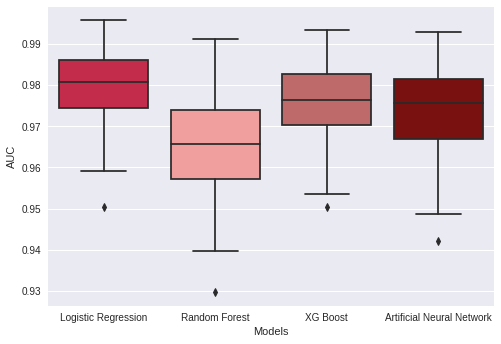

In [43]:
colors = ['#DC143C', '#FF9090', '#CD5C5C', '#8B0000']
sns.boxplot(data=auc, palette=colors)
plt.ylabel('AUC')
plt.xlabel('Models')
plt.show()

In [44]:
lr_l= []
rf_l= []
xgb_l= []
ann_l= []
for i in range(150):
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state= i)
    
    lr_model = LogisticRegression(**grid_search_lr.best_params_)
    lr_model.fit(X_train, y_train)
    y_1= lr_model.predict(X_test)
    lr_f1= f1_score(y_test, y_1)
    lr_l.append(lr_f1)
    
    rf_model= RandomForestClassifier(**grid_search_rf.best_params_)
    rf_model.fit(X_train, y_train)
    y_2= rf_model.predict(X_test)
    rf_f1= f1_score(y_test, y_2)
    rf_l.append(rf_f1)
    
    xgb_model= XGBClassifier(**grid_search_xgb.best_params_)
    xgb_model.fit(X_train, y_train)
    y_3= xgb_model.predict(X_test)
    xgb_f1= f1_score(y_test, y_3)
    xgb_l.append(xgb_f1)
    
    ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    ann.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    history = ann.fit(X_train, y_train,
                      epochs=50,
                      batch_size=32,
                      validation_split=0.2)
    y_4 = ann.predict(X_test)
    y_4= y_4.reshape(y_4.shape[0],)
    y_4= np.array([round(i) for i in y_4])
    ann_f1= f1_score(y_test, y_4)
    ann_l.append(ann_f1)

Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6848 - precision_301: 0.4769 - recall_301: 0.8634 - val_loss: 0.6509 - val_precision_301: 0.8298 - val_recall_301: 0.5735
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6056 - precision_301: 0.8750 - recall_301: 0.6167 - val_loss: 0.5973 - val_precision_301: 0.8043 - val_recall_301: 0.5441
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5327 - precision_301: 0.8529 - recall_301: 0.6388 - val_loss: 0.5324 - val_precision_301: 0.7843 - val_recall_301: 0.5882
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4509 - precision_301: 0.8632 - recall_301: 0.7225 - val_loss: 0.4623 - val_precision_301: 0.8136 - val_recall_301: 0.7059
Epoch 5/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3716 - precision_301: 0.8614 - recall_301: 0.7665 - val_loss: 0.3916 - val_precision_301: 0.8769 - val_recall_301: 0.8382
Epoch 6/50
20/20 [==

Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0271 - precision_301: 0.9870 - recall_301: 1.0000 - val_loss: 0.2680 - val_precision_301: 0.9375 - val_recall_301: 0.8824
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0263 - precision_301: 0.9913 - recall_301: 1.0000 - val_loss: 0.2693 - val_precision_301: 0.9375 - val_recall_301: 0.8824
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0252 - precision_301: 0.9870 - recall_301: 1.0000 - val_loss: 0.2765 - val_precision_301: 0.9375 - val_recall_301: 0.8824
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0237 - precision_301: 0.9913 - recall_301: 1.0000 - val_loss: 0.2787 - val_precision_301: 0.9375 - val_recall_301: 0.8824
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0228 - precision_301: 0.9913 - recall_301: 1.0000 - val_loss: 0.2759 - val_precision_301: 0.9375 - val_recall_301: 0.8824
Epoch 48/50
20/

20/20 [==============================] - 0s 2ms/step - loss: 0.0382 - precision_303: 0.9751 - recall_303: 1.0000 - val_loss: 0.2586 - val_precision_303: 0.8857 - val_recall_303: 0.9118
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0351 - precision_303: 0.9751 - recall_303: 1.0000 - val_loss: 0.2634 - val_precision_303: 0.8857 - val_recall_303: 0.9118
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0334 - precision_303: 0.9751 - recall_303: 1.0000 - val_loss: 0.2684 - val_precision_303: 0.8857 - val_recall_303: 0.9118
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0314 - precision_303: 0.9792 - recall_303: 1.0000 - val_loss: 0.2743 - val_precision_303: 0.8857 - val_recall_303: 0.9118
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0290 - precision_303: 0.9833 - recall_303: 1.0000 - val_loss: 0.2797 - val_precision_303: 0.8857 - val_recall_303: 0.9118
Epoch 30/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.2142 - precision_305: 0.9180 - recall_305: 0.9218 - val_loss: 0.2072 - val_precision_305: 0.9365 - val_recall_305: 0.9672
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1726 - precision_305: 0.9112 - recall_305: 0.9712 - val_loss: 0.1712 - val_precision_305: 0.9365 - val_recall_305: 0.9672
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1490 - precision_305: 0.9115 - recall_305: 0.9753 - val_loss: 0.1540 - val_precision_305: 0.9365 - val_recall_305: 0.9672
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1364 - precision_305: 0.9192 - recall_305: 0.9835 - val_loss: 0.1470 - val_precision_305: 0.9365 - val_recall_305: 0.9672
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1271 - precision_305: 0.9163 - recall_305: 0.9918 - val_loss: 0.1408 - val_precision_305: 0.9365 - val_recall_305: 0.9672
Epoch 12/50
20/20 [==========

Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0214 - precision_305: 0.9878 - recall_305: 1.0000 - val_loss: 0.2125 - val_precision_305: 0.9091 - val_recall_305: 0.9836
Epoch 50/50
7/7 [==============================] - 0s 656us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6628 - precision_306: 0.3226 - recall_306: 0.0400 - val_loss: 0.6132 - val_precision_306: 0.0000e+00 - val_recall_306: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5989 - precision_306: 1.0000 - recall_306: 0.0080 - val_loss: 0.5583 - val_precision_306: 1.0000 - val_recall_306: 0.0893
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5395 - precision_306: 0.9747 - recall_306: 0.3080 - val_loss: 0.5068 - val_precision_306: 0.9630 - val_recall_306: 0.4643
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4772 - precision_306: 0.9451 - recall_306: 0.6200 - val_loss: 0.4484

20/20 [==============================] - 0s 2ms/step - loss: 0.0457 - precision_307: 0.9636 - recall_307: 1.0000 - val_loss: 0.1706 - val_precision_307: 0.9206 - val_recall_307: 0.9508
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0458 - precision_307: 0.9754 - recall_307: 1.0000 - val_loss: 0.1717 - val_precision_307: 0.9206 - val_recall_307: 0.9508
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0426 - precision_307: 0.9675 - recall_307: 1.0000 - val_loss: 0.1694 - val_precision_307: 0.9206 - val_recall_307: 0.9508
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0393 - precision_307: 0.9835 - recall_307: 1.0000 - val_loss: 0.1776 - val_precision_307: 0.9194 - val_recall_307: 0.9344
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0372 - precision_307: 0.9675 - recall_307: 1.0000 - val_loss: 0.1781 - val_precision_307: 0.9194 - val_recall_307: 0.9344
Epoch 36/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0818 - precision_309: 0.9398 - recall_309: 0.9915 - val_loss: 0.2258 - val_precision_309: 0.9167 - val_recall_309: 0.8871
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0761 - precision_309: 0.9402 - recall_309: 1.0000 - val_loss: 0.2253 - val_precision_309: 0.9167 - val_recall_309: 0.8871
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0721 - precision_309: 0.9438 - recall_309: 0.9958 - val_loss: 0.2425 - val_precision_309: 0.9167 - val_recall_309: 0.8871
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0673 - precision_309: 0.9440 - recall_309: 1.0000 - val_loss: 0.2438 - val_precision_309: 0.9167 - val_recall_309: 0.8871
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0634 - precision_309: 0.9553 - recall_309: 0.9958 - val_loss: 0.2541 - val_precision_309: 0.9167 - val_recall_309: 0.8871
Epoch 18/50
20/20 [========

Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0161 - precision_310: 0.9919 - recall_310: 1.0000 - val_loss: 0.2921 - val_precision_310: 0.8889 - val_recall_310: 0.9032
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0148 - precision_310: 0.9959 - recall_310: 1.0000 - val_loss: 0.3091 - val_precision_310: 0.8852 - val_recall_310: 0.8710
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0142 - precision_310: 0.9959 - recall_310: 1.0000 - val_loss: 0.3197 - val_precision_310: 0.8833 - val_recall_310: 0.8548
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0130 - precision_310: 0.9959 - recall_310: 1.0000 - val_loss: 0.3105 - val_precision_310: 0.8833 - val_recall_310: 0.8548
Epoch 50/50
7/7 [==============================] - 0s 654us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6599 - precision_311: 0.3737 - recall_311: 0.1474 - val_loss: 0.5816 - va

20/20 [==============================] - 0s 2ms/step - loss: 0.0513 - precision_312: 0.9633 - recall_312: 1.0000 - val_loss: 0.2849 - val_precision_312: 0.8667 - val_recall_312: 0.9420
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0476 - precision_312: 0.9633 - recall_312: 1.0000 - val_loss: 0.2813 - val_precision_312: 0.8667 - val_recall_312: 0.9420
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0461 - precision_312: 0.9672 - recall_312: 1.0000 - val_loss: 0.2922 - val_precision_312: 0.8667 - val_recall_312: 0.9420
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0440 - precision_312: 0.9672 - recall_312: 1.0000 - val_loss: 0.2953 - val_precision_312: 0.8667 - val_recall_312: 0.9420
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0416 - precision_312: 0.9712 - recall_312: 1.0000 - val_loss: 0.3021 - val_precision_312: 0.8667 - val_recall_312: 0.9420
Epoch 33/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1355 - precision_314: 0.9134 - recall_314: 0.9789 - val_loss: 0.1095 - val_precision_314: 0.9538 - val_recall_314: 0.9688
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1263 - precision_314: 0.9134 - recall_314: 0.9789 - val_loss: 0.1067 - val_precision_314: 0.9538 - val_recall_314: 0.9688
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1202 - precision_314: 0.9209 - recall_314: 0.9831 - val_loss: 0.0996 - val_precision_314: 0.9538 - val_recall_314: 0.9688
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1162 - precision_314: 0.9213 - recall_314: 0.9873 - val_loss: 0.1049 - val_precision_314: 0.9531 - val_recall_314: 0.9531
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1117 - precision_314: 0.9180 - recall_314: 0.9916 - val_loss: 0.1011 - val_precision_314: 0.9538 - val_recall_314: 0.9688
Epoch 15/50
20/20 [========

Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0333 - precision_315: 0.9703 - recall_315: 1.0000 - val_loss: 0.2263 - val_precision_315: 0.8730 - val_recall_315: 0.8871
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0313 - precision_315: 0.9786 - recall_315: 1.0000 - val_loss: 0.2270 - val_precision_315: 0.8730 - val_recall_315: 0.8871
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0296 - precision_315: 0.9786 - recall_315: 1.0000 - val_loss: 0.2307 - val_precision_315: 0.8750 - val_recall_315: 0.9032
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0286 - precision_315: 0.9745 - recall_315: 1.0000 - val_loss: 0.2348 - val_precision_315: 0.8750 - val_recall_315: 0.9032
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0271 - precision_315: 0.9745 - recall_315: 1.0000 - val_loss: 0.2352 - val_precision_315: 0.8750 - val_recall_315: 0.9032
Epoch 48/50
20/

20/20 [==============================] - 0s 2ms/step - loss: 0.0512 - precision_317: 0.9600 - recall_317: 1.0000 - val_loss: 0.2107 - val_precision_317: 0.8644 - val_recall_317: 0.8793
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0497 - precision_317: 0.9755 - recall_317: 0.9958 - val_loss: 0.2187 - val_precision_317: 0.8621 - val_recall_317: 0.8621
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0467 - precision_317: 0.9639 - recall_317: 1.0000 - val_loss: 0.2223 - val_precision_317: 0.8772 - val_recall_317: 0.8621
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0423 - precision_317: 0.9756 - recall_317: 1.0000 - val_loss: 0.2257 - val_precision_317: 0.8621 - val_recall_317: 0.8621
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0414 - precision_317: 0.9717 - recall_317: 1.0000 - val_loss: 0.2352 - val_precision_317: 0.8772 - val_recall_317: 0.8621
Epoch 30/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.2056 - precision_319: 0.9409 - recall_319: 0.9449 - val_loss: 0.2453 - val_precision_319: 0.8947 - val_recall_319: 0.9107
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1558 - precision_319: 0.9344 - recall_319: 0.9661 - val_loss: 0.2092 - val_precision_319: 0.8947 - val_recall_319: 0.9107
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1261 - precision_319: 0.9390 - recall_319: 0.9788 - val_loss: 0.1929 - val_precision_319: 0.8947 - val_recall_319: 0.9107
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1103 - precision_319: 0.9280 - recall_319: 0.9831 - val_loss: 0.1849 - val_precision_319: 0.8947 - val_recall_319: 0.9107
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0994 - precision_319: 0.9431 - recall_319: 0.9831 - val_loss: 0.1848 - val_precision_319: 0.8947 - val_recall_319: 0.9107
Epoch 12/50
20/20 [==========

Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0107 - precision_319: 0.9958 - recall_319: 1.0000 - val_loss: 0.3028 - val_precision_319: 0.8947 - val_recall_319: 0.9107
Epoch 50/50
7/7 [==============================] - 0s 734us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6854 - precision_320: 0.4062 - recall_320: 0.4855 - val_loss: 0.6214 - val_precision_320: 1.0000 - val_recall_320: 0.1346
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6014 - precision_320: 0.9677 - recall_320: 0.1245 - val_loss: 0.5409 - val_precision_320: 1.0000 - val_recall_320: 0.1923
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5303 - precision_320: 0.9756 - recall_320: 0.3320 - val_loss: 0.4641 - val_precision_320: 0.9286 - val_recall_320: 0.5000
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4515 - precision_320: 0.9290 - recall_320: 0.6515 - val_loss: 0.3905 - val_p

20/20 [==============================] - 0s 2ms/step - loss: 0.0367 - precision_321: 0.9833 - recall_321: 0.9958 - val_loss: 0.1430 - val_precision_321: 0.9667 - val_recall_321: 0.9508
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0349 - precision_321: 0.9834 - recall_321: 1.0000 - val_loss: 0.1502 - val_precision_321: 0.9667 - val_recall_321: 0.9508
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0334 - precision_321: 0.9874 - recall_321: 0.9958 - val_loss: 0.1494 - val_precision_321: 0.9667 - val_recall_321: 0.9508
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0313 - precision_321: 0.9833 - recall_321: 0.9958 - val_loss: 0.1497 - val_precision_321: 0.9667 - val_recall_321: 0.9508
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0301 - precision_321: 0.9834 - recall_321: 1.0000 - val_loss: 0.1562 - val_precision_321: 0.9667 - val_recall_321: 0.9508
Epoch 36/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0925 - precision_323: 0.9277 - recall_323: 0.9914 - val_loss: 0.1457 - val_precision_323: 0.9062 - val_recall_323: 0.9667
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0854 - precision_323: 0.9352 - recall_323: 0.9914 - val_loss: 0.1453 - val_precision_323: 0.9062 - val_recall_323: 0.9667
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0808 - precision_323: 0.9390 - recall_323: 0.9914 - val_loss: 0.1447 - val_precision_323: 0.9062 - val_recall_323: 0.9667
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0772 - precision_323: 0.9431 - recall_323: 0.9957 - val_loss: 0.1461 - val_precision_323: 0.9062 - val_recall_323: 0.9667
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0731 - precision_323: 0.9469 - recall_323: 0.9957 - val_loss: 0.1468 - val_precision_323: 0.9062 - val_recall_323: 0.9667
Epoch 18/50
20/20 [========

Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0141 - precision_324: 1.0000 - recall_324: 1.0000 - val_loss: 0.1717 - val_precision_324: 0.9194 - val_recall_324: 0.9661
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0137 - precision_324: 0.9916 - recall_324: 1.0000 - val_loss: 0.1734 - val_precision_324: 0.9194 - val_recall_324: 0.9661
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0124 - precision_324: 1.0000 - recall_324: 1.0000 - val_loss: 0.1780 - val_precision_324: 0.9194 - val_recall_324: 0.9661
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0124 - precision_324: 0.9916 - recall_324: 1.0000 - val_loss: 0.1748 - val_precision_324: 0.9194 - val_recall_324: 0.9661
Epoch 50/50
7/7 [==============================] - 0s 574us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6723 - precision_325: 0.4969 - recall_325: 0.6987 - val_loss: 0.6271 - va

20/20 [==============================] - 0s 2ms/step - loss: 0.0632 - precision_326: 0.9689 - recall_326: 0.9960 - val_loss: 0.1696 - val_precision_326: 0.9245 - val_recall_326: 0.9245
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0598 - precision_326: 0.9615 - recall_326: 1.0000 - val_loss: 0.1745 - val_precision_326: 0.9091 - val_recall_326: 0.9434
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0594 - precision_326: 0.9653 - recall_326: 1.0000 - val_loss: 0.1726 - val_precision_326: 0.9245 - val_recall_326: 0.9245
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0548 - precision_326: 0.9653 - recall_326: 1.0000 - val_loss: 0.1756 - val_precision_326: 0.9091 - val_recall_326: 0.9434
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0543 - precision_326: 0.9653 - recall_326: 1.0000 - val_loss: 0.1819 - val_precision_326: 0.9091 - val_recall_326: 0.9434
Epoch 33/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1259 - precision_328: 0.9176 - recall_328: 0.9915 - val_loss: 0.1381 - val_precision_328: 0.9385 - val_recall_328: 0.9839
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1143 - precision_328: 0.9216 - recall_328: 0.9958 - val_loss: 0.1357 - val_precision_328: 0.9385 - val_recall_328: 0.9839
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1062 - precision_328: 0.9252 - recall_328: 0.9958 - val_loss: 0.1331 - val_precision_328: 0.9385 - val_recall_328: 0.9839
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0982 - precision_328: 0.9289 - recall_328: 0.9958 - val_loss: 0.1315 - val_precision_328: 0.9385 - val_recall_328: 0.9839
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0934 - precision_328: 0.9252 - recall_328: 0.9958 - val_loss: 0.1311 - val_precision_328: 0.9385 - val_recall_328: 0.9839
Epoch 15/50
20/20 [========

Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0135 - precision_329: 0.9913 - recall_329: 1.0000 - val_loss: 0.2649 - val_precision_329: 0.9231 - val_recall_329: 0.8571
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0131 - precision_329: 0.9913 - recall_329: 1.0000 - val_loss: 0.2717 - val_precision_329: 0.9231 - val_recall_329: 0.8571
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0129 - precision_329: 0.9957 - recall_329: 1.0000 - val_loss: 0.2738 - val_precision_329: 0.9231 - val_recall_329: 0.8571
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0114 - precision_329: 0.9957 - recall_329: 1.0000 - val_loss: 0.2776 - val_precision_329: 0.9231 - val_recall_329: 0.8571
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0110 - precision_329: 0.9957 - recall_329: 1.0000 - val_loss: 0.2815 - val_precision_329: 0.9231 - val_recall_329: 0.8571
Epoch 48/50
20/

20/20 [==============================] - 0s 2ms/step - loss: 0.0549 - precision_331: 0.9563 - recall_331: 0.9959 - val_loss: 0.1303 - val_precision_331: 0.9242 - val_recall_331: 0.9531
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0512 - precision_331: 0.9640 - recall_331: 0.9959 - val_loss: 0.1328 - val_precision_331: 0.9242 - val_recall_331: 0.9531
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0494 - precision_331: 0.9679 - recall_331: 0.9959 - val_loss: 0.1327 - val_precision_331: 0.9242 - val_recall_331: 0.9531
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0470 - precision_331: 0.9680 - recall_331: 1.0000 - val_loss: 0.1335 - val_precision_331: 0.9242 - val_recall_331: 0.9531
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0453 - precision_331: 0.9641 - recall_331: 1.0000 - val_loss: 0.1351 - val_precision_331: 0.9242 - val_recall_331: 0.9531
Epoch 30/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.2542 - precision_333: 0.9333 - recall_333: 0.9130 - val_loss: 0.2871 - val_precision_333: 0.8793 - val_recall_333: 0.8361
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1958 - precision_333: 0.9345 - recall_333: 0.9304 - val_loss: 0.2393 - val_precision_333: 0.8889 - val_recall_333: 0.9180
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1559 - precision_333: 0.9163 - recall_333: 0.9522 - val_loss: 0.2133 - val_precision_333: 0.8889 - val_recall_333: 0.9180
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1337 - precision_333: 0.9184 - recall_333: 0.9783 - val_loss: 0.2094 - val_precision_333: 0.8889 - val_recall_333: 0.9180
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1206 - precision_333: 0.9184 - recall_333: 0.9783 - val_loss: 0.2080 - val_precision_333: 0.8889 - val_recall_333: 0.9180
Epoch 12/50
20/20 [==========

Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0174 - precision_333: 0.9871 - recall_333: 1.0000 - val_loss: 0.3319 - val_precision_333: 0.8689 - val_recall_333: 0.8689
Epoch 50/50
7/7 [==============================] - 0s 594us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6541 - precision_334: 0.5441 - recall_334: 0.3008 - val_loss: 0.6000 - val_precision_334: 0.7000 - val_recall_334: 0.2745
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5947 - precision_334: 0.7909 - recall_334: 0.3537 - val_loss: 0.5306 - val_precision_334: 0.8056 - val_recall_334: 0.5686
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5349 - precision_334: 0.8072 - recall_334: 0.5447 - val_loss: 0.4550 - val_precision_334: 0.7826 - val_recall_334: 0.7059
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4717 - precision_334: 0.8205 - recall_334: 0.6504 - val_loss: 0.3802 - val_p

20/20 [==============================] - 0s 2ms/step - loss: 0.0534 - precision_335: 0.9711 - recall_335: 1.0000 - val_loss: 0.1285 - val_precision_335: 0.9355 - val_recall_335: 0.9355
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0515 - precision_335: 0.9671 - recall_335: 1.0000 - val_loss: 0.1261 - val_precision_335: 0.9355 - val_recall_335: 0.9355
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0489 - precision_335: 0.9711 - recall_335: 1.0000 - val_loss: 0.1287 - val_precision_335: 0.9355 - val_recall_335: 0.9355
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0480 - precision_335: 0.9711 - recall_335: 1.0000 - val_loss: 0.1310 - val_precision_335: 0.9355 - val_recall_335: 0.9355
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0457 - precision_335: 0.9711 - recall_335: 1.0000 - val_loss: 0.1305 - val_precision_335: 0.9355 - val_recall_335: 0.9355
Epoch 36/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0975 - precision_337: 0.9313 - recall_337: 0.9919 - val_loss: 0.1213 - val_precision_337: 0.9365 - val_recall_337: 0.9516
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0945 - precision_337: 0.9211 - recall_337: 0.9959 - val_loss: 0.1180 - val_precision_337: 0.9365 - val_recall_337: 0.9516
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0907 - precision_337: 0.9528 - recall_337: 0.9837 - val_loss: 0.1194 - val_precision_337: 0.9365 - val_recall_337: 0.9516
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0829 - precision_337: 0.9387 - recall_337: 0.9959 - val_loss: 0.1170 - val_precision_337: 0.9365 - val_recall_337: 0.9516
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0775 - precision_337: 0.9459 - recall_337: 0.9959 - val_loss: 0.1207 - val_precision_337: 0.9355 - val_recall_337: 0.9355
Epoch 18/50
20/20 [========

Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0179 - precision_338: 1.0000 - recall_338: 0.9957 - val_loss: 0.3003 - val_precision_338: 0.9259 - val_recall_338: 0.8929
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0166 - precision_338: 0.9872 - recall_338: 0.9957 - val_loss: 0.2960 - val_precision_338: 0.9259 - val_recall_338: 0.8929
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0154 - precision_338: 0.9914 - recall_338: 0.9957 - val_loss: 0.3148 - val_precision_338: 0.9259 - val_recall_338: 0.8929
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0149 - precision_338: 0.9957 - recall_338: 0.9957 - val_loss: 0.3154 - val_precision_338: 0.9259 - val_recall_338: 0.8929
Epoch 50/50
7/7 [==============================] - 0s 679us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6267 - precision_339: 0.5729 - recall_339: 0.2311 - val_loss: 0.5741 - va

20/20 [==============================] - 0s 2ms/step - loss: 0.0547 - precision_340: 0.9536 - recall_340: 0.9956 - val_loss: 0.1411 - val_precision_340: 0.9688 - val_recall_340: 0.9118
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0543 - precision_340: 0.9617 - recall_340: 0.9956 - val_loss: 0.1415 - val_precision_340: 0.9692 - val_recall_340: 0.9265
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0523 - precision_340: 0.9617 - recall_340: 0.9956 - val_loss: 0.1442 - val_precision_340: 0.9683 - val_recall_340: 0.8971
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0486 - precision_340: 0.9658 - recall_340: 0.9956 - val_loss: 0.1443 - val_precision_340: 0.9688 - val_recall_340: 0.9118
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0471 - precision_340: 0.9658 - recall_340: 0.9956 - val_loss: 0.1482 - val_precision_340: 0.9683 - val_recall_340: 0.8971
Epoch 33/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1167 - precision_342: 0.9265 - recall_342: 0.9827 - val_loss: 0.1631 - val_precision_342: 0.9104 - val_recall_342: 0.9385
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1098 - precision_342: 0.9265 - recall_342: 0.9827 - val_loss: 0.1646 - val_precision_342: 0.9091 - val_recall_342: 0.9231
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1036 - precision_342: 0.9378 - recall_342: 0.9784 - val_loss: 0.1740 - val_precision_342: 0.9091 - val_recall_342: 0.9231
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0948 - precision_342: 0.9309 - recall_342: 0.9913 - val_loss: 0.1694 - val_precision_342: 0.8939 - val_recall_342: 0.9077
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0915 - precision_342: 0.9309 - recall_342: 0.9913 - val_loss: 0.1734 - val_precision_342: 0.9077 - val_recall_342: 0.9077
Epoch 15/50
20/20 [========

Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0103 - precision_343: 0.9959 - recall_343: 1.0000 - val_loss: 0.4385 - val_precision_343: 0.8594 - val_recall_343: 0.9016
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0102 - precision_343: 0.9959 - recall_343: 1.0000 - val_loss: 0.4405 - val_precision_343: 0.8594 - val_recall_343: 0.9016
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0089 - precision_343: 0.9959 - recall_343: 1.0000 - val_loss: 0.4499 - val_precision_343: 0.8594 - val_recall_343: 0.9016
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0088 - precision_343: 0.9959 - recall_343: 1.0000 - val_loss: 0.4539 - val_precision_343: 0.8594 - val_recall_343: 0.9016
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0086 - precision_343: 0.9959 - recall_343: 1.0000 - val_loss: 0.4570 - val_precision_343: 0.8594 - val_recall_343: 0.9016
Epoch 48/50
20/

20/20 [==============================] - 0s 2ms/step - loss: 0.0557 - precision_345: 0.9641 - recall_345: 0.9959 - val_loss: 0.1434 - val_precision_345: 0.9048 - val_recall_345: 0.9500
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0538 - precision_345: 0.9603 - recall_345: 0.9959 - val_loss: 0.1439 - val_precision_345: 0.9048 - val_recall_345: 0.9500
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0513 - precision_345: 0.9567 - recall_345: 1.0000 - val_loss: 0.1408 - val_precision_345: 0.9048 - val_recall_345: 0.9500
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0479 - precision_345: 0.9680 - recall_345: 0.9959 - val_loss: 0.1495 - val_precision_345: 0.9048 - val_recall_345: 0.9500
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0449 - precision_345: 0.9759 - recall_345: 1.0000 - val_loss: 0.1484 - val_precision_345: 0.9048 - val_recall_345: 0.9500
Epoch 30/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1948 - precision_347: 0.9447 - recall_347: 0.9407 - val_loss: 0.2300 - val_precision_347: 0.8727 - val_recall_347: 0.9231
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1490 - precision_347: 0.9342 - recall_347: 0.9619 - val_loss: 0.1989 - val_precision_347: 0.8750 - val_recall_347: 0.9423
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1222 - precision_347: 0.9309 - recall_347: 0.9703 - val_loss: 0.1870 - val_precision_347: 0.8772 - val_recall_347: 0.9615
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1080 - precision_347: 0.9312 - recall_347: 0.9746 - val_loss: 0.1782 - val_precision_347: 0.8772 - val_recall_347: 0.9615
Epoch 11/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0965 - precision_347: 0.9320 - recall_347: 0.9873 - val_loss: 0.1776 - val_precision_347: 0.8772 - val_recall_347: 0.9615
Epoch 12/50
20/20 [==========

Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0077 - precision_347: 1.0000 - recall_347: 1.0000 - val_loss: 0.3202 - val_precision_347: 0.8654 - val_recall_347: 0.8654
Epoch 50/50
7/7 [==============================] - 0s 614us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6515 - precision_348: 0.5733 - recall_348: 0.1762 - val_loss: 0.6196 - val_precision_348: 0.7500 - val_recall_348: 0.0455
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5723 - precision_348: 0.9804 - recall_348: 0.2049 - val_loss: 0.5592 - val_precision_348: 0.8462 - val_recall_348: 0.3333
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5003 - precision_348: 0.9483 - recall_348: 0.4508 - val_loss: 0.4961 - val_precision_348: 0.8372 - val_recall_348: 0.5455
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4240 - precision_348: 0.9081 - recall_348: 0.6885 - val_loss: 0.4298 - val_p

20/20 [==============================] - 0s 2ms/step - loss: 0.0445 - precision_349: 0.9752 - recall_349: 1.0000 - val_loss: 0.2063 - val_precision_349: 0.8644 - val_recall_349: 0.9444
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0428 - precision_349: 0.9593 - recall_349: 1.0000 - val_loss: 0.2089 - val_precision_349: 0.8644 - val_recall_349: 0.9444
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0402 - precision_349: 0.9752 - recall_349: 1.0000 - val_loss: 0.2093 - val_precision_349: 0.8621 - val_recall_349: 0.9259
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0387 - precision_349: 0.9752 - recall_349: 1.0000 - val_loss: 0.2161 - val_precision_349: 0.8644 - val_recall_349: 0.9444
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0386 - precision_349: 0.9712 - recall_349: 1.0000 - val_loss: 0.2171 - val_precision_349: 0.8621 - val_recall_349: 0.9259
Epoch 36/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0973 - precision_351: 0.9277 - recall_351: 0.9957 - val_loss: 0.2015 - val_precision_351: 0.8592 - val_recall_351: 0.9839
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0913 - precision_351: 0.9421 - recall_351: 0.9828 - val_loss: 0.2000 - val_precision_351: 0.8551 - val_recall_351: 0.9516
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0861 - precision_351: 0.9240 - recall_351: 0.9957 - val_loss: 0.2083 - val_precision_351: 0.8571 - val_recall_351: 0.9677
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0811 - precision_351: 0.9458 - recall_351: 0.9784 - val_loss: 0.2160 - val_precision_351: 0.8551 - val_recall_351: 0.9516
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0768 - precision_351: 0.9277 - recall_351: 0.9957 - val_loss: 0.2237 - val_precision_351: 0.8551 - val_recall_351: 0.9516
Epoch 18/50
20/20 [========

Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0252 - precision_352: 0.9918 - recall_352: 0.9959 - val_loss: 0.1994 - val_precision_352: 0.9062 - val_recall_352: 0.9355
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0242 - precision_352: 0.9879 - recall_352: 1.0000 - val_loss: 0.2007 - val_precision_352: 0.9062 - val_recall_352: 0.9355
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0235 - precision_352: 0.9879 - recall_352: 1.0000 - val_loss: 0.2041 - val_precision_352: 0.9062 - val_recall_352: 0.9355
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0218 - precision_352: 0.9919 - recall_352: 1.0000 - val_loss: 0.2045 - val_precision_352: 0.9062 - val_recall_352: 0.9355
Epoch 50/50
7/7 [==============================] - 0s 658us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6353 - precision_353: 0.5912 - recall_353: 0.3462 - val_loss: 0.6004 - va

20/20 [==============================] - 0s 2ms/step - loss: 0.0430 - precision_354: 0.9756 - recall_354: 1.0000 - val_loss: 0.2153 - val_precision_354: 0.9259 - val_recall_354: 0.9091
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0419 - precision_354: 0.9677 - recall_354: 1.0000 - val_loss: 0.2178 - val_precision_354: 0.9245 - val_recall_354: 0.8909
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0395 - precision_354: 0.9796 - recall_354: 1.0000 - val_loss: 0.2233 - val_precision_354: 0.9245 - val_recall_354: 0.8909
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0369 - precision_354: 0.9796 - recall_354: 1.0000 - val_loss: 0.2276 - val_precision_354: 0.9231 - val_recall_354: 0.8727
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0358 - precision_354: 0.9796 - recall_354: 1.0000 - val_loss: 0.2286 - val_precision_354: 0.9245 - val_recall_354: 0.8909
Epoch 33/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1243 - precision_356: 0.9145 - recall_356: 0.9840 - val_loss: 0.1559 - val_precision_356: 0.8491 - val_recall_356: 0.9184
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1152 - precision_356: 0.9251 - recall_356: 0.9880 - val_loss: 0.1525 - val_precision_356: 0.8654 - val_recall_356: 0.9184
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1083 - precision_356: 0.9288 - recall_356: 0.9920 - val_loss: 0.1512 - val_precision_356: 0.8654 - val_recall_356: 0.9184
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1030 - precision_356: 0.9254 - recall_356: 0.9920 - val_loss: 0.1534 - val_precision_356: 0.8654 - val_recall_356: 0.9184
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0990 - precision_356: 0.9288 - recall_356: 0.9920 - val_loss: 0.1542 - val_precision_356: 0.8654 - val_recall_356: 0.9184
Epoch 15/50
20/20 [========

Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0193 - precision_357: 0.9960 - recall_357: 1.0000 - val_loss: 0.2458 - val_precision_357: 0.8679 - val_recall_357: 0.8679
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0191 - precision_357: 0.9882 - recall_357: 1.0000 - val_loss: 0.2521 - val_precision_357: 0.8679 - val_recall_357: 0.8679
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0180 - precision_357: 0.9960 - recall_357: 1.0000 - val_loss: 0.2515 - val_precision_357: 0.8679 - val_recall_357: 0.8679
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0156 - precision_357: 0.9960 - recall_357: 1.0000 - val_loss: 0.2560 - val_precision_357: 0.8679 - val_recall_357: 0.8679
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0151 - precision_357: 0.9921 - recall_357: 1.0000 - val_loss: 0.2624 - val_precision_357: 0.8679 - val_recall_357: 0.8679
Epoch 48/50
20/

20/20 [==============================] - 0s 2ms/step - loss: 0.0716 - precision_359: 0.9401 - recall_359: 1.0000 - val_loss: 0.1342 - val_precision_359: 0.9298 - val_recall_359: 0.9298
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0701 - precision_359: 0.9508 - recall_359: 1.0000 - val_loss: 0.1418 - val_precision_359: 0.9286 - val_recall_359: 0.9123
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0643 - precision_359: 0.9472 - recall_359: 1.0000 - val_loss: 0.1406 - val_precision_359: 0.9286 - val_recall_359: 0.9123
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0618 - precision_359: 0.9617 - recall_359: 1.0000 - val_loss: 0.1500 - val_precision_359: 0.9245 - val_recall_359: 0.8596
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0582 - precision_359: 0.9544 - recall_359: 1.0000 - val_loss: 0.1435 - val_precision_359: 0.9298 - val_recall_359: 0.9298
Epoch 30/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.2016 - precision_361: 0.9367 - recall_361: 0.9119 - val_loss: 0.2179 - val_precision_361: 0.8983 - val_recall_361: 0.8833
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1632 - precision_361: 0.9261 - recall_361: 0.9383 - val_loss: 0.1861 - val_precision_361: 0.9048 - val_recall_361: 0.9500
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1395 - precision_361: 0.9195 - recall_361: 0.9559 - val_loss: 0.1712 - val_precision_361: 0.9048 - val_recall_361: 0.9500
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1250 - precision_361: 0.9283 - recall_361: 0.9692 - val_loss: 0.1657 - val_precision_361: 0.9048 - val_recall_361: 0.9500
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1141 - precision_361: 0.9286 - recall_361: 0.9736 - val_loss: 0.1599 - val_precision_361: 0.9032 - val_recall_361: 0.9333
Epoch 12/50
20/20 [==========

Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0190 - precision_361: 0.9913 - recall_361: 1.0000 - val_loss: 0.2115 - val_precision_361: 0.8871 - val_recall_361: 0.9167
Epoch 50/50
7/7 [==============================] - 0s 631us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6299 - precision_362: 0.6667 - recall_362: 0.0247 - val_loss: 0.6104 - val_precision_362: 1.0000 - val_recall_362: 0.0484
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5591 - precision_362: 0.9756 - recall_362: 0.1646 - val_loss: 0.5584 - val_precision_362: 0.9130 - val_recall_362: 0.3387
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4938 - precision_362: 0.9417 - recall_362: 0.4650 - val_loss: 0.5022 - val_precision_362: 0.8333 - val_recall_362: 0.6452
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4239 - precision_362: 0.8966 - recall_362: 0.7490 - val_loss: 0.4398 - val_p

20/20 [==============================] - 0s 2ms/step - loss: 0.0397 - precision_363: 0.9676 - recall_363: 1.0000 - val_loss: 0.2454 - val_precision_363: 0.8727 - val_recall_363: 0.9231
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0375 - precision_363: 0.9676 - recall_363: 1.0000 - val_loss: 0.2517 - val_precision_363: 0.8704 - val_recall_363: 0.9038
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0363 - precision_363: 0.9795 - recall_363: 1.0000 - val_loss: 0.2562 - val_precision_363: 0.8727 - val_recall_363: 0.9231
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0353 - precision_363: 0.9676 - recall_363: 1.0000 - val_loss: 0.2584 - val_precision_363: 0.8704 - val_recall_363: 0.9038
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0332 - precision_363: 0.9715 - recall_363: 1.0000 - val_loss: 0.2616 - val_precision_363: 0.8727 - val_recall_363: 0.9231
Epoch 36/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0961 - precision_365: 0.9325 - recall_365: 0.9958 - val_loss: 0.1747 - val_precision_365: 0.9138 - val_recall_365: 0.9298
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0924 - precision_365: 0.9363 - recall_365: 0.9958 - val_loss: 0.1782 - val_precision_365: 0.9138 - val_recall_365: 0.9298
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0878 - precision_365: 0.9400 - recall_365: 0.9958 - val_loss: 0.1790 - val_precision_365: 0.9138 - val_recall_365: 0.9298
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0851 - precision_365: 0.9365 - recall_365: 1.0000 - val_loss: 0.1817 - val_precision_365: 0.9138 - val_recall_365: 0.9298
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0803 - precision_365: 0.9438 - recall_365: 0.9958 - val_loss: 0.1897 - val_precision_365: 0.9138 - val_recall_365: 0.9298
Epoch 18/50
20/20 [========

Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0095 - precision_366: 1.0000 - recall_366: 1.0000 - val_loss: 0.4290 - val_precision_366: 0.8644 - val_recall_366: 0.8947
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0091 - precision_366: 1.0000 - recall_366: 1.0000 - val_loss: 0.4381 - val_precision_366: 0.8644 - val_recall_366: 0.8947
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0084 - precision_366: 1.0000 - recall_366: 1.0000 - val_loss: 0.4394 - val_precision_366: 0.8644 - val_recall_366: 0.8947
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0080 - precision_366: 1.0000 - recall_366: 1.0000 - val_loss: 0.4459 - val_precision_366: 0.8644 - val_recall_366: 0.8947
Epoch 50/50
7/7 [==============================] - 0s 608us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6657 - precision_367: 0.3929 - recall_367: 0.1369 - val_loss: 0.6237 - va

20/20 [==============================] - 0s 2ms/step - loss: 0.0486 - precision_368: 0.9662 - recall_368: 1.0000 - val_loss: 0.3042 - val_precision_368: 0.9048 - val_recall_368: 0.8143
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0470 - precision_368: 0.9745 - recall_368: 1.0000 - val_loss: 0.3128 - val_precision_368: 0.9032 - val_recall_368: 0.8000
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0465 - precision_368: 0.9662 - recall_368: 1.0000 - val_loss: 0.3148 - val_precision_368: 0.9048 - val_recall_368: 0.8143
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0439 - precision_368: 0.9786 - recall_368: 1.0000 - val_loss: 0.3259 - val_precision_368: 0.9000 - val_recall_368: 0.7714
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0410 - precision_368: 0.9745 - recall_368: 1.0000 - val_loss: 0.3096 - val_precision_368: 0.9062 - val_recall_368: 0.8286
Epoch 33/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1366 - precision_370: 0.9023 - recall_370: 0.9747 - val_loss: 0.1106 - val_precision_370: 0.9167 - val_recall_370: 1.0000
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1274 - precision_370: 0.9027 - recall_370: 0.9789 - val_loss: 0.1032 - val_precision_370: 0.9167 - val_recall_370: 1.0000
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1211 - precision_370: 0.9134 - recall_370: 0.9789 - val_loss: 0.1006 - val_precision_370: 0.9167 - val_recall_370: 1.0000
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1152 - precision_370: 0.9137 - recall_370: 0.9831 - val_loss: 0.0972 - val_precision_370: 0.9167 - val_recall_370: 1.0000
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1110 - precision_370: 0.9180 - recall_370: 0.9916 - val_loss: 0.0963 - val_precision_370: 0.9167 - val_recall_370: 1.0000
Epoch 15/50
20/20 [========

Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0349 - precision_371: 0.9785 - recall_371: 0.9956 - val_loss: 0.1765 - val_precision_371: 0.9167 - val_recall_371: 0.9167
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0346 - precision_371: 0.9703 - recall_371: 1.0000 - val_loss: 0.1902 - val_precision_371: 0.9167 - val_recall_371: 0.9167
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0332 - precision_371: 0.9703 - recall_371: 1.0000 - val_loss: 0.1888 - val_precision_371: 0.9167 - val_recall_371: 0.9167
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0304 - precision_371: 0.9786 - recall_371: 1.0000 - val_loss: 0.1926 - val_precision_371: 0.9167 - val_recall_371: 0.9167
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0295 - precision_371: 0.9786 - recall_371: 1.0000 - val_loss: 0.1950 - val_precision_371: 0.9167 - val_recall_371: 0.9167
Epoch 48/50
20/

20/20 [==============================] - 0s 2ms/step - loss: 0.0542 - precision_373: 0.9637 - recall_373: 1.0000 - val_loss: 0.1483 - val_precision_373: 0.9355 - val_recall_373: 0.9206
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0506 - precision_373: 0.9715 - recall_373: 1.0000 - val_loss: 0.1437 - val_precision_373: 0.9355 - val_recall_373: 0.9206
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0511 - precision_373: 0.9676 - recall_373: 1.0000 - val_loss: 0.1464 - val_precision_373: 0.9355 - val_recall_373: 0.9206
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0479 - precision_373: 0.9755 - recall_373: 1.0000 - val_loss: 0.1514 - val_precision_373: 0.9355 - val_recall_373: 0.9206
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0448 - precision_373: 0.9676 - recall_373: 1.0000 - val_loss: 0.1482 - val_precision_373: 0.9355 - val_recall_373: 0.9206
Epoch 30/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.2089 - precision_375: 0.9336 - recall_375: 0.9134 - val_loss: 0.2179 - val_precision_375: 0.9118 - val_recall_375: 0.9394
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1659 - precision_375: 0.9313 - recall_375: 0.9394 - val_loss: 0.1867 - val_precision_375: 0.9014 - val_recall_375: 0.9697
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1377 - precision_375: 0.9289 - recall_375: 0.9610 - val_loss: 0.1717 - val_precision_375: 0.9014 - val_recall_375: 0.9697
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1223 - precision_375: 0.9286 - recall_375: 0.9567 - val_loss: 0.1659 - val_precision_375: 0.9014 - val_recall_375: 0.9697
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1114 - precision_375: 0.9333 - recall_375: 0.9697 - val_loss: 0.1624 - val_precision_375: 0.9014 - val_recall_375: 0.9697
Epoch 12/50
20/20 [==========

Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0163 - precision_375: 0.9957 - recall_375: 1.0000 - val_loss: 0.2826 - val_precision_375: 0.8939 - val_recall_375: 0.8939
Epoch 50/50
7/7 [==============================] - 0s 662us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6730 - precision_376: 0.4632 - recall_376: 0.4350 - val_loss: 0.6212 - val_precision_376: 0.8824 - val_recall_376: 0.2542
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5930 - precision_376: 0.8889 - recall_376: 0.3252 - val_loss: 0.5500 - val_precision_376: 0.8571 - val_recall_376: 0.3051
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5289 - precision_376: 0.8873 - recall_376: 0.5122 - val_loss: 0.4857 - val_precision_376: 0.8649 - val_recall_376: 0.5424
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4635 - precision_376: 0.8639 - recall_376: 0.6707 - val_loss: 0.4207 - val_p

20/20 [==============================] - 0s 2ms/step - loss: 0.0452 - precision_377: 0.9755 - recall_377: 1.0000 - val_loss: 0.2020 - val_precision_377: 0.8971 - val_recall_377: 0.9531
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0429 - precision_377: 0.9755 - recall_377: 1.0000 - val_loss: 0.2007 - val_precision_377: 0.8986 - val_recall_377: 0.9688
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0427 - precision_377: 0.9715 - recall_377: 1.0000 - val_loss: 0.2017 - val_precision_377: 0.8971 - val_recall_377: 0.9531
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0395 - precision_377: 0.9755 - recall_377: 1.0000 - val_loss: 0.2059 - val_precision_377: 0.8971 - val_recall_377: 0.9531
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0382 - precision_377: 0.9755 - recall_377: 1.0000 - val_loss: 0.2106 - val_precision_377: 0.8857 - val_recall_377: 0.9688
Epoch 36/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1169 - precision_379: 0.9250 - recall_379: 0.9780 - val_loss: 0.1309 - val_precision_379: 0.9559 - val_recall_379: 0.9701
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1113 - precision_379: 0.9325 - recall_379: 0.9736 - val_loss: 0.1346 - val_precision_379: 0.9559 - val_recall_379: 0.9701
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1055 - precision_379: 0.9259 - recall_379: 0.9912 - val_loss: 0.1275 - val_precision_379: 0.9559 - val_recall_379: 0.9701
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0999 - precision_379: 0.9224 - recall_379: 0.9956 - val_loss: 0.1351 - val_precision_379: 0.9559 - val_recall_379: 0.9701
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0962 - precision_379: 0.9336 - recall_379: 0.9912 - val_loss: 0.1328 - val_precision_379: 0.9559 - val_recall_379: 0.9701
Epoch 18/50
20/20 [========

Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0229 - precision_380: 0.9800 - recall_380: 1.0000 - val_loss: 0.2389 - val_precision_380: 0.8906 - val_recall_380: 0.9661
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0218 - precision_380: 0.9839 - recall_380: 1.0000 - val_loss: 0.2464 - val_precision_380: 0.8906 - val_recall_380: 0.9661
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0197 - precision_380: 0.9839 - recall_380: 1.0000 - val_loss: 0.2526 - val_precision_380: 0.8906 - val_recall_380: 0.9661
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0191 - precision_380: 0.9879 - recall_380: 1.0000 - val_loss: 0.2553 - val_precision_380: 0.8906 - val_recall_380: 0.9661
Epoch 50/50
7/7 [==============================] - 0s 654us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6877 - precision_381: 0.4556 - recall_381: 0.6463 - val_loss: 0.6450 - va

20/20 [==============================] - 0s 2ms/step - loss: 0.0562 - precision_382: 0.9628 - recall_382: 1.0000 - val_loss: 0.2209 - val_precision_382: 0.8788 - val_recall_382: 0.9062
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0524 - precision_382: 0.9510 - recall_382: 1.0000 - val_loss: 0.2168 - val_precision_382: 0.8824 - val_recall_382: 0.9375
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0509 - precision_382: 0.9549 - recall_382: 1.0000 - val_loss: 0.2312 - val_precision_382: 0.8750 - val_recall_382: 0.8750
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0487 - precision_382: 0.9588 - recall_382: 1.0000 - val_loss: 0.2197 - val_precision_382: 0.8806 - val_recall_382: 0.9219
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0467 - precision_382: 0.9628 - recall_382: 1.0000 - val_loss: 0.2305 - val_precision_382: 0.8750 - val_recall_382: 0.8750
Epoch 33/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1319 - precision_384: 0.9239 - recall_384: 0.9808 - val_loss: 0.1545 - val_precision_384: 0.9167 - val_recall_384: 0.9167
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1216 - precision_384: 0.9309 - recall_384: 0.9846 - val_loss: 0.1513 - val_precision_384: 0.9167 - val_recall_384: 0.9167
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1162 - precision_384: 0.9278 - recall_384: 0.9885 - val_loss: 0.1482 - val_precision_384: 0.9167 - val_recall_384: 0.9167
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1097 - precision_384: 0.9348 - recall_384: 0.9923 - val_loss: 0.1445 - val_precision_384: 0.9167 - val_recall_384: 0.9167
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1064 - precision_384: 0.9384 - recall_384: 0.9962 - val_loss: 0.1439 - val_precision_384: 0.9167 - val_recall_384: 0.9167
Epoch 15/50
20/20 [========

Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0286 - precision_385: 0.9798 - recall_385: 1.0000 - val_loss: 0.2302 - val_precision_385: 0.8667 - val_recall_385: 0.8966
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0281 - precision_385: 0.9837 - recall_385: 0.9918 - val_loss: 0.2321 - val_precision_385: 0.8667 - val_recall_385: 0.8966
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0258 - precision_385: 0.9798 - recall_385: 1.0000 - val_loss: 0.2403 - val_precision_385: 0.8667 - val_recall_385: 0.8966
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0252 - precision_385: 0.9918 - recall_385: 0.9959 - val_loss: 0.2429 - val_precision_385: 0.8667 - val_recall_385: 0.8966
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0228 - precision_385: 0.9878 - recall_385: 1.0000 - val_loss: 0.2503 - val_precision_385: 0.8667 - val_recall_385: 0.8966
Epoch 48/50
20/

20/20 [==============================] - 0s 2ms/step - loss: 0.0551 - precision_387: 0.9538 - recall_387: 0.9956 - val_loss: 0.2723 - val_precision_387: 0.9524 - val_recall_387: 0.8696
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0529 - precision_387: 0.9619 - recall_387: 0.9956 - val_loss: 0.2651 - val_precision_387: 0.9394 - val_recall_387: 0.8986
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0498 - precision_387: 0.9580 - recall_387: 1.0000 - val_loss: 0.2838 - val_precision_387: 0.9385 - val_recall_387: 0.8841
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0474 - precision_387: 0.9580 - recall_387: 1.0000 - val_loss: 0.2843 - val_precision_387: 0.9385 - val_recall_387: 0.8841
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0452 - precision_387: 0.9620 - recall_387: 1.0000 - val_loss: 0.2959 - val_precision_387: 0.9531 - val_recall_387: 0.8841
Epoch 30/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.2200 - precision_389: 0.9258 - recall_389: 0.8908 - val_loss: 0.2669 - val_precision_389: 0.9107 - val_recall_389: 0.8644
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1670 - precision_389: 0.9496 - recall_389: 0.9496 - val_loss: 0.2307 - val_precision_389: 0.8966 - val_recall_389: 0.8814
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1316 - precision_389: 0.9463 - recall_389: 0.9622 - val_loss: 0.2175 - val_precision_389: 0.8833 - val_recall_389: 0.8983
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1108 - precision_389: 0.9467 - recall_389: 0.9706 - val_loss: 0.2127 - val_precision_389: 0.8833 - val_recall_389: 0.8983
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0977 - precision_389: 0.9476 - recall_389: 0.9874 - val_loss: 0.2083 - val_precision_389: 0.8689 - val_recall_389: 0.8983
Epoch 12/50
20/20 [==========

Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0183 - precision_389: 0.9916 - recall_389: 0.9958 - val_loss: 0.3675 - val_precision_389: 0.8644 - val_recall_389: 0.8644
Epoch 50/50
7/7 [==============================] - 0s 609us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6677 - precision_390: 0.4091 - recall_390: 0.3038 - val_loss: 0.5954 - val_precision_390: 0.8800 - val_recall_390: 0.3860
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5822 - precision_390: 0.8810 - recall_390: 0.3122 - val_loss: 0.5050 - val_precision_390: 0.9643 - val_recall_390: 0.4737
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5120 - precision_390: 0.9098 - recall_390: 0.4684 - val_loss: 0.4262 - val_precision_390: 0.9231 - val_recall_390: 0.6316
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4403 - precision_390: 0.9051 - recall_390: 0.6034 - val_loss: 0.3558 - val_p

20/20 [==============================] - 0s 2ms/step - loss: 0.0424 - precision_391: 0.9737 - recall_391: 1.0000 - val_loss: 0.2205 - val_precision_391: 0.9167 - val_recall_391: 0.8730
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0396 - precision_391: 0.9737 - recall_391: 1.0000 - val_loss: 0.2366 - val_precision_391: 0.9153 - val_recall_391: 0.8571
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0386 - precision_391: 0.9780 - recall_391: 1.0000 - val_loss: 0.2229 - val_precision_391: 0.9167 - val_recall_391: 0.8730
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0376 - precision_391: 0.9737 - recall_391: 1.0000 - val_loss: 0.2365 - val_precision_391: 0.9153 - val_recall_391: 0.8571
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0343 - precision_391: 0.9911 - recall_391: 1.0000 - val_loss: 0.2188 - val_precision_391: 0.9180 - val_recall_391: 0.8889
Epoch 36/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1077 - precision_393: 0.9216 - recall_393: 0.9874 - val_loss: 0.1469 - val_precision_393: 0.9245 - val_recall_393: 0.8909
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1020 - precision_393: 0.9216 - recall_393: 0.9874 - val_loss: 0.1465 - val_precision_393: 0.9423 - val_recall_393: 0.8909
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0971 - precision_393: 0.9291 - recall_393: 0.9916 - val_loss: 0.1464 - val_precision_393: 0.9423 - val_recall_393: 0.8909
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0923 - precision_393: 0.9222 - recall_393: 0.9958 - val_loss: 0.1460 - val_precision_393: 0.9245 - val_recall_393: 0.8909
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0883 - precision_393: 0.9258 - recall_393: 0.9958 - val_loss: 0.1525 - val_precision_393: 0.9423 - val_recall_393: 0.8909
Epoch 18/50
20/20 [========

Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0219 - precision_394: 0.9874 - recall_394: 1.0000 - val_loss: 0.2833 - val_precision_394: 0.8413 - val_recall_394: 0.9138
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0207 - precision_394: 0.9957 - recall_394: 0.9957 - val_loss: 0.2913 - val_precision_394: 0.8485 - val_recall_394: 0.9655
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0192 - precision_394: 0.9916 - recall_394: 1.0000 - val_loss: 0.2878 - val_precision_394: 0.8438 - val_recall_394: 0.9310
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0181 - precision_394: 0.9915 - recall_394: 0.9957 - val_loss: 0.2964 - val_precision_394: 0.8438 - val_recall_394: 0.9310
Epoch 50/50
7/7 [==============================] - 0s 590us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6373 - precision_395: 0.5200 - recall_395: 0.1741 - val_loss: 0.5957 - va

20/20 [==============================] - 0s 2ms/step - loss: 0.0541 - precision_396: 0.9563 - recall_396: 1.0000 - val_loss: 0.1956 - val_precision_396: 0.8772 - val_recall_396: 0.9259
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0523 - precision_396: 0.9640 - recall_396: 1.0000 - val_loss: 0.2034 - val_precision_396: 0.8750 - val_recall_396: 0.9074
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0486 - precision_396: 0.9563 - recall_396: 1.0000 - val_loss: 0.2086 - val_precision_396: 0.8750 - val_recall_396: 0.9074
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0450 - precision_396: 0.9640 - recall_396: 1.0000 - val_loss: 0.2096 - val_precision_396: 0.8750 - val_recall_396: 0.9074
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0428 - precision_396: 0.9679 - recall_396: 1.0000 - val_loss: 0.2173 - val_precision_396: 0.8750 - val_recall_396: 0.9074
Epoch 33/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1261 - precision_398: 0.9135 - recall_398: 0.9838 - val_loss: 0.1378 - val_precision_398: 0.9298 - val_recall_398: 0.9298
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1173 - precision_398: 0.9205 - recall_398: 0.9838 - val_loss: 0.1362 - val_precision_398: 0.9455 - val_recall_398: 0.9123
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1102 - precision_398: 0.9173 - recall_398: 0.9879 - val_loss: 0.1313 - val_precision_398: 0.9298 - val_recall_398: 0.9298
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1049 - precision_398: 0.9179 - recall_398: 0.9960 - val_loss: 0.1318 - val_precision_398: 0.8983 - val_recall_398: 0.9298
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0996 - precision_398: 0.9280 - recall_398: 0.9919 - val_loss: 0.1328 - val_precision_398: 0.9298 - val_recall_398: 0.9298
Epoch 15/50
20/20 [========

Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0277 - precision_399: 0.9870 - recall_399: 1.0000 - val_loss: 0.2652 - val_precision_399: 0.8615 - val_recall_399: 0.9032
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0271 - precision_399: 0.9870 - recall_399: 1.0000 - val_loss: 0.2690 - val_precision_399: 0.8615 - val_recall_399: 0.9032
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0254 - precision_399: 0.9913 - recall_399: 1.0000 - val_loss: 0.2730 - val_precision_399: 0.8615 - val_recall_399: 0.9032
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0247 - precision_399: 0.9870 - recall_399: 1.0000 - val_loss: 0.2748 - val_precision_399: 0.8636 - val_recall_399: 0.9194
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0235 - precision_399: 0.9913 - recall_399: 1.0000 - val_loss: 0.2756 - val_precision_399: 0.8615 - val_recall_399: 0.9032
Epoch 48/50
20/

20/20 [==============================] - 0s 2ms/step - loss: 0.0503 - precision_401: 0.9667 - recall_401: 1.0000 - val_loss: 0.2127 - val_precision_401: 0.8571 - val_recall_401: 0.9310
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0476 - precision_401: 0.9667 - recall_401: 1.0000 - val_loss: 0.2115 - val_precision_401: 0.8710 - val_recall_401: 0.9310
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0461 - precision_401: 0.9667 - recall_401: 1.0000 - val_loss: 0.2126 - val_precision_401: 0.8689 - val_recall_401: 0.9138
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0431 - precision_401: 0.9789 - recall_401: 1.0000 - val_loss: 0.2228 - val_precision_401: 0.8548 - val_recall_401: 0.9138
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0429 - precision_401: 0.9707 - recall_401: 1.0000 - val_loss: 0.2242 - val_precision_401: 0.8571 - val_recall_401: 0.9310
Epoch 30/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.2154 - precision_403: 0.9375 - recall_403: 0.9146 - val_loss: 0.2550 - val_precision_403: 0.8596 - val_recall_403: 0.8909
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1656 - precision_403: 0.9328 - recall_403: 0.9593 - val_loss: 0.2172 - val_precision_403: 0.8644 - val_recall_403: 0.9273
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1331 - precision_403: 0.9370 - recall_403: 0.9675 - val_loss: 0.1990 - val_precision_403: 0.8644 - val_recall_403: 0.9273
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1136 - precision_403: 0.9370 - recall_403: 0.9675 - val_loss: 0.1888 - val_precision_403: 0.8689 - val_recall_403: 0.9636
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1010 - precision_403: 0.9344 - recall_403: 0.9837 - val_loss: 0.1848 - val_precision_403: 0.8689 - val_recall_403: 0.9636
Epoch 12/50
20/20 [==========

Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0145 - precision_403: 0.9960 - recall_403: 1.0000 - val_loss: 0.2488 - val_precision_403: 0.8689 - val_recall_403: 0.9636
Epoch 50/50
7/7 [==============================] - 0s 597us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6919 - precision_404: 0.4067 - recall_404: 0.6058 - val_loss: 0.6510 - val_precision_404: 0.6111 - val_recall_404: 0.1897
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.6230 - precision_404: 0.8679 - recall_404: 0.1909 - val_loss: 0.5834 - val_precision_404: 0.9565 - val_recall_404: 0.3793
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5656 - precision_404: 0.9565 - recall_404: 0.3651 - val_loss: 0.5128 - val_precision_404: 0.9459 - val_recall_404: 0.6034
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4968 - precision_404: 0.9236 - recall_404: 0.6017 - val_loss: 0.4327 - val_p

20/20 [==============================] - 0s 2ms/step - loss: 0.0500 - precision_405: 0.9610 - recall_405: 1.0000 - val_loss: 0.1417 - val_precision_405: 0.9508 - val_recall_405: 0.9508
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0486 - precision_405: 0.9694 - recall_405: 1.0000 - val_loss: 0.1478 - val_precision_405: 0.9508 - val_recall_405: 0.9508
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0465 - precision_405: 0.9694 - recall_405: 1.0000 - val_loss: 0.1475 - val_precision_405: 0.9508 - val_recall_405: 0.9508
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0447 - precision_405: 0.9737 - recall_405: 1.0000 - val_loss: 0.1507 - val_precision_405: 0.9508 - val_recall_405: 0.9508
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0436 - precision_405: 0.9737 - recall_405: 1.0000 - val_loss: 0.1536 - val_precision_405: 0.9508 - val_recall_405: 0.9508
Epoch 36/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0935 - precision_407: 0.9305 - recall_407: 0.9959 - val_loss: 0.1545 - val_precision_407: 0.8846 - val_recall_407: 0.9718
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0867 - precision_407: 0.9339 - recall_407: 0.9917 - val_loss: 0.1589 - val_precision_407: 0.8861 - val_recall_407: 0.9859
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0822 - precision_407: 0.9305 - recall_407: 0.9959 - val_loss: 0.1625 - val_precision_407: 0.8861 - val_recall_407: 0.9859
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0785 - precision_407: 0.9449 - recall_407: 0.9917 - val_loss: 0.1627 - val_precision_407: 0.8846 - val_recall_407: 0.9718
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0735 - precision_407: 0.9451 - recall_407: 0.9959 - val_loss: 0.1668 - val_precision_407: 0.8861 - val_recall_407: 0.9859
Epoch 18/50
20/20 [========

Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0199 - precision_408: 0.9877 - recall_408: 0.9959 - val_loss: 0.3670 - val_precision_408: 0.8551 - val_recall_408: 0.9077
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0177 - precision_408: 0.9877 - recall_408: 0.9959 - val_loss: 0.3679 - val_precision_408: 0.8529 - val_recall_408: 0.8923
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0174 - precision_408: 0.9959 - recall_408: 0.9959 - val_loss: 0.3739 - val_precision_408: 0.8529 - val_recall_408: 0.8923
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0173 - precision_408: 0.9959 - recall_408: 0.9959 - val_loss: 0.3800 - val_precision_408: 0.8529 - val_recall_408: 0.8923
Epoch 50/50
7/7 [==============================] - 0s 633us/step
Epoch 1/50
20/20 [==============================] - 1s 9ms/step - loss: 0.6601 - precision_409: 0.5518 - recall_409: 0.7082 - val_loss: 0.6096 - va

20/20 [==============================] - 0s 2ms/step - loss: 0.0451 - precision_410: 0.9710 - recall_410: 0.9957 - val_loss: 0.1595 - val_precision_410: 0.9206 - val_recall_410: 0.9206
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0443 - precision_410: 0.9791 - recall_410: 0.9957 - val_loss: 0.1612 - val_precision_410: 0.9077 - val_recall_410: 0.9365
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0413 - precision_410: 0.9750 - recall_410: 0.9957 - val_loss: 0.1556 - val_precision_410: 0.9365 - val_recall_410: 0.9365
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0400 - precision_410: 0.9750 - recall_410: 0.9957 - val_loss: 0.1606 - val_precision_410: 0.9344 - val_recall_410: 0.9048
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0397 - precision_410: 0.9791 - recall_410: 0.9957 - val_loss: 0.1617 - val_precision_410: 0.9062 - val_recall_410: 0.9206
Epoch 33/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1270 - precision_412: 0.9189 - recall_412: 0.9876 - val_loss: 0.1659 - val_precision_412: 0.9091 - val_recall_412: 0.9375
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1173 - precision_412: 0.9122 - recall_412: 0.9917 - val_loss: 0.1643 - val_precision_412: 0.9091 - val_recall_412: 0.9375
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1111 - precision_412: 0.9157 - recall_412: 0.9917 - val_loss: 0.1663 - val_precision_412: 0.9091 - val_recall_412: 0.9375
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1059 - precision_412: 0.9189 - recall_412: 0.9876 - val_loss: 0.1669 - val_precision_412: 0.9091 - val_recall_412: 0.9375
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0992 - precision_412: 0.9231 - recall_412: 0.9959 - val_loss: 0.1622 - val_precision_412: 0.9104 - val_recall_412: 0.9531
Epoch 15/50
20/20 [========

Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0213 - precision_413: 0.9736 - recall_413: 1.0000 - val_loss: 0.3301 - val_precision_413: 0.8592 - val_recall_413: 0.9242
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0188 - precision_413: 0.9955 - recall_413: 0.9955 - val_loss: 0.3344 - val_precision_413: 0.8571 - val_recall_413: 0.9091
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0165 - precision_413: 0.9955 - recall_413: 1.0000 - val_loss: 0.3417 - val_precision_413: 0.8571 - val_recall_413: 0.9091
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0159 - precision_413: 0.9955 - recall_413: 1.0000 - val_loss: 0.3470 - val_precision_413: 0.8592 - val_recall_413: 0.9242
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0150 - precision_413: 0.9910 - recall_413: 1.0000 - val_loss: 0.3520 - val_precision_413: 0.8592 - val_recall_413: 0.9242
Epoch 48/50
20/

20/20 [==============================] - 0s 2ms/step - loss: 0.0495 - precision_415: 0.9636 - recall_415: 1.0000 - val_loss: 0.1017 - val_precision_415: 0.9828 - val_recall_415: 0.9048
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0477 - precision_415: 0.9636 - recall_415: 1.0000 - val_loss: 0.1109 - val_precision_415: 0.9825 - val_recall_415: 0.8889
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0447 - precision_415: 0.9713 - recall_415: 0.9958 - val_loss: 0.1019 - val_precision_415: 0.9828 - val_recall_415: 0.9048
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0425 - precision_415: 0.9714 - recall_415: 1.0000 - val_loss: 0.1143 - val_precision_415: 0.9825 - val_recall_415: 0.8889
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0407 - precision_415: 0.9754 - recall_415: 1.0000 - val_loss: 0.1128 - val_precision_415: 0.9825 - val_recall_415: 0.8889
Epoch 30/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1985 - precision_417: 0.9315 - recall_417: 0.9390 - val_loss: 0.2006 - val_precision_417: 0.9153 - val_recall_417: 0.9310
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1592 - precision_417: 0.9264 - recall_417: 0.9715 - val_loss: 0.1798 - val_precision_417: 0.8730 - val_recall_417: 0.9483
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1372 - precision_417: 0.9264 - recall_417: 0.9715 - val_loss: 0.1714 - val_precision_417: 0.8852 - val_recall_417: 0.9310
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1246 - precision_417: 0.9275 - recall_417: 0.9878 - val_loss: 0.1679 - val_precision_417: 0.8871 - val_recall_417: 0.9483
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1156 - precision_417: 0.9339 - recall_417: 0.9756 - val_loss: 0.1687 - val_precision_417: 0.8852 - val_recall_417: 0.9310
Epoch 12/50
20/20 [==========

Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0148 - precision_417: 0.9919 - recall_417: 1.0000 - val_loss: 0.2664 - val_precision_417: 0.8525 - val_recall_417: 0.8966
Epoch 50/50
7/7 [==============================] - 0s 671us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6412 - precision_418: 0.4386 - recall_418: 0.1106 - val_loss: 0.6146 - val_precision_418: 0.8000 - val_recall_418: 0.1231
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5546 - precision_418: 0.9565 - recall_418: 0.1947 - val_loss: 0.5397 - val_precision_418: 0.8929 - val_recall_418: 0.3846
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4746 - precision_418: 0.9500 - recall_418: 0.4204 - val_loss: 0.4594 - val_precision_418: 0.9111 - val_recall_418: 0.6308
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.3948 - precision_418: 0.8882 - recall_418: 0.6681 - val_loss: 0.3814 - val_p

20/20 [==============================] - 0s 2ms/step - loss: 0.0523 - precision_419: 0.9597 - recall_419: 1.0000 - val_loss: 0.2130 - val_precision_419: 0.9048 - val_recall_419: 0.9500
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0497 - precision_419: 0.9675 - recall_419: 1.0000 - val_loss: 0.2185 - val_precision_419: 0.9048 - val_recall_419: 0.9500
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0480 - precision_419: 0.9754 - recall_419: 1.0000 - val_loss: 0.2190 - val_precision_419: 0.9048 - val_recall_419: 0.9500
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0453 - precision_419: 0.9714 - recall_419: 1.0000 - val_loss: 0.2188 - val_precision_419: 0.9048 - val_recall_419: 0.9500
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0426 - precision_419: 0.9754 - recall_419: 1.0000 - val_loss: 0.2258 - val_precision_419: 0.9048 - val_recall_419: 0.9500
Epoch 36/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0899 - precision_421: 0.9423 - recall_421: 1.0000 - val_loss: 0.1895 - val_precision_421: 0.8657 - val_recall_421: 0.9508
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0869 - precision_421: 0.9526 - recall_421: 0.9837 - val_loss: 0.1914 - val_precision_421: 0.8657 - val_recall_421: 0.9508
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0808 - precision_421: 0.9494 - recall_421: 0.9959 - val_loss: 0.1949 - val_precision_421: 0.8657 - val_recall_421: 0.9508
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0751 - precision_421: 0.9494 - recall_421: 0.9959 - val_loss: 0.1952 - val_precision_421: 0.8636 - val_recall_421: 0.9344
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0715 - precision_421: 0.9570 - recall_421: 1.0000 - val_loss: 0.1960 - val_precision_421: 0.8657 - val_recall_421: 0.9508
Epoch 18/50
20/20 [========

Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0167 - precision_422: 0.9958 - recall_422: 1.0000 - val_loss: 0.2459 - val_precision_422: 0.8679 - val_recall_422: 0.8519
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0161 - precision_422: 0.9958 - recall_422: 1.0000 - val_loss: 0.2468 - val_precision_422: 0.8704 - val_recall_422: 0.8704
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0144 - precision_422: 0.9958 - recall_422: 1.0000 - val_loss: 0.2506 - val_precision_422: 0.8679 - val_recall_422: 0.8519
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0142 - precision_422: 0.9958 - recall_422: 1.0000 - val_loss: 0.2508 - val_precision_422: 0.8704 - val_recall_422: 0.8704
Epoch 50/50
7/7 [==============================] - 0s 615us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6141 - precision_423: 0.6700 - recall_423: 0.5440 - val_loss: 0.5436 - va

20/20 [==============================] - 0s 2ms/step - loss: 0.0534 - precision_424: 0.9710 - recall_424: 0.9957 - val_loss: 0.2254 - val_precision_424: 0.8889 - val_recall_424: 0.9412
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0511 - precision_424: 0.9592 - recall_424: 1.0000 - val_loss: 0.2293 - val_precision_424: 0.8889 - val_recall_424: 0.9412
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0477 - precision_424: 0.9671 - recall_424: 1.0000 - val_loss: 0.2349 - val_precision_424: 0.8889 - val_recall_424: 0.9412
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0463 - precision_424: 0.9671 - recall_424: 1.0000 - val_loss: 0.2421 - val_precision_424: 0.8889 - val_recall_424: 0.9412
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0445 - precision_424: 0.9710 - recall_424: 0.9957 - val_loss: 0.2382 - val_precision_424: 0.8889 - val_recall_424: 0.9412
Epoch 33/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1216 - precision_426: 0.9222 - recall_426: 0.9753 - val_loss: 0.1753 - val_precision_426: 0.8833 - val_recall_426: 0.9464
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1136 - precision_426: 0.9300 - recall_426: 0.9835 - val_loss: 0.1719 - val_precision_426: 0.8833 - val_recall_426: 0.9464
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1059 - precision_426: 0.9269 - recall_426: 0.9918 - val_loss: 0.1722 - val_precision_426: 0.8833 - val_recall_426: 0.9464
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0999 - precision_426: 0.9269 - recall_426: 0.9918 - val_loss: 0.1738 - val_precision_426: 0.8833 - val_recall_426: 0.9464
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0951 - precision_426: 0.9339 - recall_426: 0.9877 - val_loss: 0.1741 - val_precision_426: 0.8814 - val_recall_426: 0.9286
Epoch 15/50
20/20 [========

Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0262 - precision_427: 0.9838 - recall_427: 1.0000 - val_loss: 0.1501 - val_precision_427: 0.9322 - val_recall_427: 0.9322
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0248 - precision_427: 0.9838 - recall_427: 1.0000 - val_loss: 0.1443 - val_precision_427: 0.9333 - val_recall_427: 0.9492
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0233 - precision_427: 0.9838 - recall_427: 1.0000 - val_loss: 0.1512 - val_precision_427: 0.9322 - val_recall_427: 0.9322
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0223 - precision_427: 0.9838 - recall_427: 1.0000 - val_loss: 0.1488 - val_precision_427: 0.9333 - val_recall_427: 0.9492
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0217 - precision_427: 0.9838 - recall_427: 1.0000 - val_loss: 0.1501 - val_precision_427: 0.9333 - val_recall_427: 0.9492
Epoch 48/50
20/

20/20 [==============================] - 0s 2ms/step - loss: 0.0688 - precision_429: 0.9500 - recall_429: 0.9956 - val_loss: 0.2023 - val_precision_429: 0.8594 - val_recall_429: 0.9167
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0669 - precision_429: 0.9500 - recall_429: 0.9956 - val_loss: 0.2015 - val_precision_429: 0.8571 - val_recall_429: 0.9000
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0636 - precision_429: 0.9540 - recall_429: 0.9956 - val_loss: 0.2030 - val_precision_429: 0.8548 - val_recall_429: 0.8833
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0629 - precision_429: 0.9582 - recall_429: 1.0000 - val_loss: 0.2065 - val_precision_429: 0.8548 - val_recall_429: 0.8833
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0596 - precision_429: 0.9622 - recall_429: 1.0000 - val_loss: 0.2105 - val_precision_429: 0.8548 - val_recall_429: 0.8833
Epoch 30/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.2575 - precision_431: 0.9079 - recall_431: 0.8922 - val_loss: 0.1939 - val_precision_431: 0.9180 - val_recall_431: 0.9655
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.2046 - precision_431: 0.9163 - recall_431: 0.9440 - val_loss: 0.1633 - val_precision_431: 0.9032 - val_recall_431: 0.9655
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1735 - precision_431: 0.9000 - recall_431: 0.9698 - val_loss: 0.1475 - val_precision_431: 0.9048 - val_recall_431: 0.9828
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1532 - precision_431: 0.9040 - recall_431: 0.9741 - val_loss: 0.1406 - val_precision_431: 0.9062 - val_recall_431: 1.0000
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1402 - precision_431: 0.9040 - recall_431: 0.9741 - val_loss: 0.1343 - val_precision_431: 0.9048 - val_recall_431: 0.9828
Epoch 12/50
20/20 [==========

Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0291 - precision_431: 0.9872 - recall_431: 0.9957 - val_loss: 0.1682 - val_precision_431: 0.8889 - val_recall_431: 0.9655
Epoch 50/50
7/7 [==============================] - 0s 572us/step
Epoch 1/50
20/20 [==============================] - 1s 9ms/step - loss: 0.6596 - precision_432: 0.3846 - recall_432: 0.2715 - val_loss: 0.6160 - val_precision_432: 1.0000 - val_recall_432: 0.0476
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5668 - precision_432: 1.0000 - recall_432: 0.0407 - val_loss: 0.5558 - val_precision_432: 1.0000 - val_recall_432: 0.0635
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5015 - precision_432: 0.8974 - recall_432: 0.1584 - val_loss: 0.4917 - val_precision_432: 1.0000 - val_recall_432: 0.3175
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4343 - precision_432: 0.9322 - recall_432: 0.4977 - val_loss: 0.4157 - val_p

20/20 [==============================] - 0s 2ms/step - loss: 0.0403 - precision_433: 0.9751 - recall_433: 1.0000 - val_loss: 0.1622 - val_precision_433: 0.8824 - val_recall_433: 0.9375
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0403 - precision_433: 0.9751 - recall_433: 1.0000 - val_loss: 0.1611 - val_precision_433: 0.8824 - val_recall_433: 0.9375
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0377 - precision_433: 0.9792 - recall_433: 1.0000 - val_loss: 0.1672 - val_precision_433: 0.8824 - val_recall_433: 0.9375
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0352 - precision_433: 0.9792 - recall_433: 1.0000 - val_loss: 0.1668 - val_precision_433: 0.8846 - val_recall_433: 0.9583
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0339 - precision_433: 0.9792 - recall_433: 1.0000 - val_loss: 0.1737 - val_precision_433: 0.8846 - val_recall_433: 0.9583
Epoch 36/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.0955 - precision_435: 0.9266 - recall_435: 0.9959 - val_loss: 0.1598 - val_precision_435: 0.8769 - val_recall_435: 0.9344
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0900 - precision_435: 0.9302 - recall_435: 0.9959 - val_loss: 0.1626 - val_precision_435: 0.8750 - val_recall_435: 0.9180
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0857 - precision_435: 0.9375 - recall_435: 0.9959 - val_loss: 0.1612 - val_precision_435: 0.8750 - val_recall_435: 0.9180
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0821 - precision_435: 0.9302 - recall_435: 0.9959 - val_loss: 0.1678 - val_precision_435: 0.8769 - val_recall_435: 0.9344
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0790 - precision_435: 0.9375 - recall_435: 0.9959 - val_loss: 0.1692 - val_precision_435: 0.8750 - val_recall_435: 0.9180
Epoch 18/50
20/20 [========

Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0180 - precision_436: 0.9832 - recall_436: 1.0000 - val_loss: 0.3683 - val_precision_436: 0.9245 - val_recall_436: 0.8305
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0165 - precision_436: 0.9915 - recall_436: 1.0000 - val_loss: 0.3844 - val_precision_436: 0.9216 - val_recall_436: 0.7966
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0164 - precision_436: 0.9873 - recall_436: 1.0000 - val_loss: 0.3809 - val_precision_436: 0.9231 - val_recall_436: 0.8136
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0154 - precision_436: 0.9915 - recall_436: 1.0000 - val_loss: 0.3903 - val_precision_436: 0.9231 - val_recall_436: 0.8136
Epoch 50/50
7/7 [==============================] - 0s 573us/step
Epoch 1/50
20/20 [==============================] - 1s 8ms/step - loss: 0.6425 - precision_437: 0.6599 - recall_437: 0.3849 - val_loss: 0.5897 - va

20/20 [==============================] - 0s 2ms/step - loss: 0.0557 - precision_438: 0.9605 - recall_438: 1.0000 - val_loss: 0.1647 - val_precision_438: 0.8814 - val_recall_438: 0.9630
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0547 - precision_438: 0.9605 - recall_438: 1.0000 - val_loss: 0.1663 - val_precision_438: 0.8814 - val_recall_438: 0.9630
Epoch 30/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0519 - precision_438: 0.9643 - recall_438: 1.0000 - val_loss: 0.1675 - val_precision_438: 0.8814 - val_recall_438: 0.9630
Epoch 31/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0487 - precision_438: 0.9720 - recall_438: 1.0000 - val_loss: 0.1666 - val_precision_438: 0.8814 - val_recall_438: 0.9630
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0456 - precision_438: 0.9681 - recall_438: 1.0000 - val_loss: 0.1706 - val_precision_438: 0.8814 - val_recall_438: 0.9630
Epoch 33/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1313 - precision_440: 0.9221 - recall_440: 0.9783 - val_loss: 0.1511 - val_precision_440: 0.9385 - val_recall_440: 0.9531
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1220 - precision_440: 0.9221 - recall_440: 0.9783 - val_loss: 0.1462 - val_precision_440: 0.9375 - val_recall_440: 0.9375
Epoch 12/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1152 - precision_440: 0.9265 - recall_440: 0.9870 - val_loss: 0.1490 - val_precision_440: 0.9219 - val_recall_440: 0.9219
Epoch 13/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1075 - precision_440: 0.9309 - recall_440: 0.9957 - val_loss: 0.1440 - val_precision_440: 0.9219 - val_recall_440: 0.9219
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1033 - precision_440: 0.9344 - recall_440: 0.9913 - val_loss: 0.1422 - val_precision_440: 0.9219 - val_recall_440: 0.9219
Epoch 15/50
20/20 [========

Epoch 43/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0310 - precision_441: 0.9750 - recall_441: 0.9957 - val_loss: 0.1824 - val_precision_441: 0.9020 - val_recall_441: 0.8364
Epoch 44/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0291 - precision_441: 0.9791 - recall_441: 0.9957 - val_loss: 0.1763 - val_precision_441: 0.9020 - val_recall_441: 0.8364
Epoch 45/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0275 - precision_441: 0.9873 - recall_441: 0.9957 - val_loss: 0.1793 - val_precision_441: 0.9020 - val_recall_441: 0.8364
Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0257 - precision_441: 0.9873 - recall_441: 0.9957 - val_loss: 0.1773 - val_precision_441: 0.9020 - val_recall_441: 0.8364
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0254 - precision_441: 0.9751 - recall_441: 1.0000 - val_loss: 0.1816 - val_precision_441: 0.9038 - val_recall_441: 0.8545
Epoch 48/50
20/

20/20 [==============================] - 0s 2ms/step - loss: 0.0654 - precision_443: 0.9512 - recall_443: 1.0000 - val_loss: 0.1262 - val_precision_443: 0.9322 - val_recall_443: 0.9483
Epoch 26/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0622 - precision_443: 0.9669 - recall_443: 1.0000 - val_loss: 0.1317 - val_precision_443: 0.9310 - val_recall_443: 0.9310
Epoch 27/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0607 - precision_443: 0.9588 - recall_443: 0.9957 - val_loss: 0.1306 - val_precision_443: 0.9322 - val_recall_443: 0.9483
Epoch 28/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0575 - precision_443: 0.9590 - recall_443: 1.0000 - val_loss: 0.1313 - val_precision_443: 0.9333 - val_recall_443: 0.9655
Epoch 29/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0555 - precision_443: 0.9750 - recall_443: 1.0000 - val_loss: 0.1332 - val_precision_443: 0.9333 - val_recall_443: 0.9655
Epoch 30/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.2416 - precision_445: 0.9205 - recall_445: 0.9205 - val_loss: 0.2755 - val_precision_445: 0.8929 - val_recall_445: 0.8772
Epoch 8/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1892 - precision_445: 0.9197 - recall_445: 0.9582 - val_loss: 0.2363 - val_precision_445: 0.8814 - val_recall_445: 0.9123
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1571 - precision_445: 0.9102 - recall_445: 0.9749 - val_loss: 0.2132 - val_precision_445: 0.8814 - val_recall_445: 0.9123
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1389 - precision_445: 0.9141 - recall_445: 0.9791 - val_loss: 0.2048 - val_precision_445: 0.8814 - val_recall_445: 0.9123
Epoch 11/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1293 - precision_445: 0.9109 - recall_445: 0.9833 - val_loss: 0.1984 - val_precision_445: 0.8814 - val_recall_445: 0.9123
Epoch 12/50
20/20 [==========

Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - precision_445: 0.9917 - recall_445: 1.0000 - val_loss: 0.3259 - val_precision_445: 0.8689 - val_recall_445: 0.9298
Epoch 50/50
7/7 [==============================] - 0s 691us/step
Epoch 1/50
20/20 [==============================] - 1s 9ms/step - loss: 0.6544 - precision_446: 0.5608 - recall_446: 0.7186 - val_loss: 0.6191 - val_precision_446: 0.8163 - val_recall_446: 0.5797
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.5726 - precision_446: 0.9048 - recall_446: 0.4935 - val_loss: 0.5592 - val_precision_446: 0.9286 - val_recall_446: 0.5652
Epoch 3/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4983 - precision_446: 0.8909 - recall_446: 0.6364 - val_loss: 0.4944 - val_precision_446: 0.8852 - val_recall_446: 0.7826
Epoch 4/50
20/20 [==============================] - 0s 2ms/step - loss: 0.4212 - precision_446: 0.8505 - recall_446: 0.7879 - val_loss: 0.4279 - val_p

20/20 [==============================] - 0s 2ms/step - loss: 0.0518 - precision_447: 0.9708 - recall_447: 0.9915 - val_loss: 0.1323 - val_precision_447: 0.9231 - val_recall_447: 0.9057
Epoch 32/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0472 - precision_447: 0.9792 - recall_447: 1.0000 - val_loss: 0.1312 - val_precision_447: 0.9231 - val_recall_447: 0.9057
Epoch 33/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0482 - precision_447: 0.9553 - recall_447: 1.0000 - val_loss: 0.1365 - val_precision_447: 0.9400 - val_recall_447: 0.8868
Epoch 34/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0444 - precision_447: 0.9791 - recall_447: 0.9957 - val_loss: 0.1395 - val_precision_447: 0.9400 - val_recall_447: 0.8868
Epoch 35/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0423 - precision_447: 0.9750 - recall_447: 0.9957 - val_loss: 0.1404 - val_precision_447: 0.9231 - val_recall_447: 0.9057
Epoch 36/50
20/20 [========

20/20 [==============================] - 0s 2ms/step - loss: 0.1075 - precision_449: 0.9289 - recall_449: 0.9916 - val_loss: 0.1650 - val_precision_449: 0.9275 - val_recall_449: 0.9275
Epoch 14/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1013 - precision_449: 0.9323 - recall_449: 0.9873 - val_loss: 0.1706 - val_precision_449: 0.9275 - val_recall_449: 0.9275
Epoch 15/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0967 - precision_449: 0.9365 - recall_449: 0.9958 - val_loss: 0.1687 - val_precision_449: 0.9275 - val_recall_449: 0.9275
Epoch 16/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0923 - precision_449: 0.9363 - recall_449: 0.9916 - val_loss: 0.1744 - val_precision_449: 0.9275 - val_recall_449: 0.9275
Epoch 17/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0890 - precision_449: 0.9328 - recall_449: 0.9958 - val_loss: 0.1763 - val_precision_449: 0.9275 - val_recall_449: 0.9275
Epoch 18/50
20/20 [========

Epoch 46/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0278 - precision_450: 0.9876 - recall_450: 1.0000 - val_loss: 0.1925 - val_precision_450: 0.9697 - val_recall_450: 0.9275
Epoch 47/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0266 - precision_450: 0.9917 - recall_450: 1.0000 - val_loss: 0.1983 - val_precision_450: 0.9697 - val_recall_450: 0.9275
Epoch 48/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0257 - precision_450: 0.9917 - recall_450: 1.0000 - val_loss: 0.1966 - val_precision_450: 0.9697 - val_recall_450: 0.9275
Epoch 49/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0247 - precision_450: 0.9917 - recall_450: 1.0000 - val_loss: 0.1992 - val_precision_450: 0.9697 - val_recall_450: 0.9275
Epoch 50/50
7/7 [==============================] - 0s 541us/step


In [45]:
f_1= {
    'Logistic Regression': lr_l,
    'Random Forest': rf_l,
    'XG Boost': xgb_l,
    'Artificial Neural Network': ann_l
}
f_1 = pd.DataFrame(f_1)

iteritems is deprecated and will be removed in a future version. Use .items instead.


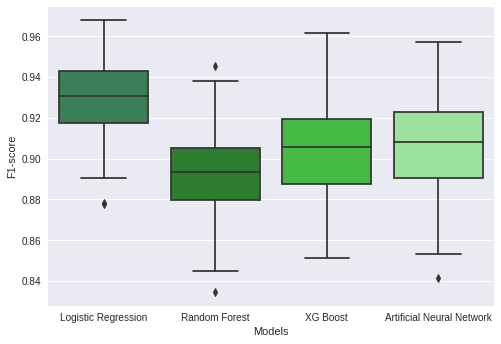

In [46]:
colors = ['#2E8B57', '#228B22', '#32CD32', '#90EE90']
sns.boxplot(data=f_1, palette=colors)
plt.ylabel('F1-score')
plt.xlabel('Models')
plt.show()

## Build the index

In [63]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [64]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [65]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-0.46583005443195075, 13.491884804560211, 0.009817646809307943)

In [66]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [67]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.03407776316155548)

In [68]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-0.171379922993264, 0.9496505654725468, 0.006698273817284018)

In [69]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [70]:
IND_fin["access"] = 1- IND_fin["access"]
IND_fin["usage"] = 1- IND_fin["usage"]

In [71]:
IND_fin

access     usage female   age         educ    inc_q  fin34a
0     0.975318  0.760948      F  75.0  high school   middle       0
1     0.968716  0.853734      M  30.0   university  richest       1
2     0.972539  0.581022      M  41.0  high school   second       1
3     0.968311  0.874827      F  64.0   university  richest       0
4     0.968592  0.868010      M  40.0   university   second       1
...        ...       ...    ...   ...          ...      ...     ...
1002  0.967381  0.847600      M  60.0   university   fourth       0
1003  0.968128  0.873396      F  57.0  high school  poorest       0
1004  0.968952  0.901169      M  35.0   university  richest       1
1005  0.967284  0.862878      M  69.0   university  richest       1
1006  0.969476  0.889423      M  34.0   university   fourth       1

[1007 rows x 7 columns]

In [72]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

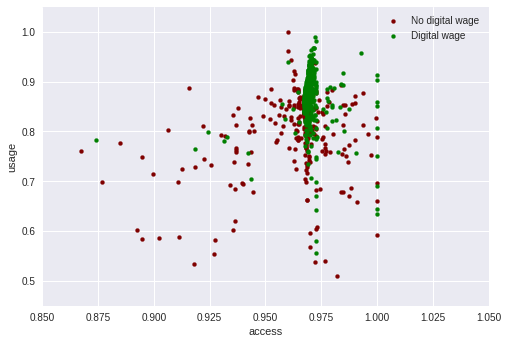

In [82]:
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=16, color="#7f0000")
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=16, color="#007f00")
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
plt.xlim([0.85,1.05])
plt.ylim([0.45,1.05])
plt.show()